In [1]:
!pip install similaritymeasures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.4/400.4 KB 20.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for similaritymeasures: filename=similaritymeasures-0.6.0-py3-none-any.whl size=15480 sha256=860f3bce9ba5a6449c5ed53e0f13c00920a946f75b883f840e6675ac3c9d4ccd
  Stored in directory: /root/.cache/pip/wheels/aa/4d/4b/d28f0a3cfd4e43226096568b08ce6ff997e80d3fdc9a1ab080
Successfully built similaritymeasures


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import pytz
import warnings
import re
from scipy.spatial.distance import directed_hausdorff
import similaritymeasures
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.metrics import mean_squared_error
from math import sqrt
warnings.filterwarnings('ignore')
%matplotlib inline

from numpy import array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D, MaxPooling1D, Flatten, ConvLSTM2D, Dropout
import tensorflow.keras.backend as K

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm

In [3]:
df = pd.read_csv('dataset_clean.csv')

In [4]:
df.head()

departure_Date Origin_Destination  Target    0      1      2  \
0  2022-09-22 00:00:00+00:00            DXB-XXX     466  466  469.0  467.0   
1  2022-11-17 00:00:00+00:00            DXB-XXX     314  314  320.0  319.0   
2  2022-10-26 00:00:00+00:00            DXB-XXX     431  431  436.0  447.0   
3  2022-09-19 00:00:00+00:00            DXB-XXX     385  385  392.0  386.0   
4  2022-06-03 00:00:00+00:00            XXX-DXB     507  507  492.0  480.0   

       3      4      5      6  ...  335  336  337  338  339  340  341  \
0  473.0  458.0  456.0  456.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  314.0  309.0  310.0  303.0  ...  0.0  0.0  1.0  1.0  1.0  0.0  0.0   
2  443.0  441.0  448.0  452.0  ...  1.0  1.0  1.0  1.0  0.0  0.0  0.0   
3  405.0  400.0  391.0  387.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  508.0  500.0  508.0  509.0  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   departure_month  departure_dayofweek  depature_weekend  
0                9                    3                 0  
1               11                    3                 0  
2               10                    2                 0  
3                9                    0                 0  
4                6                    4                 0  

[5 rows x 348 columns]

In [5]:
for n,i in df.iterrows():
    target = df.loc[n,'Target']
    for seat in range(0,342):
        df.loc[n,str(seat)] = round(df.loc[n,str(seat)]/target,4)
    

In [6]:
df.head()

departure_Date Origin_Destination  Target  0       1       2  \
0  2022-09-22 00:00:00+00:00            DXB-XXX     466  1  1.0064  1.0021   
1  2022-11-17 00:00:00+00:00            DXB-XXX     314  1  1.0191  1.0159   
2  2022-10-26 00:00:00+00:00            DXB-XXX     431  1  1.0116  1.0371   
3  2022-09-19 00:00:00+00:00            DXB-XXX     385  1  1.0182  1.0026   
4  2022-06-03 00:00:00+00:00            XXX-DXB     507  1  0.9704  0.9467   

        3       4       5       6  ...     335     336     337     338  \
0  1.0150  0.9828  0.9785  0.9785  ...  0.0000  0.0000  0.0000  0.0000   
1  1.0000  0.9841  0.9873  0.9650  ...  0.0000  0.0000  0.0032  0.0032   
2  1.0278  1.0232  1.0394  1.0487  ...  0.0023  0.0023  0.0023  0.0023   
3  1.0519  1.0390  1.0156  1.0052  ...  0.0000  0.0000  0.0000  0.0000   
4  1.0020  0.9862  1.0020  1.0039  ...  0.0000  0.0000  0.0000  0.0000   

      339  340  341  departure_month  departure_dayofweek  depature_weekend  
0  0.0000  0.0  0.0                9                    3                 0  
1  0.0032  0.0  0.0               11                    3                 0  
2  0.0000  0.0  0.0               10                    2                 0  
3  0.0000  0.0  0.0                9                    0                 0  
4  0.0000  0.0  0.0                6                    4                 0  

[5 rows x 348 columns]

In [7]:
df['departure_month'].unique()

array([ 9, 11, 10,  6,  8,  7])

In [8]:
df_val = df[df['departure_month'].isin([11])]
df_train = df[~df['departure_month'].isin([11])]

In [9]:
df['Origin_Destination'].unique()

array(['DXB-XXX', 'XXX-DXB'], dtype=object)

In [10]:
df_train_dxb_xxx = df_train[df_train['Origin_Destination']=='DXB-XXX']
df_train_xxx_dxb = df_train[df_train['Origin_Destination']=='XXX-DXB']

df_val_dxb_xxx = df_val[df_val['Origin_Destination']=='DXB-XXX']
df_val_xxx_dxb = df_val[df_val['Origin_Destination']=='XXX-DXB']

In [11]:
df_train_dxb_xxx.reset_index(drop=True,inplace=True)
df_train_xxx_dxb.reset_index(drop=True,inplace=True)

df_val_dxb_xxx.reset_index(drop=True,inplace=True)
df_val_xxx_dxb.reset_index(drop=True,inplace=True)

In [12]:
_df_val_dxb_xxx = df_val_dxb_xxx.copy()
_df_val_xxx_dxb = df_val_xxx_dxb.copy()

In [ ]:
#df_val_dxb_xxx.loc[:,'0':'167']=np.nan
#df_val_xxx_dxb.loc[:,'0':'167']=np.nan

In [13]:
last_available_data=167

#### Data Preparation - DXB-XXX

In [14]:
X_train_dxb_xxx = df_train_dxb_xxx.loc[:,str(last_available_data+1):'341']
X_train_dxb_xxx = X_train_dxb_xxx[X_train_dxb_xxx.columns[::-1]].values
X_train_dxb_xxx = X_train_dxb_xxx.reshape(X_train_dxb_xxx.shape[0],-1,1)

Y_train_dxb_xxx = df_train_dxb_xxx.loc[:,'0':str(last_available_data)]
Y_train_dxb_xxx = Y_train_dxb_xxx[Y_train_dxb_xxx.columns[::-1]].values
Y_train_dxb_xxx = Y_train_dxb_xxx.reshape(Y_train_dxb_xxx.shape[0],-1,1)

X_val_dxb_xxx = df_val_dxb_xxx.loc[:,str(last_available_data+1):'341']
X_val_dxb_xxx = X_val_dxb_xxx[X_val_dxb_xxx.columns[::-1]].values
X_val_dxb_xxx = X_val_dxb_xxx.reshape(X_val_dxb_xxx.shape[0],-1,1)

Y_val_dxb_xxx = df_val_dxb_xxx.loc[:,'0':str(last_available_data)]
Y_val_dxb_xxx = Y_val_dxb_xxx[Y_val_dxb_xxx.columns[::-1]].values
Y_val_dxb_xxx = Y_val_dxb_xxx.reshape(Y_val_dxb_xxx.shape[0],-1,1)

In [15]:
X_train_dxb_xxx.shape

(151, 174, 1)

In [16]:
Y_train_dxb_xxx.shape

(151, 168, 1)

In [17]:
X_val_dxb_xxx.shape

(30, 174, 1)

In [18]:
Y_val_dxb_xxx.shape

(30, 168, 1)

### Data Preparation - XXX-DXB

In [19]:
X_train_xxx_dxb = df_train_xxx_dxb.loc[:,str(last_available_data+1):'341']
X_train_xxx_dxb = X_train_xxx_dxb[X_train_xxx_dxb.columns[::-1]].values
X_train_xxx_dxb = X_train_xxx_dxb.reshape(X_train_xxx_dxb.shape[0],-1,1)

Y_train_xxx_dxb = df_train_xxx_dxb.loc[:,'0':str(last_available_data)]
Y_train_xxx_dxb = Y_train_xxx_dxb[Y_train_xxx_dxb.columns[::-1]].values
Y_train_xxx_dxb = Y_train_xxx_dxb.reshape(Y_train_xxx_dxb.shape[0],-1,1)

X_val_xxx_dxb = df_val_xxx_dxb.loc[:,str(last_available_data+1):'341']
X_val_xxx_dxb = X_val_xxx_dxb[X_val_xxx_dxb.columns[::-1]].values
X_val_xxx_dxb = X_val_xxx_dxb.reshape(X_val_xxx_dxb.shape[0],-1,1)

Y_val_xxx_dxb = df_val_xxx_dxb.loc[:,'0':str(last_available_data)]
Y_val_xxx_dxb = Y_val_xxx_dxb[Y_val_xxx_dxb.columns[::-1]].values
Y_val_xxx_dxb = Y_val_xxx_dxb.reshape(Y_val_xxx_dxb.shape[0],-1,1)

In [20]:
n_steps = X_train_dxb_xxx.shape[1] 
n_lookup = Y_train_dxb_xxx.shape[1] 
n_features = X_train_dxb_xxx.shape[2]

In [21]:
model_dxb_xxx = Sequential()
model_dxb_xxx.add(LSTM(100, activation='tanh', input_shape=(n_steps, n_features)))
model_dxb_xxx.add(RepeatVector(n_lookup))
model_dxb_xxx.add(LSTM(100, activation='tanh', return_sequences=True))
model_dxb_xxx.add(TimeDistributed(Dense(1)))
model_dxb_xxx.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.02), loss= 'mean_squared_error')

model_dxb_xxx.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 repeat_vector (RepeatVector  (None, 168, 100)         0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 168, 100)          80400     
                                                                 
 time_distributed (TimeDistr  (None, 168, 1)           101       
 ibuted)                                                         
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


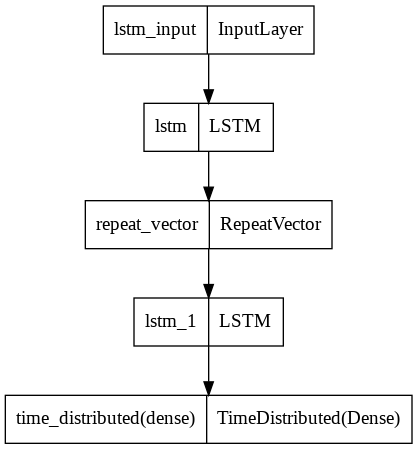

In [22]:
tf.keras.utils.plot_model(model_dxb_xxx)

In [23]:
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
red_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

In [24]:
N_SAMPLE = 20
_Y_val_dxb_xxx = np.zeros((X_val_dxb_xxx.shape[0],n_lookup))

for samples in tqdm(range(N_SAMPLE)):
    tf.keras.backend.clear_session()
    
    model_dxb_xxx.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.02), loss= 'mean_squared_error')
    history_tcm = model_dxb_xxx.fit(X_train_dxb_xxx, Y_train_dxb_xxx, 
                                validation_data = (X_val_dxb_xxx, Y_val_dxb_xxx), 
                                epochs=100, 
                                verbose = 0,
                                batch_size = 16, 
                                callbacks=[es, red_lr])
    
  
    #yhat_tcm += np.expm1(model_tcm.predict(Xtest_sub)).reshape(-1,n_lookup)
    _Y_val_dxb_xxx += model_dxb_xxx.predict(X_val_dxb_xxx).reshape(-1,n_lookup)

_Y_val_dxb_xxx = _Y_val_dxb_xxx / N_SAMPLE

  0%|          | 0/20 [00:00<?, ?it/s]

1/1 [==============================] - 1s 613ms/step


1/1 [==============================] - 1s 641ms/step


1/1 [==============================] - 1s 622ms/step


In [25]:
for n, i in df_val_dxb_xxx.iterrows():
  df_val_dxb_xxx.loc[n,'0':str(last_available_data)] = _Y_val_dxb_xxx[n].reshape(-1)[::-1]

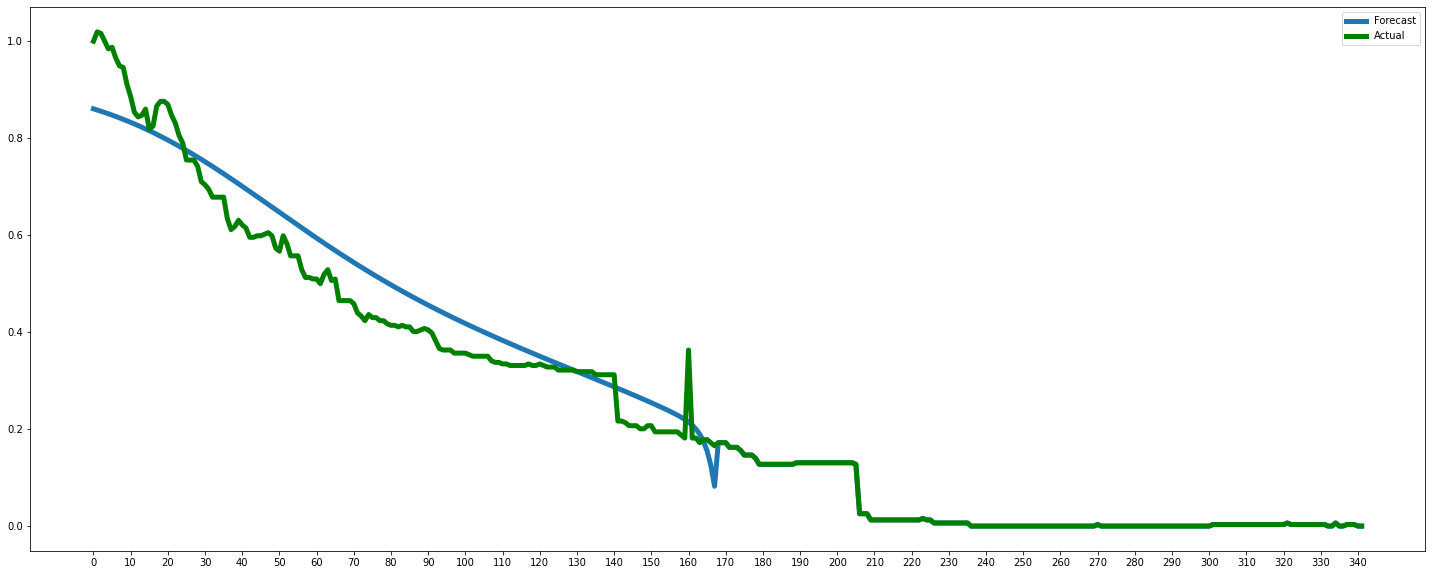

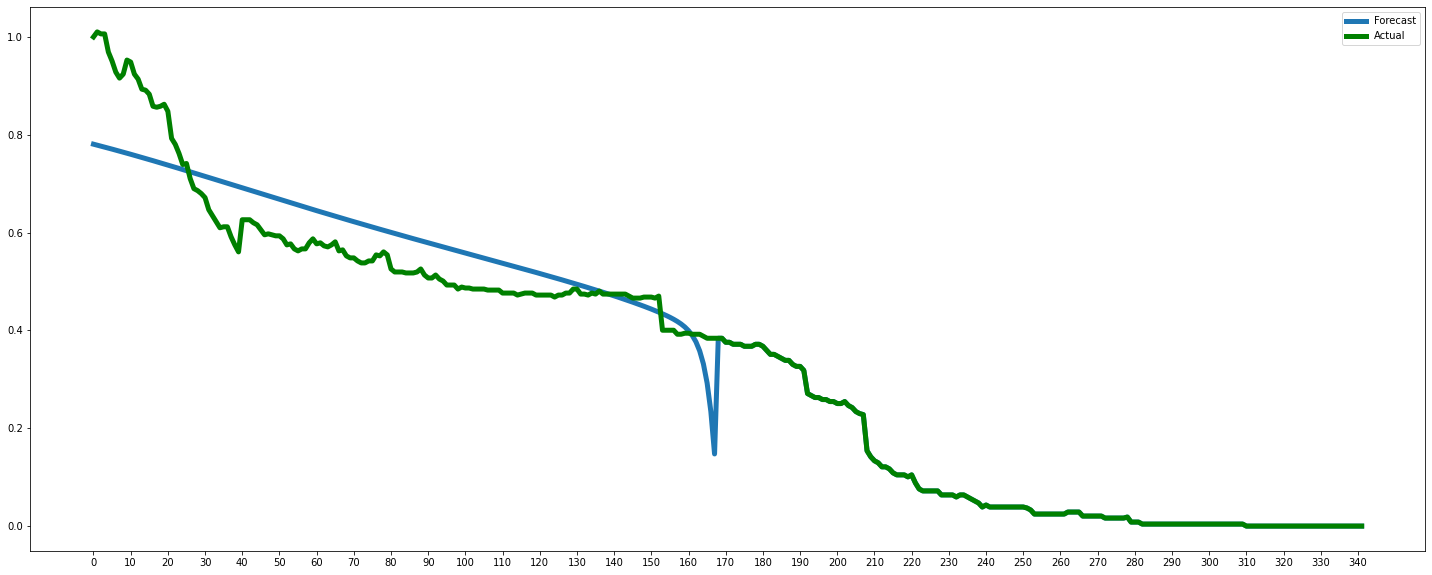

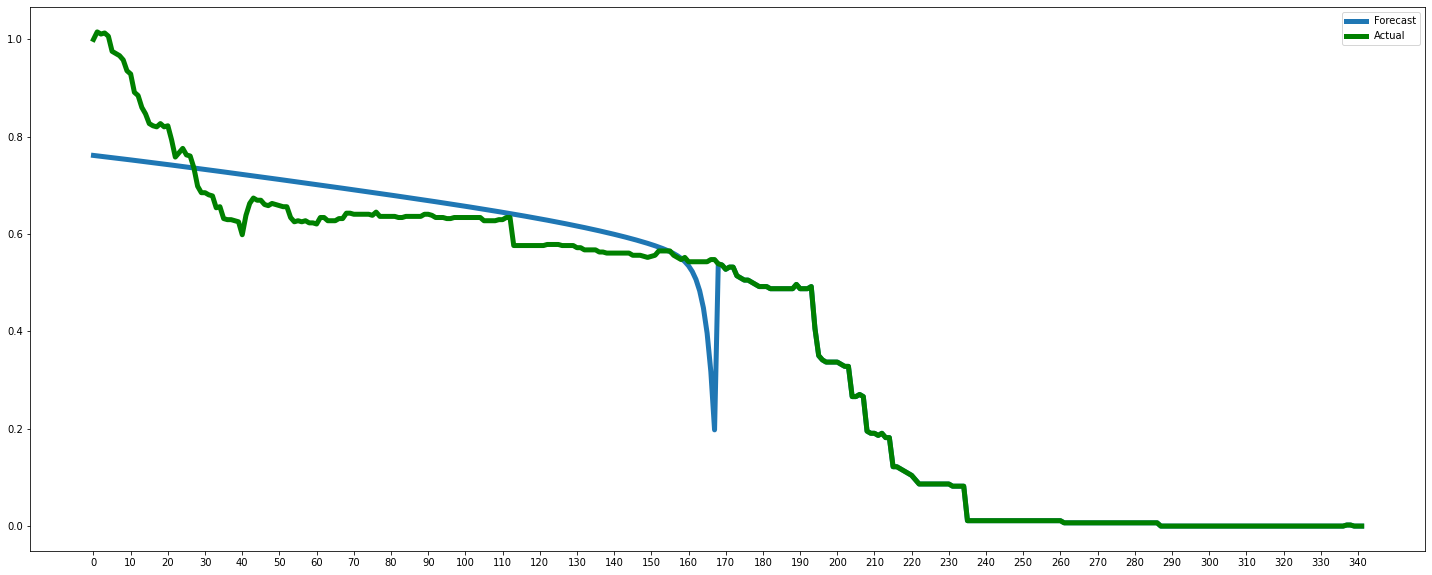

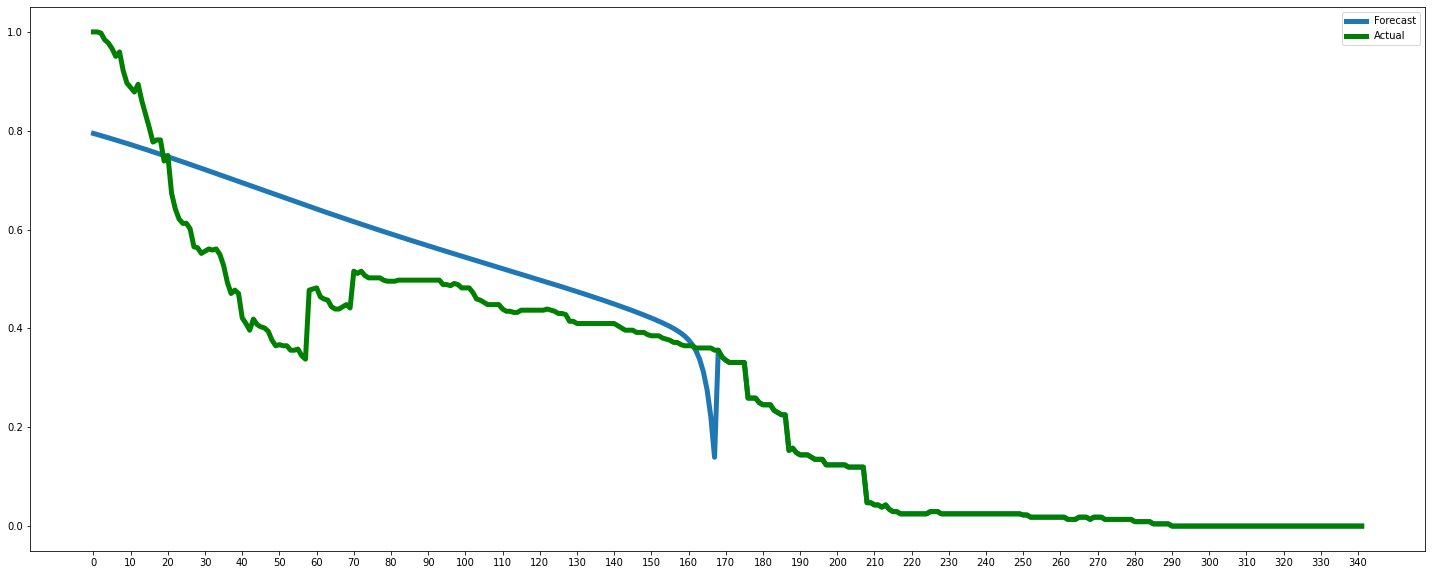

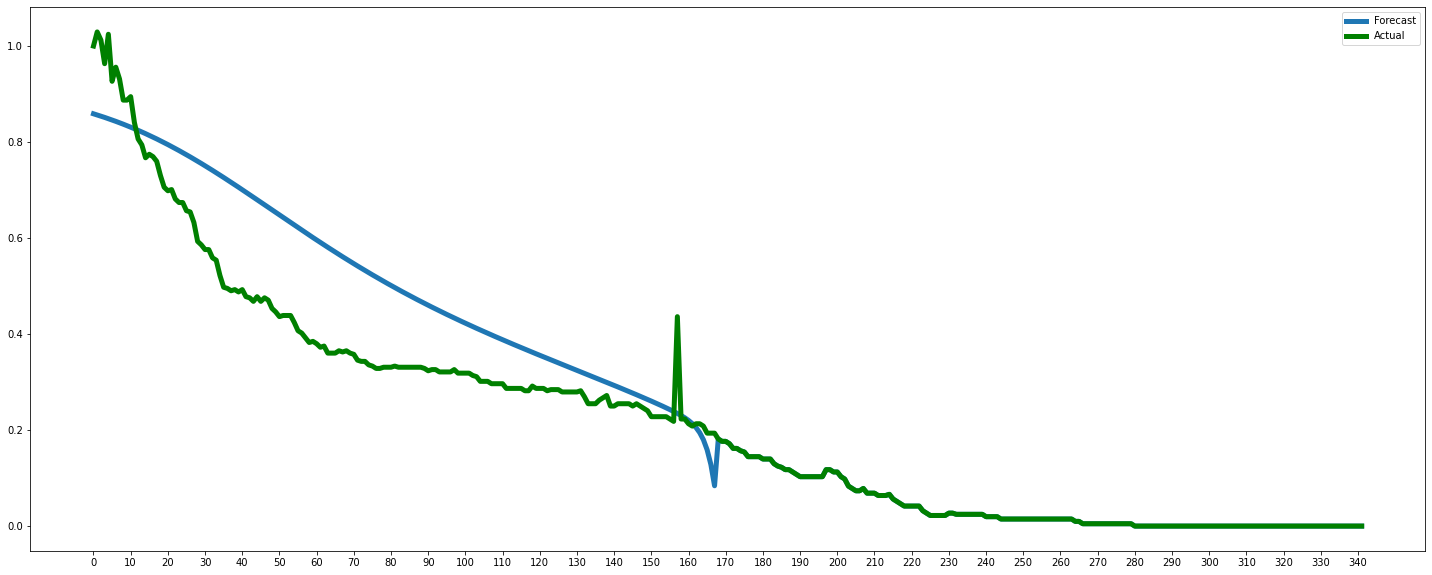

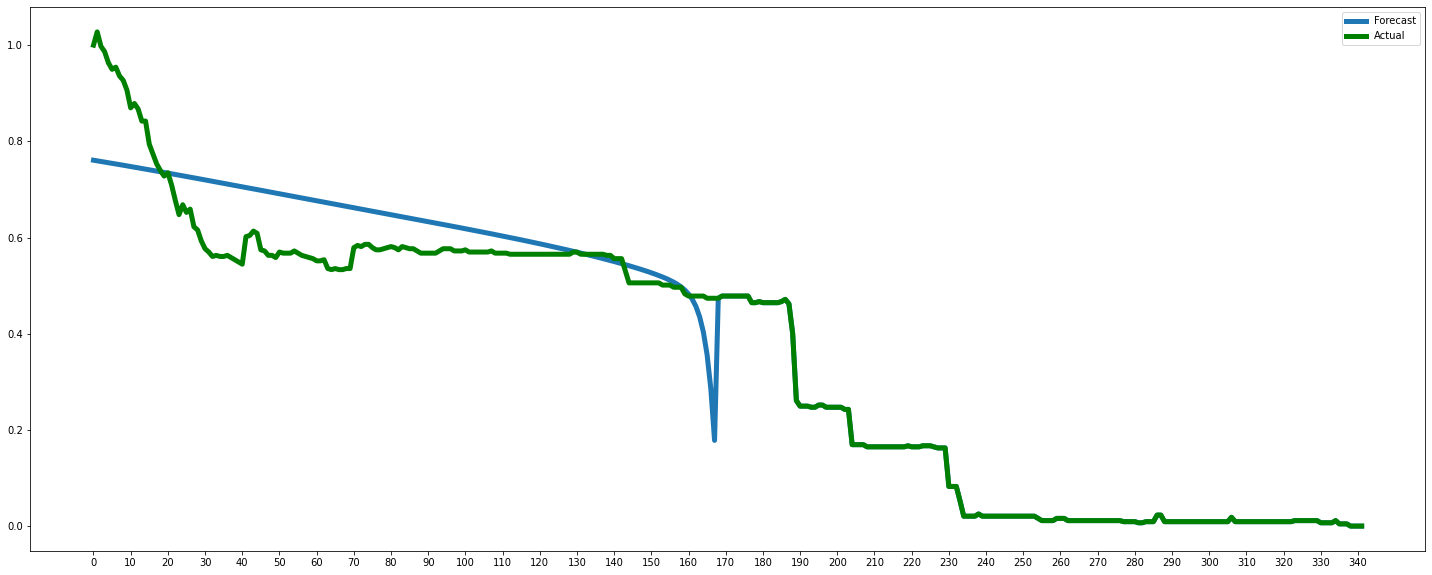

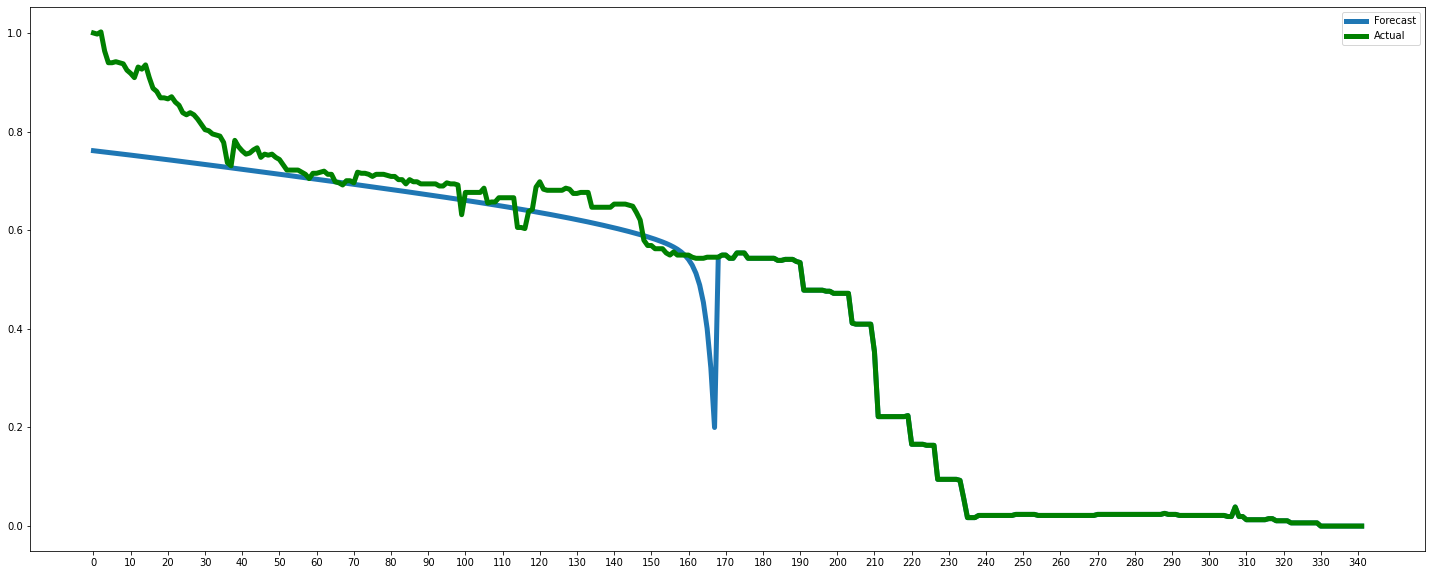

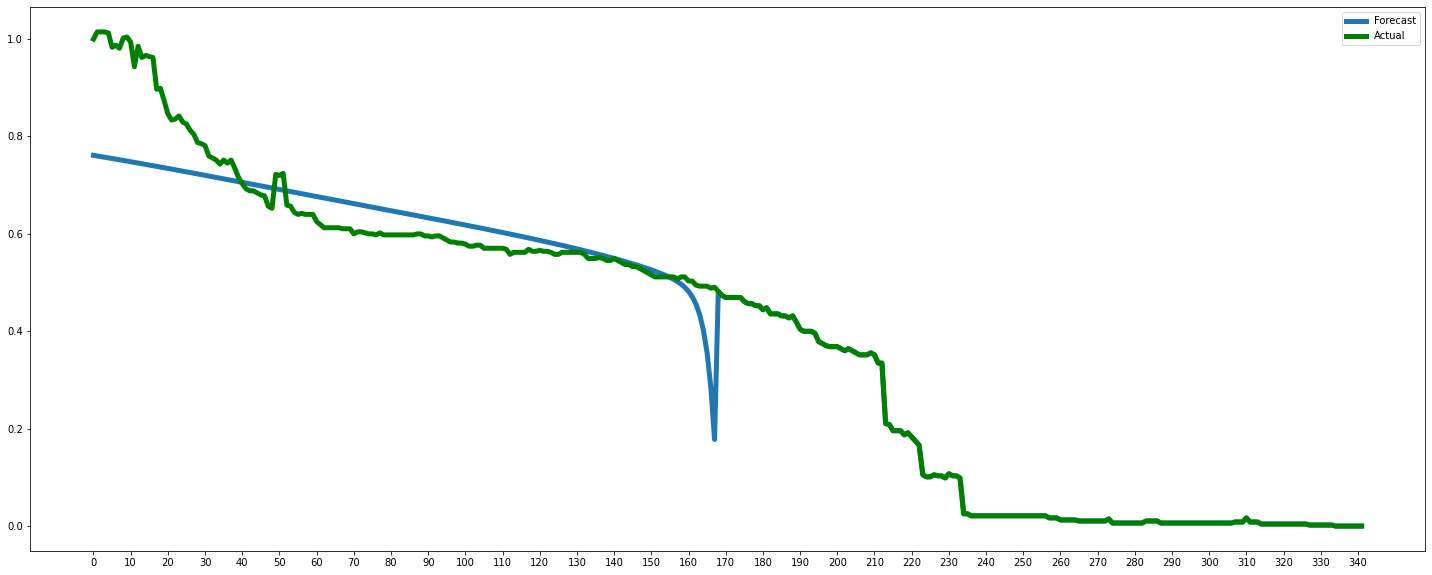

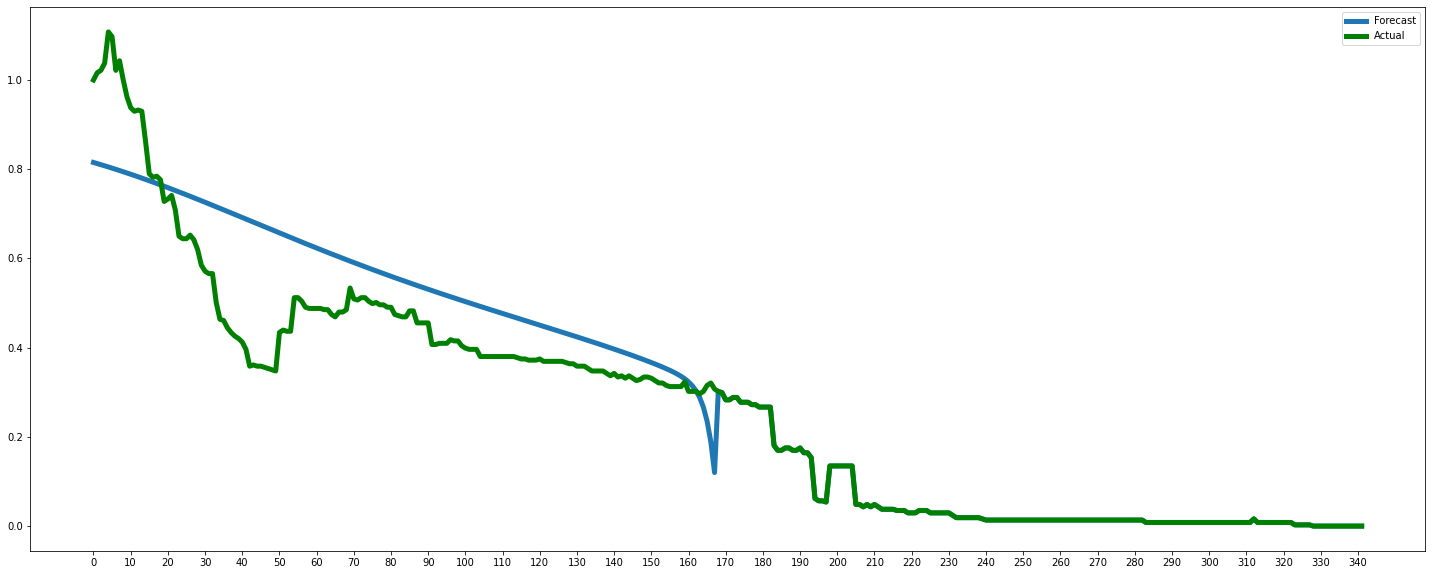

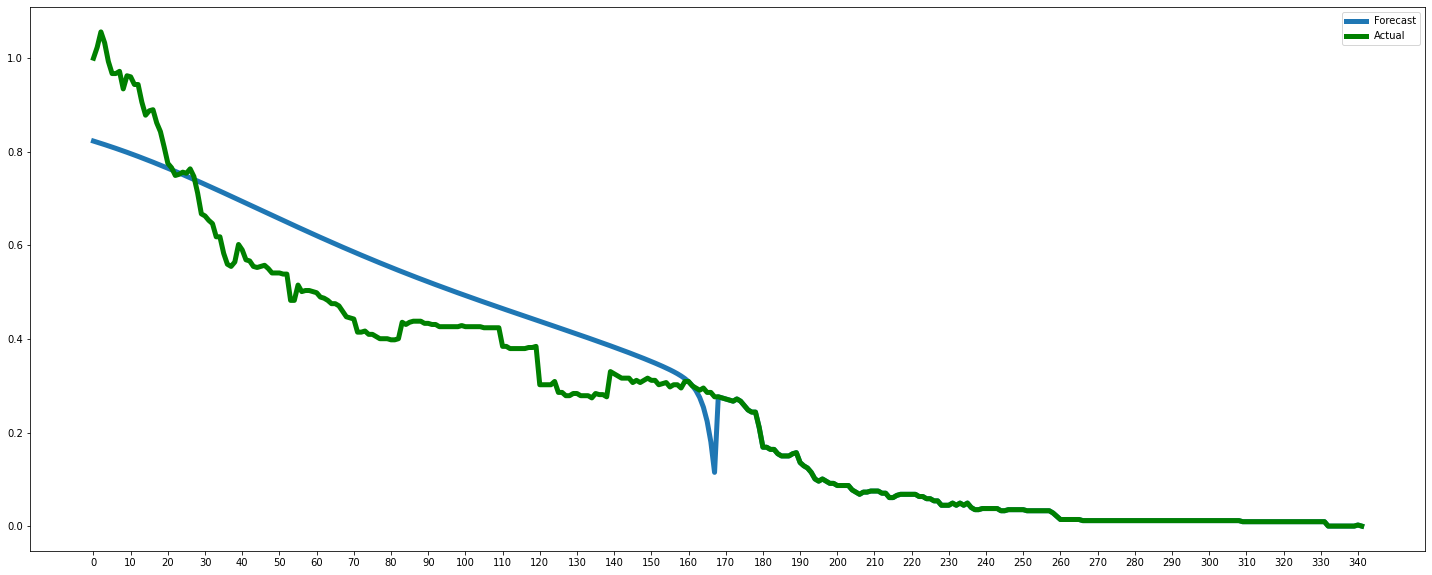

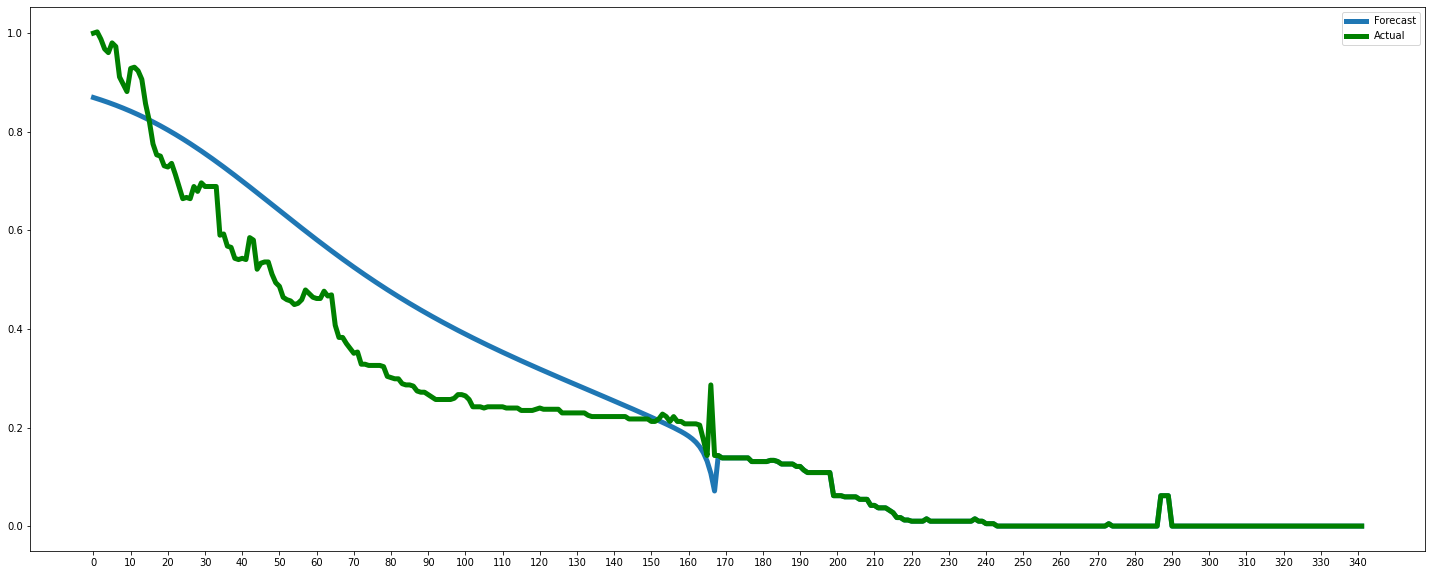

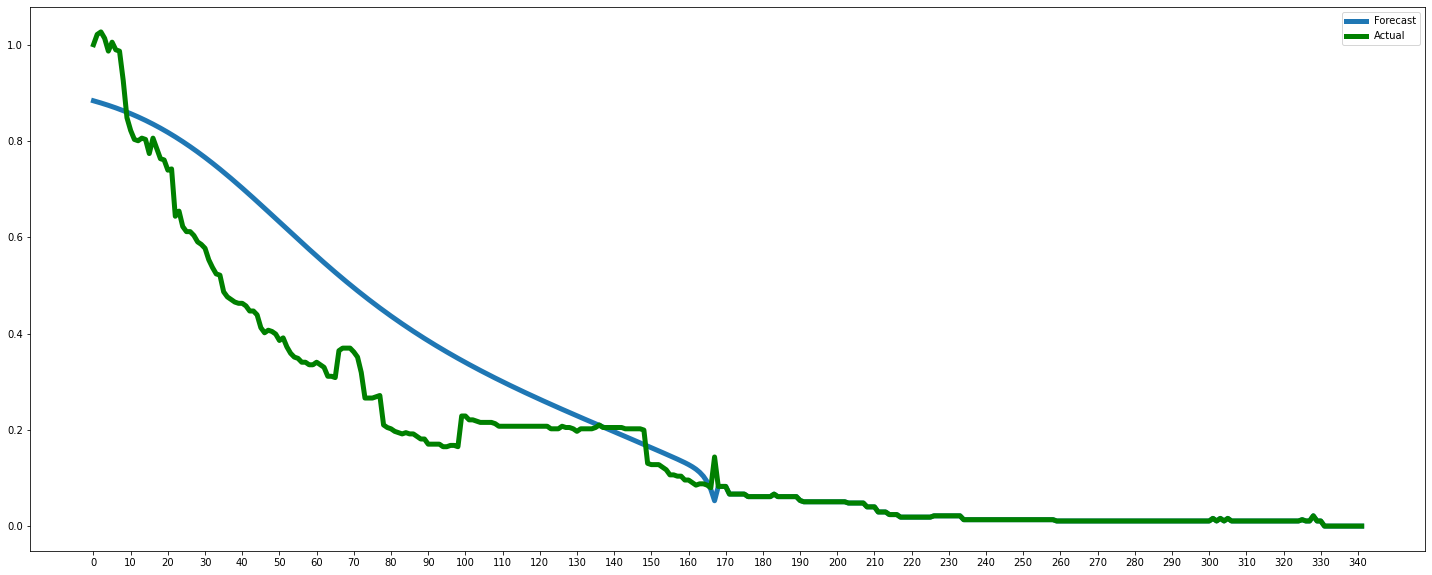

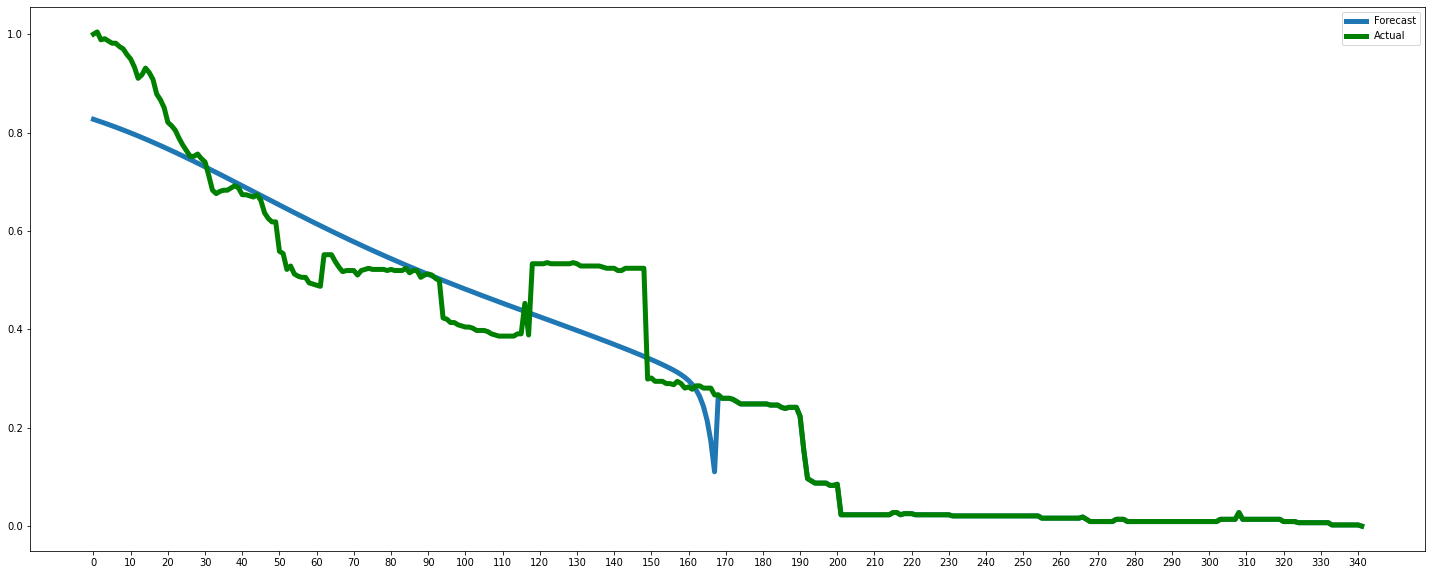

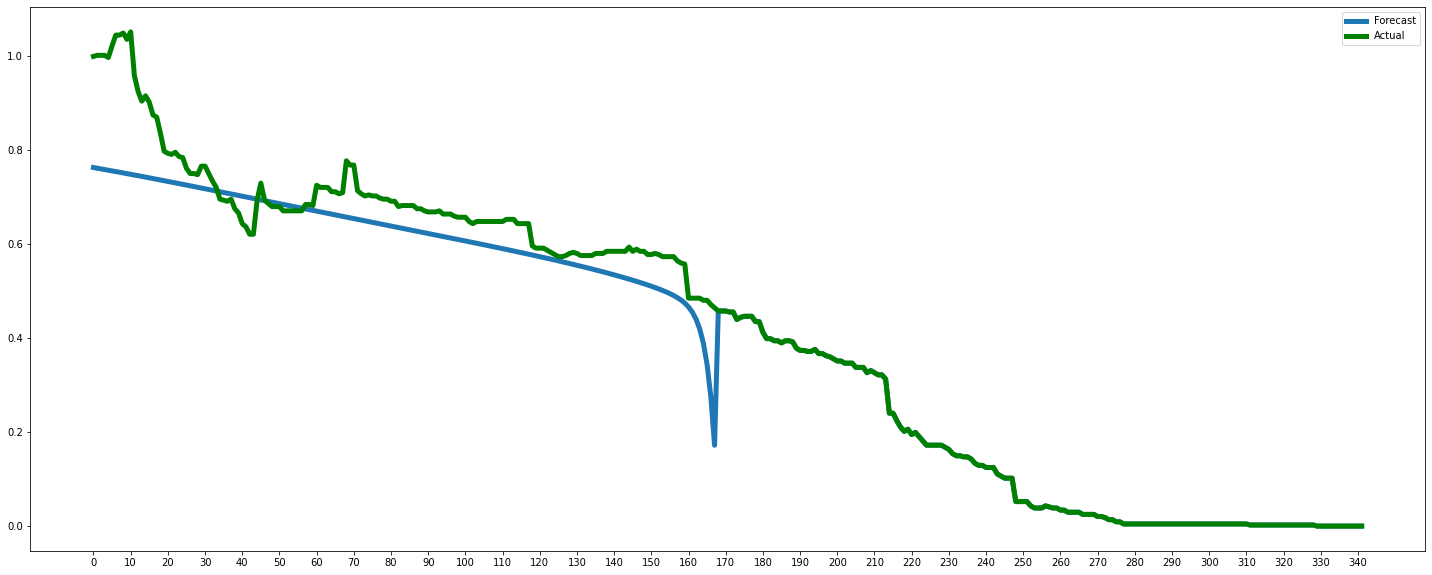

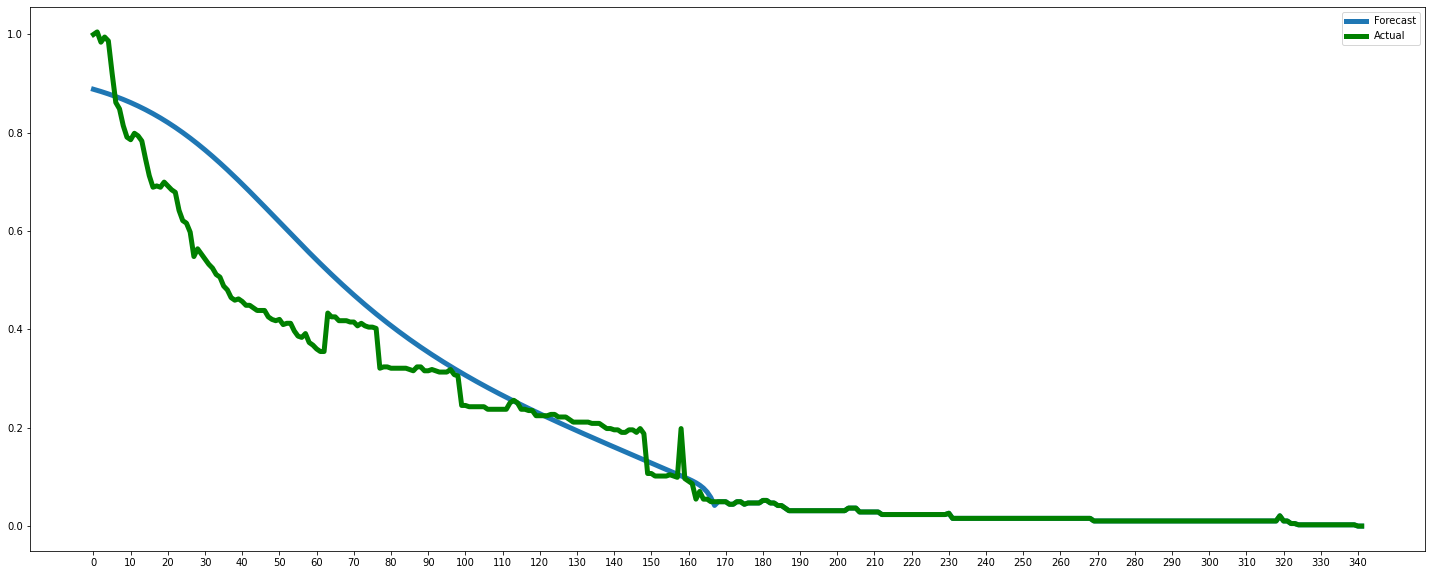

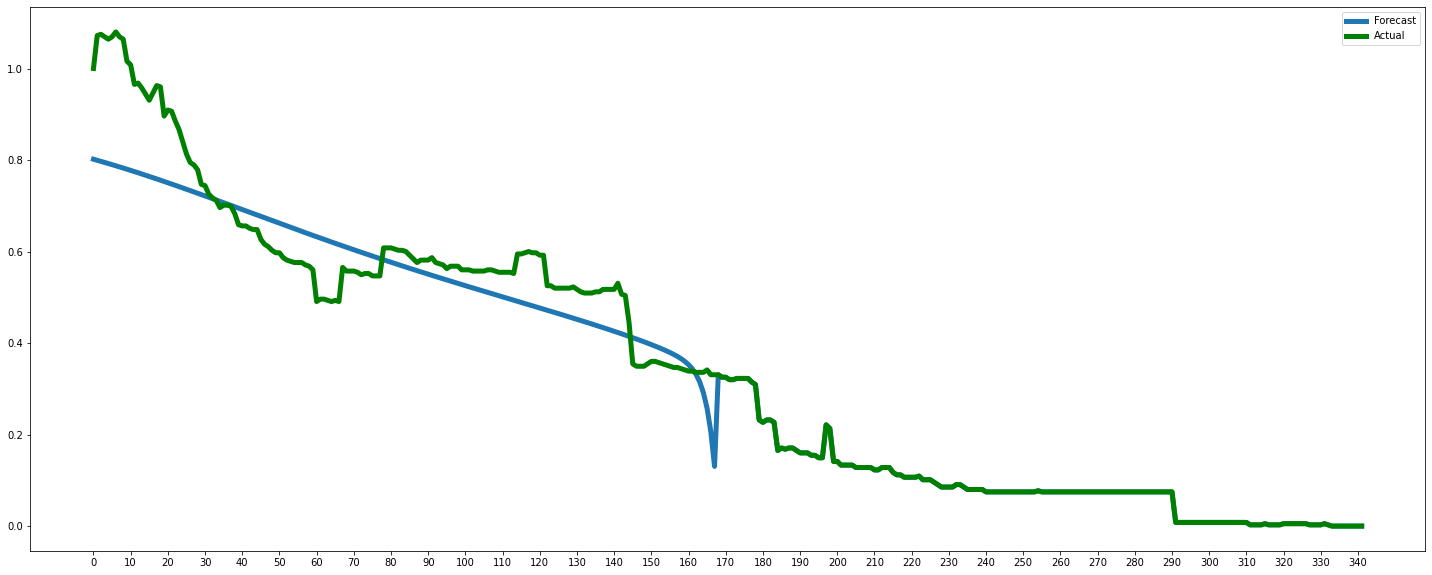

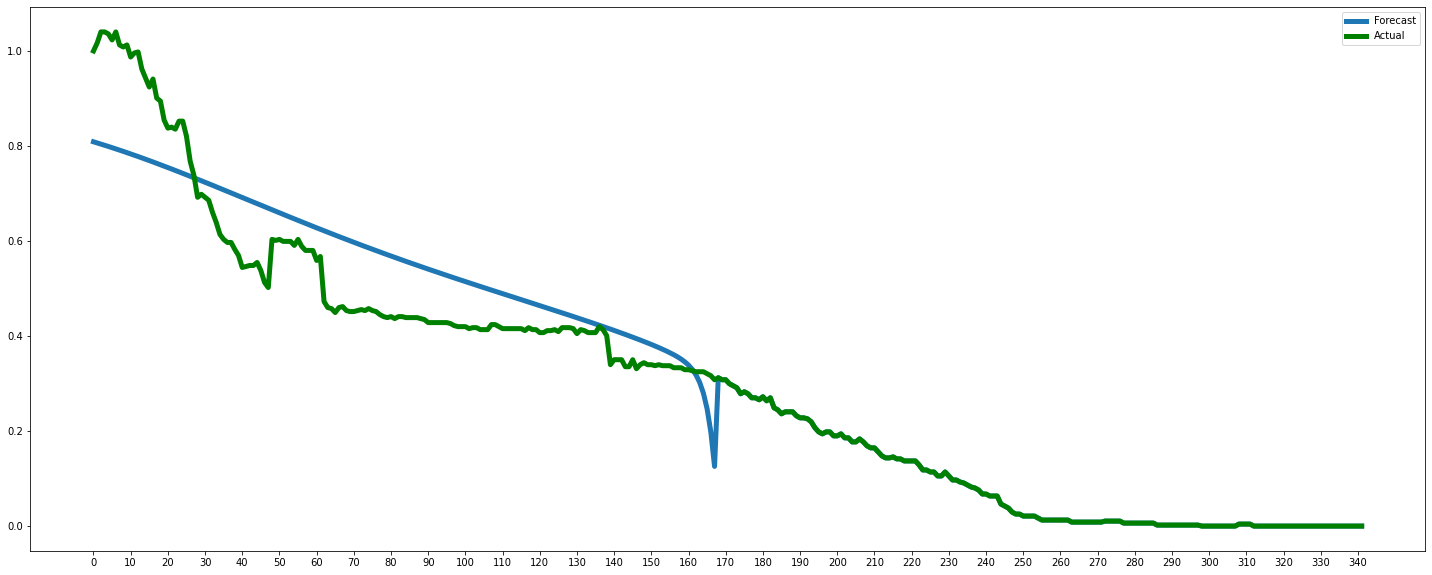

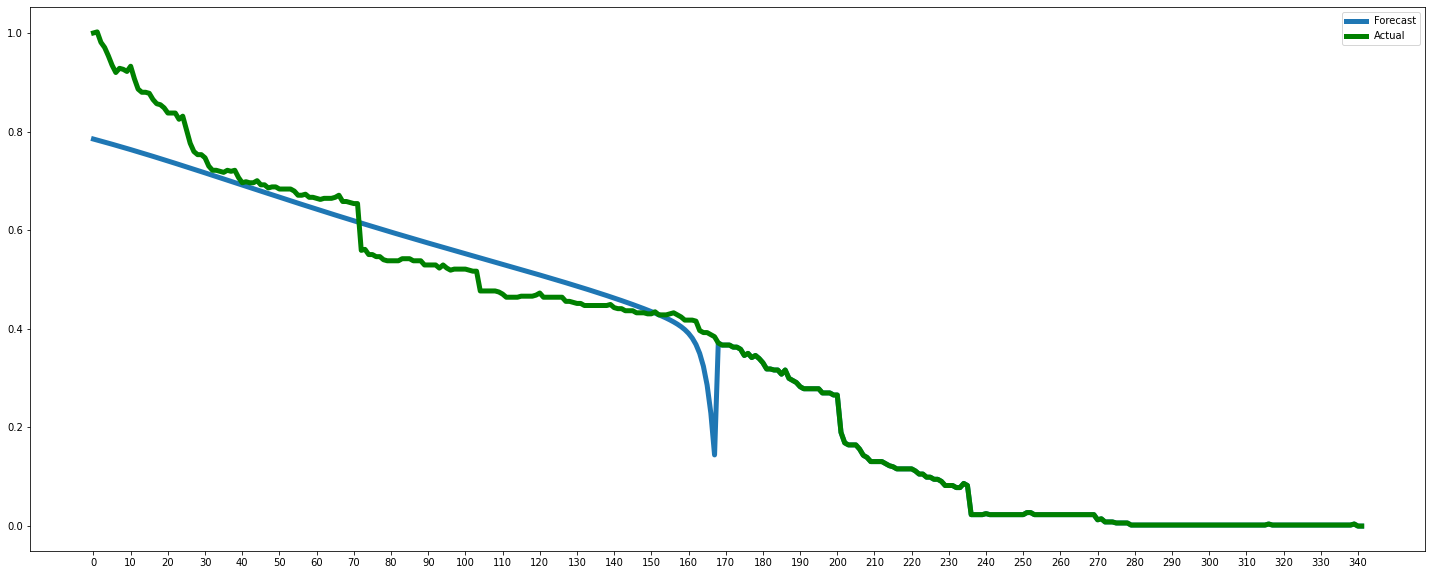

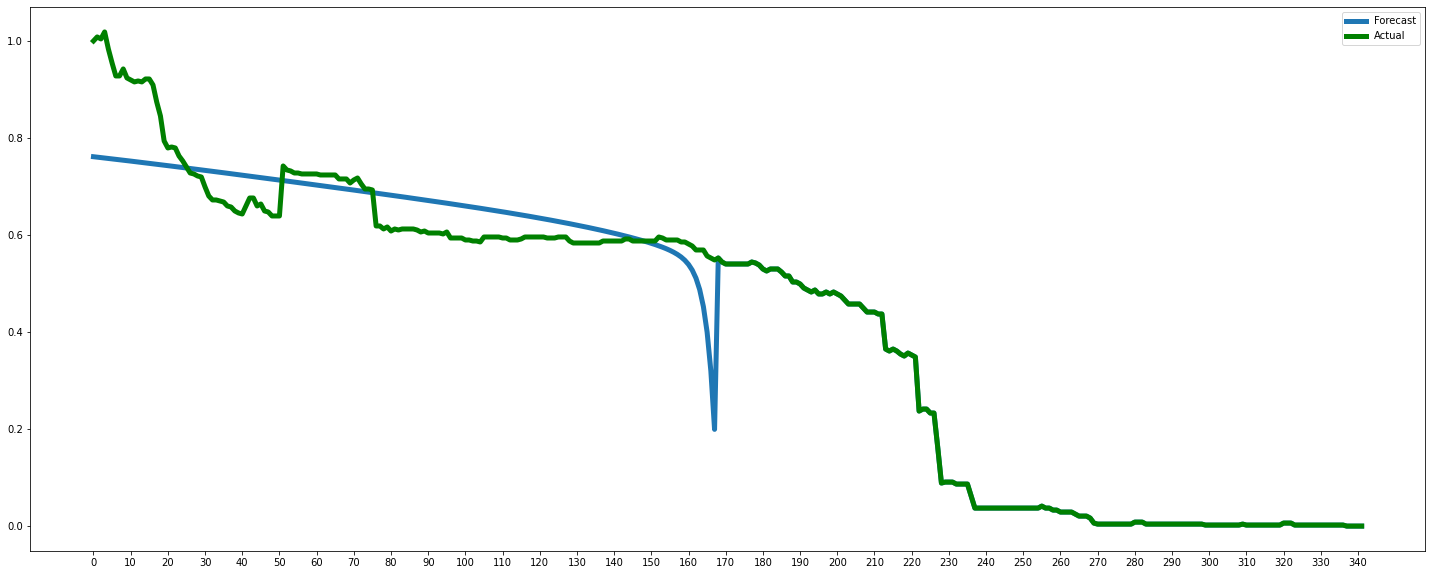

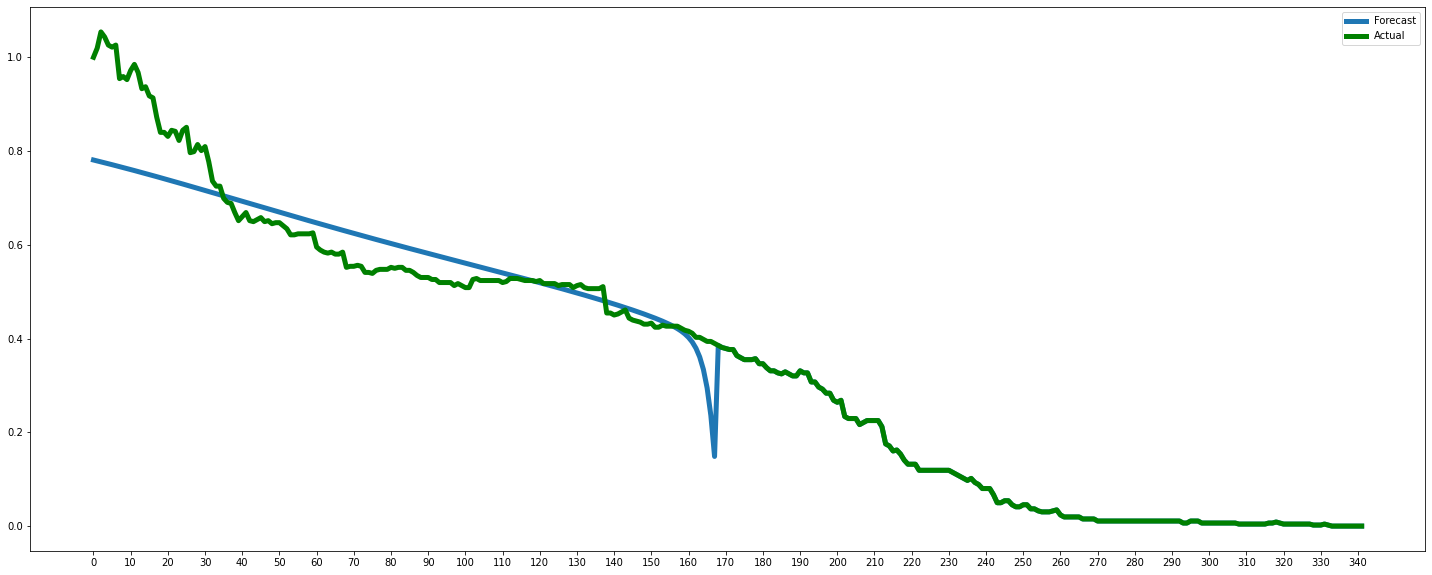

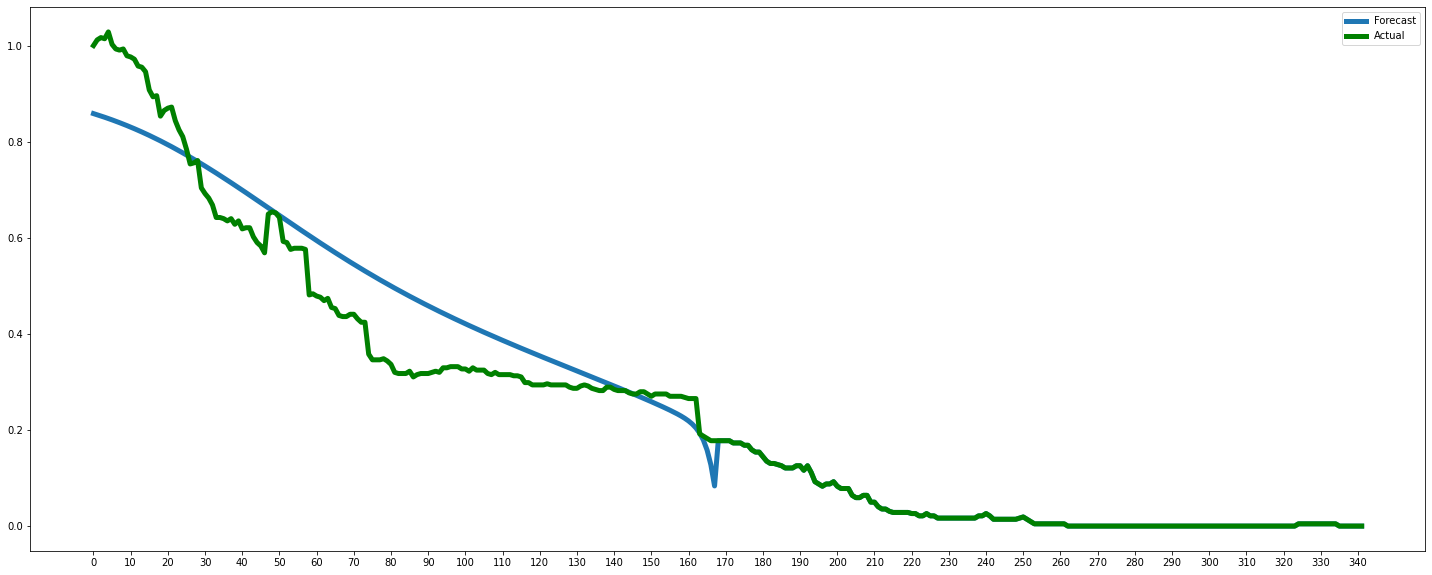

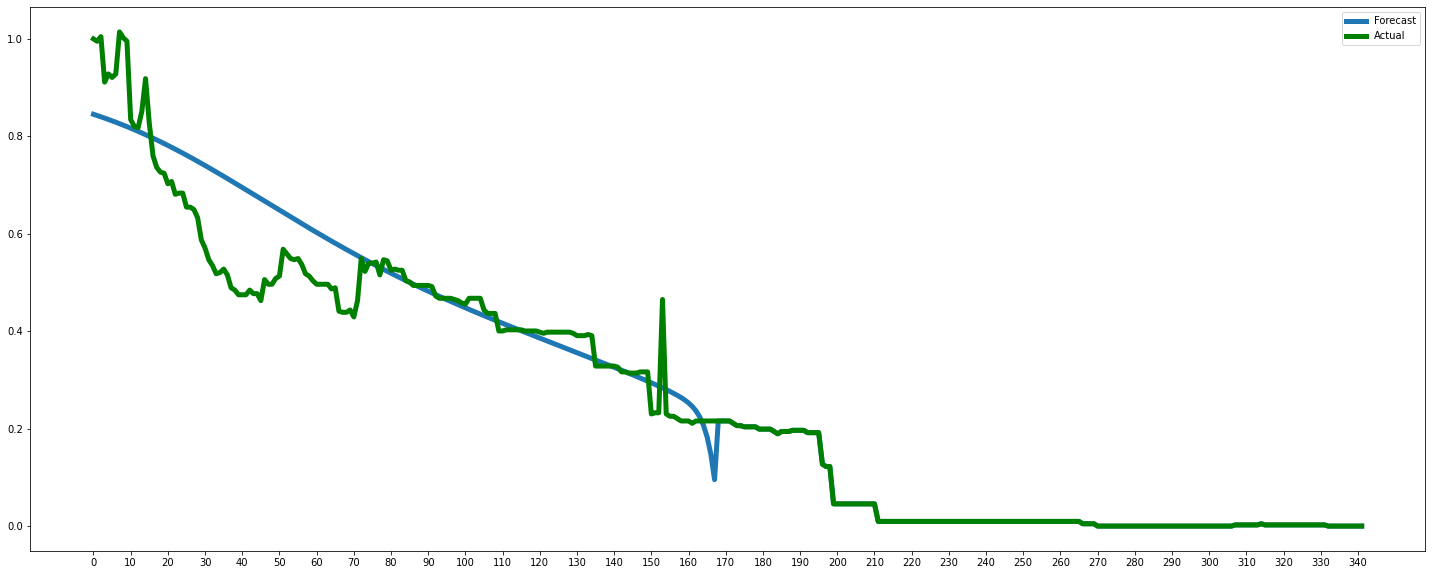

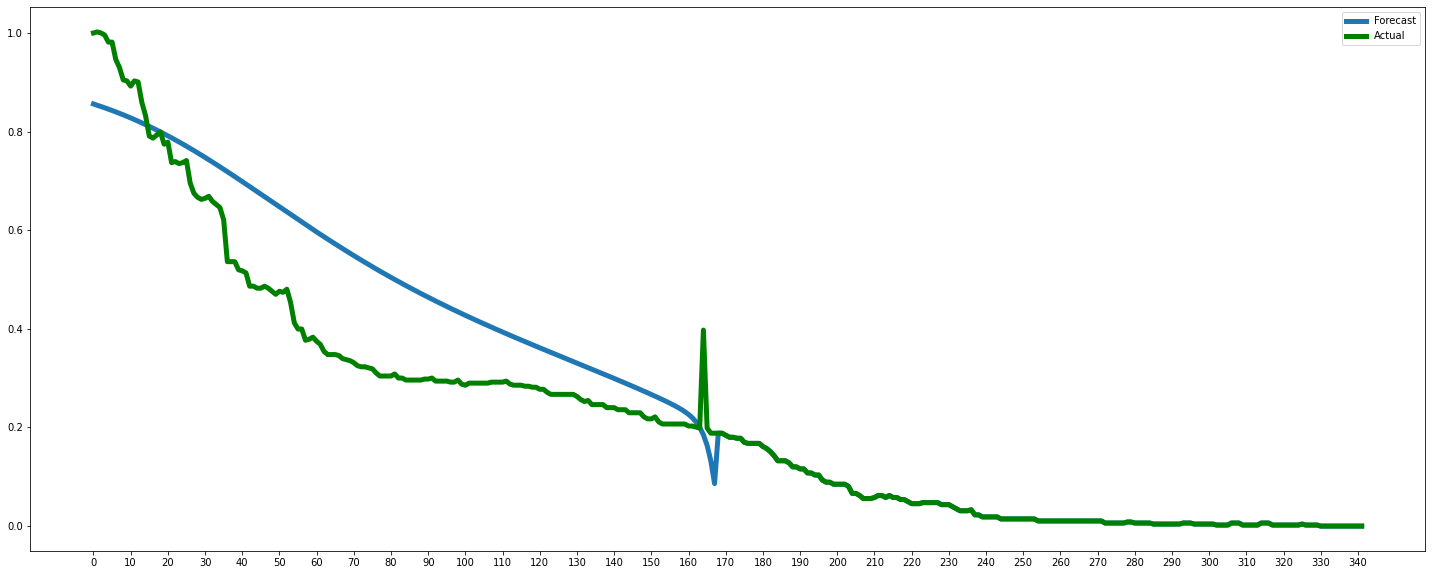

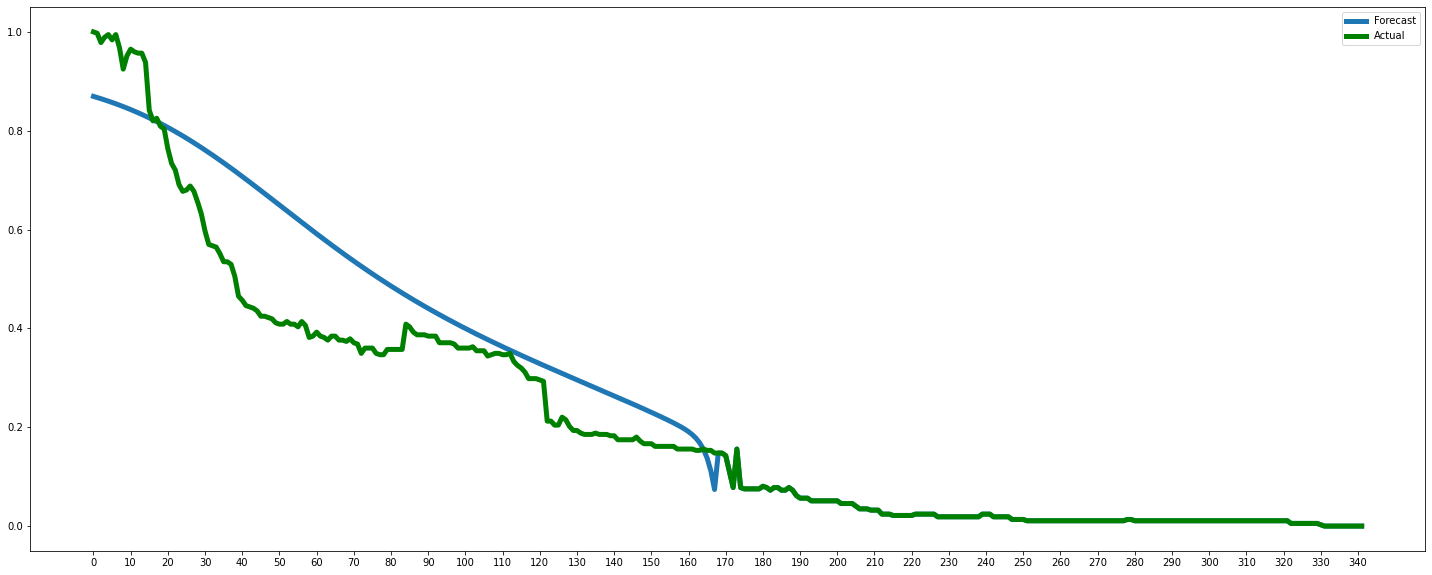

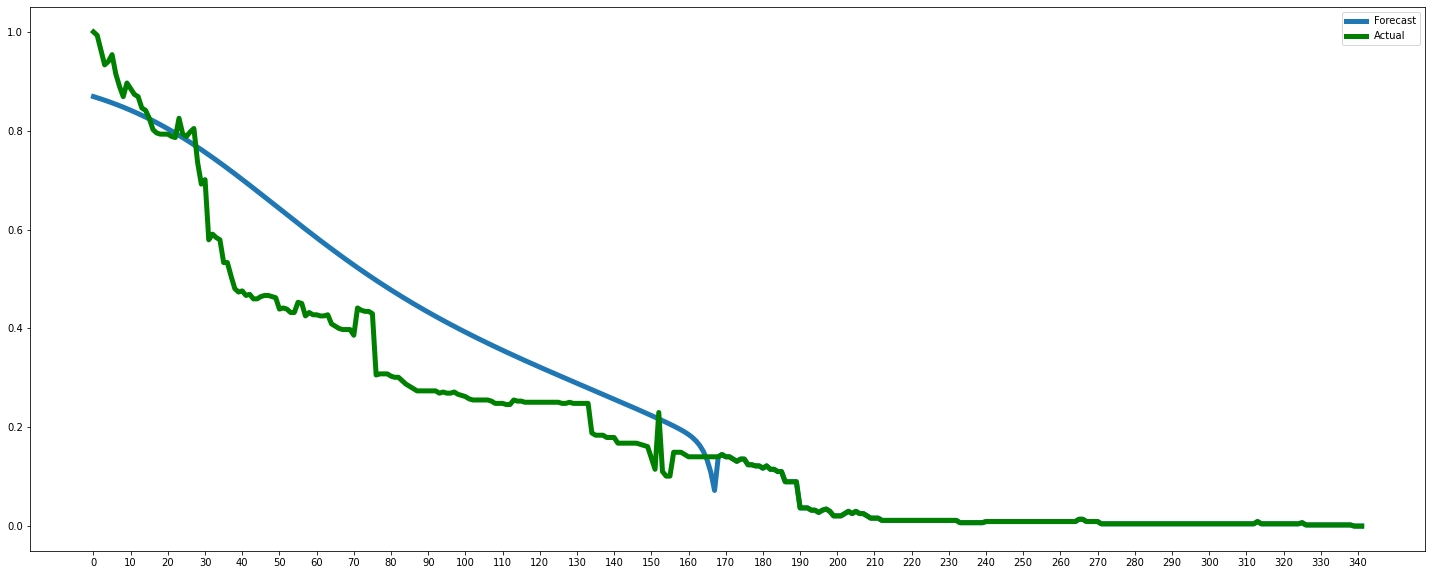

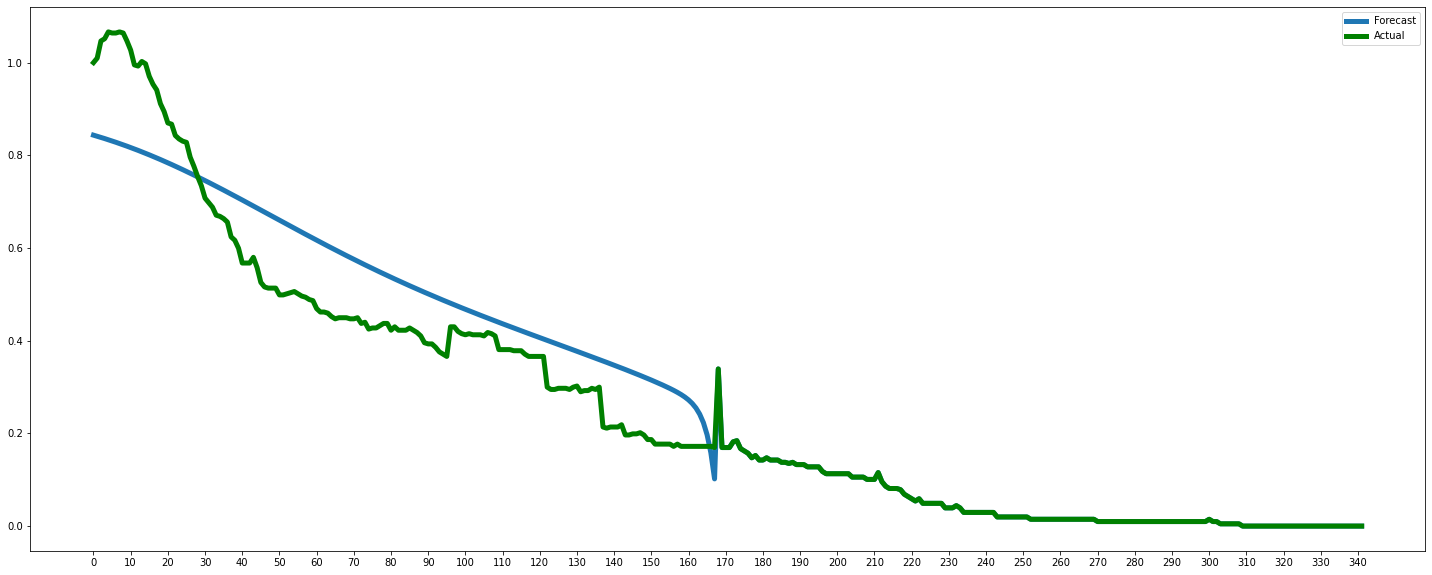

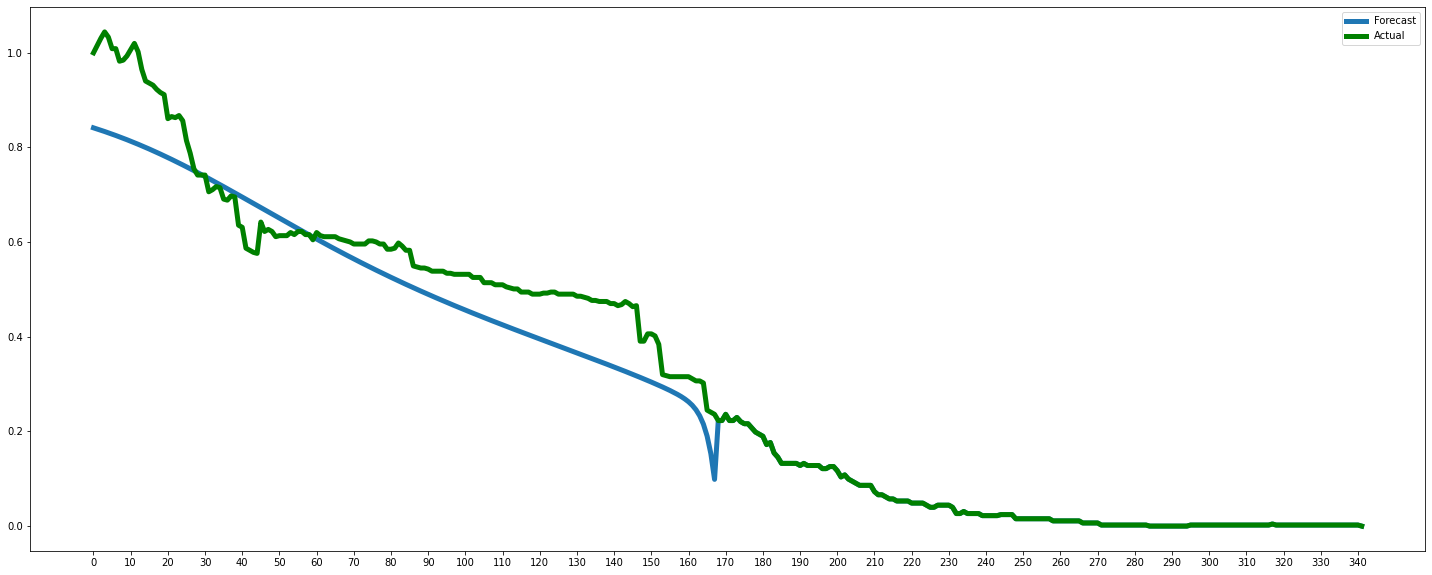

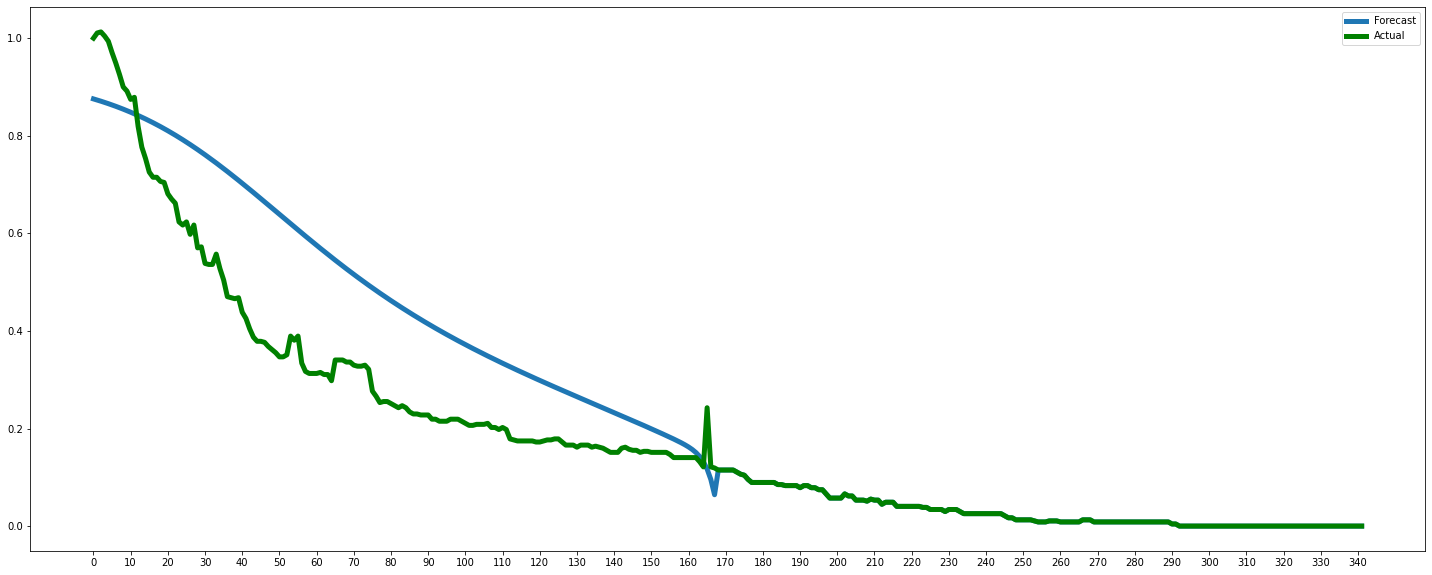

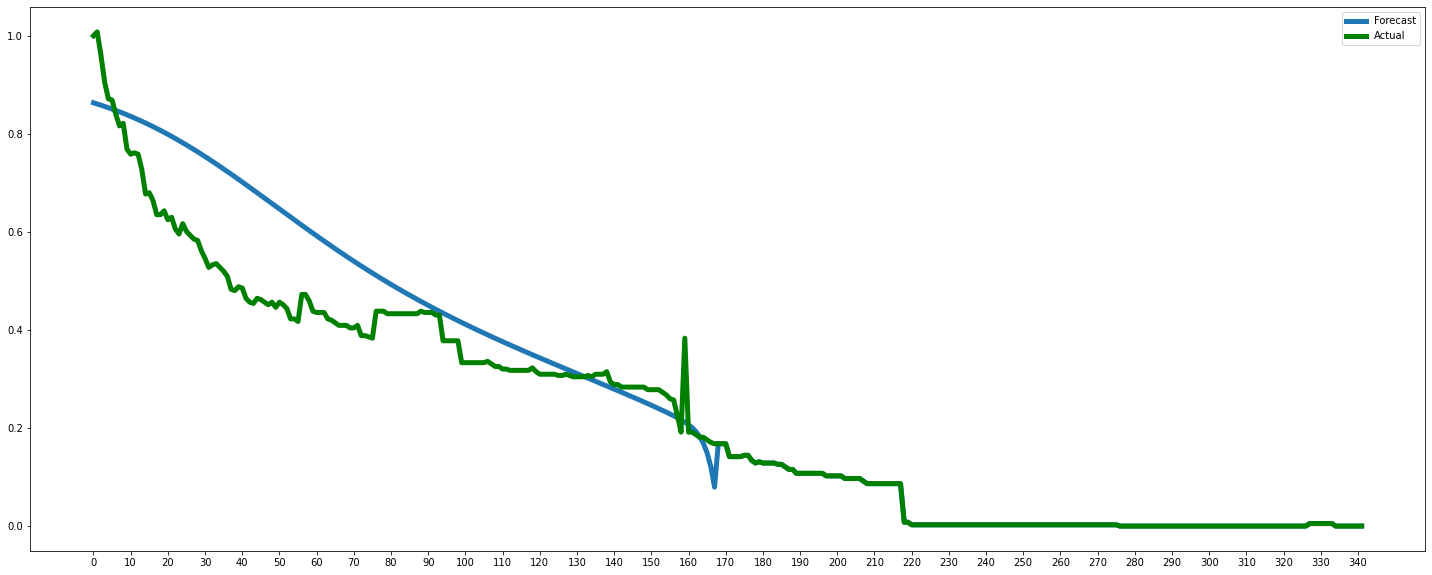

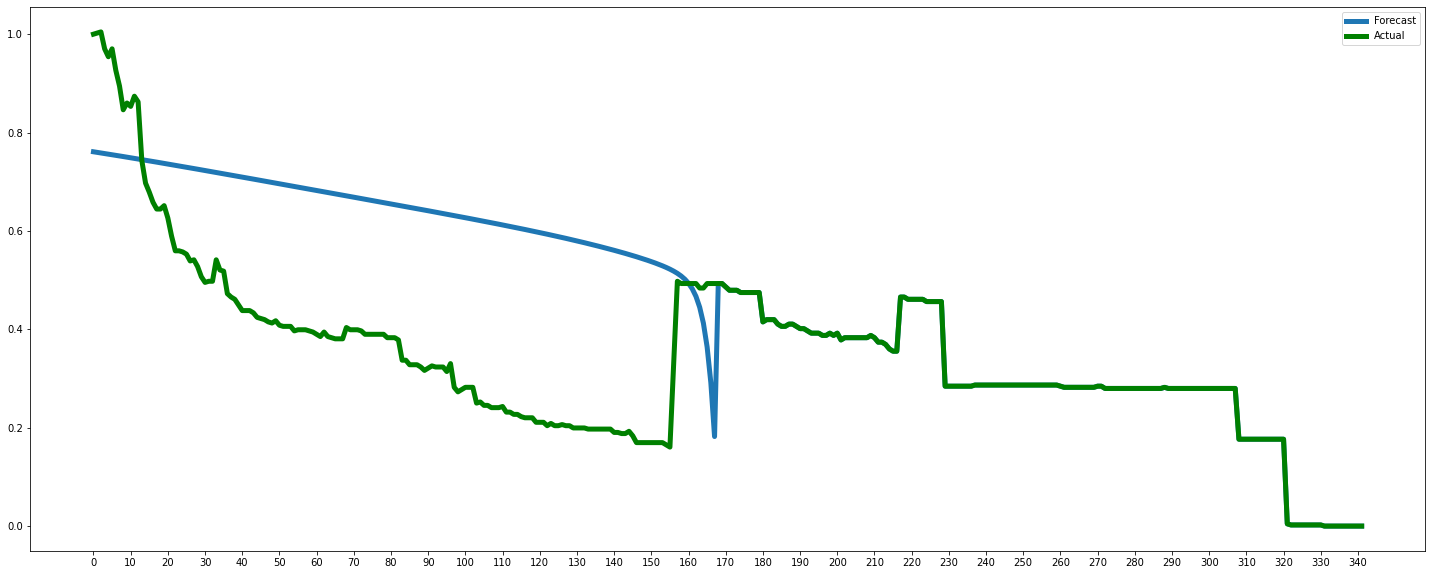

In [26]:
for v in range(df_val_dxb_xxx.shape[0]):
  df_val_dxb_xxx.loc[v,'0':str(last_available_data)] = _Y_val_dxb_xxx[v].reshape(-1)[::-1]
  rmse = sqrt(mean_squared_error(_df_val_dxb_xxx.loc[v,'0':'341'].values, df_val_dxb_xxx.loc[v,'0':'341'].values))
  df_val_dxb_xxx.loc[v,'RMSE']=rmse
  plt.figure(figsize=[25,10])
  plt.plot(df_val_dxb_xxx.loc[v,'0':'341'],  linestyle='-',linewidth=5, label='Forecast')
  plt.plot(_df_val_dxb_xxx.loc[v,'0':'341'],color='green',  linestyle='-',linewidth=5, label='Actual')
  plt.legend(loc='best')
  plt.xticks(np.arange(0, 342, 10))
  plt.show()

In [27]:
df_val_dxb_xxx['RMSE'].mean()

0.07997254323711486

In [28]:
model_xxx_dxb = Sequential()
model_xxx_dxb.add(LSTM(100, activation='tanh', input_shape=(n_steps, n_features)))
model_xxx_dxb.add(RepeatVector(n_lookup))
model_xxx_dxb.add(LSTM(100, activation='tanh', return_sequences=True))
model_xxx_dxb.add(TimeDistributed(Dense(1)))
model_xxx_dxb.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.02), loss= 'mean_squared_error')

model_xxx_dxb.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 repeat_vector (RepeatVector  (None, 168, 100)         0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 168, 100)          80400     
                                                                 
 time_distributed (TimeDistr  (None, 168, 1)           101       
 ibuted)                                                         
                                                                 
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________


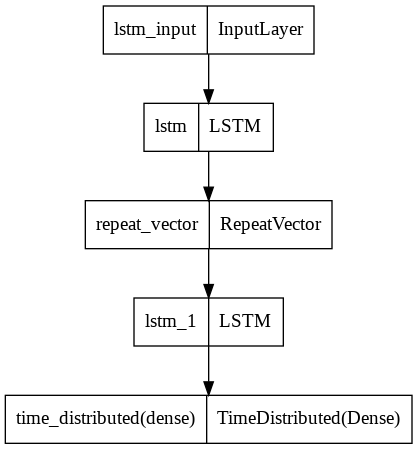

In [29]:
tf.keras.utils.plot_model(model_xxx_dxb)

In [30]:

es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
red_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

def plot_model_learning(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [31]:
N_SAMPLE = 20
_Y_val_xxx_dxb = np.zeros((X_val_xxx_dxb.shape[0],n_lookup))

for samples in tqdm(range(N_SAMPLE)):
    tf.keras.backend.clear_session()
    
    model_xxx_dxb.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.02), loss= 'mean_squared_error')
    history_tcm = model_xxx_dxb.fit(X_train_xxx_dxb, Y_train_xxx_dxb, 
                                validation_data = (X_val_xxx_dxb, Y_val_xxx_dxb), 
                                epochs=100, 
                                verbose = 0,
                                batch_size = 16, 
                                callbacks=[es, red_lr])
    
  
    _Y_val_xxx_dxb += model_xxx_dxb.predict(X_val_xxx_dxb).reshape(-1,n_lookup)

_Y_val_xxx_dxb = _Y_val_xxx_dxb / N_SAMPLE

  0%|          | 0/20 [00:00<?, ?it/s]

1/1 [==============================] - 1s 603ms/step


In [ ]:
#_Y_val_xxx_dxb = model_xxx_dxb.predict(X_val_xxx_dxb)

1/1 [==============================] - 1s 857ms/step


In [32]:
df_val_xxx_dxb.shape

(30, 348)

In [33]:
for n, i in df_val_xxx_dxb.iterrows():
  df_val_xxx_dxb.loc[n,'0':str(last_available_data)] = _Y_val_xxx_dxb[n].reshape(-1)[::-1]

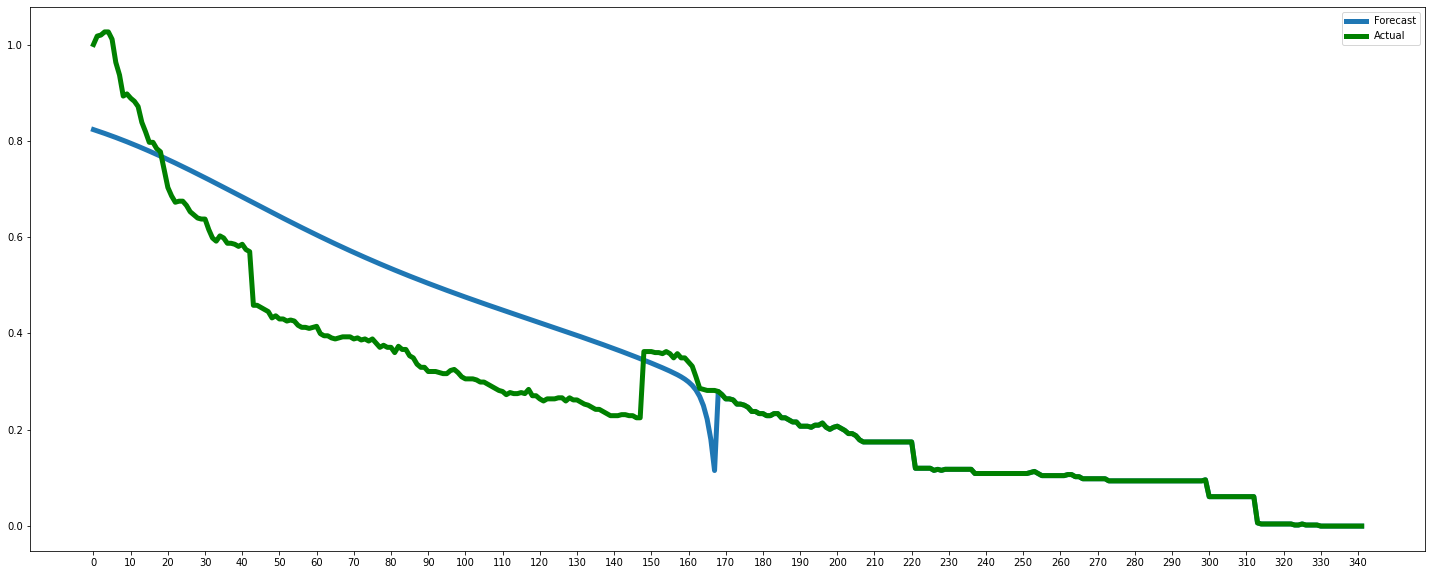

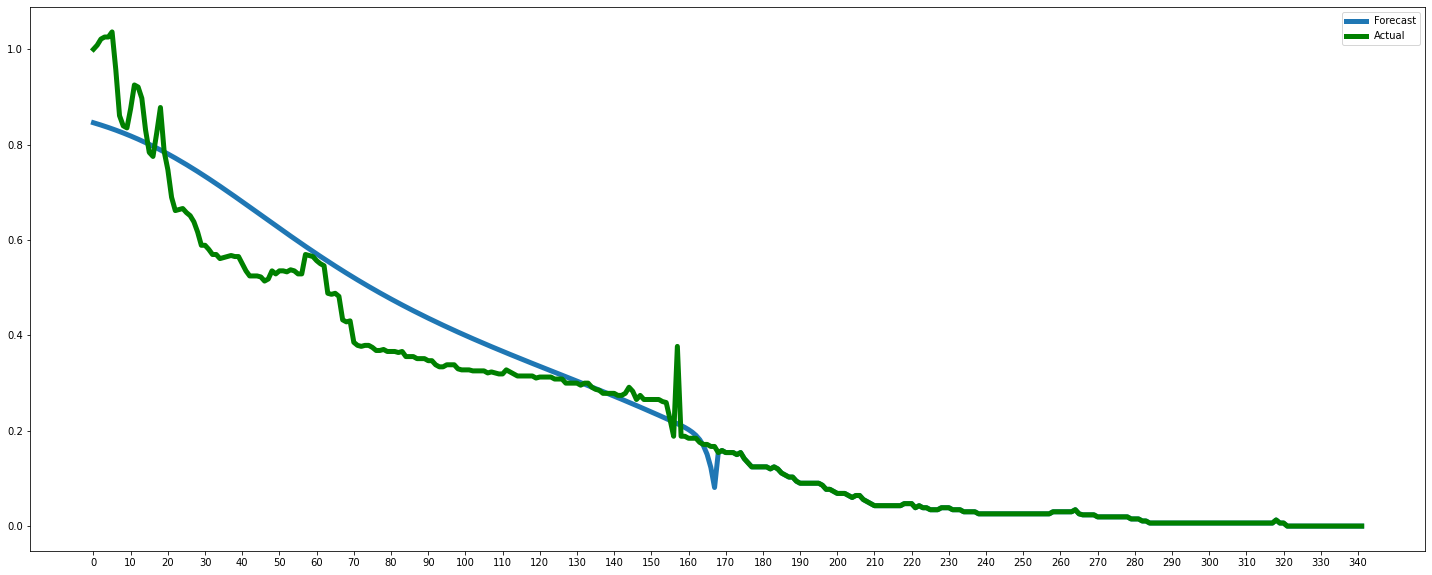

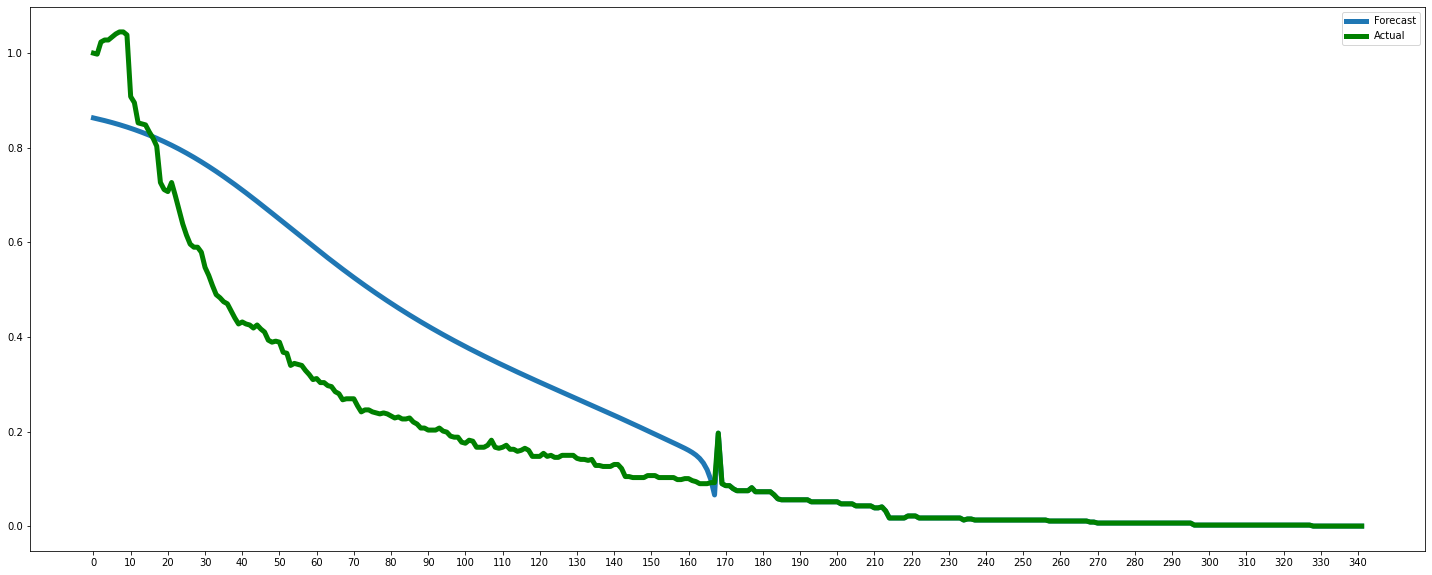

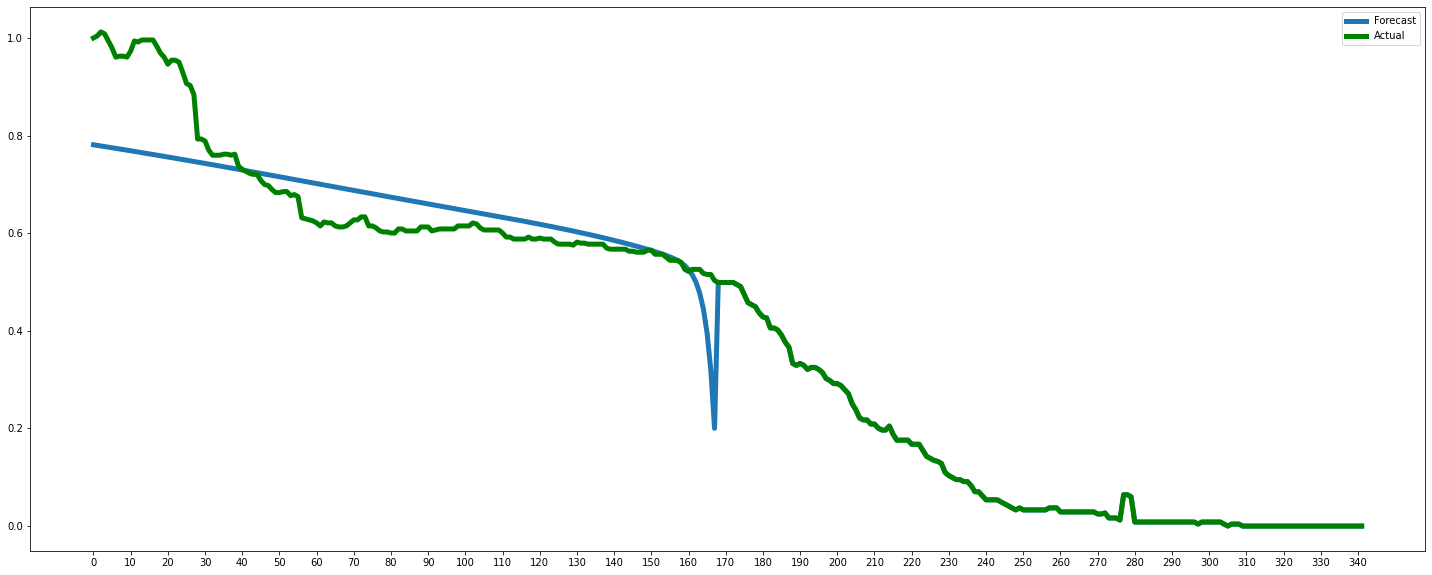

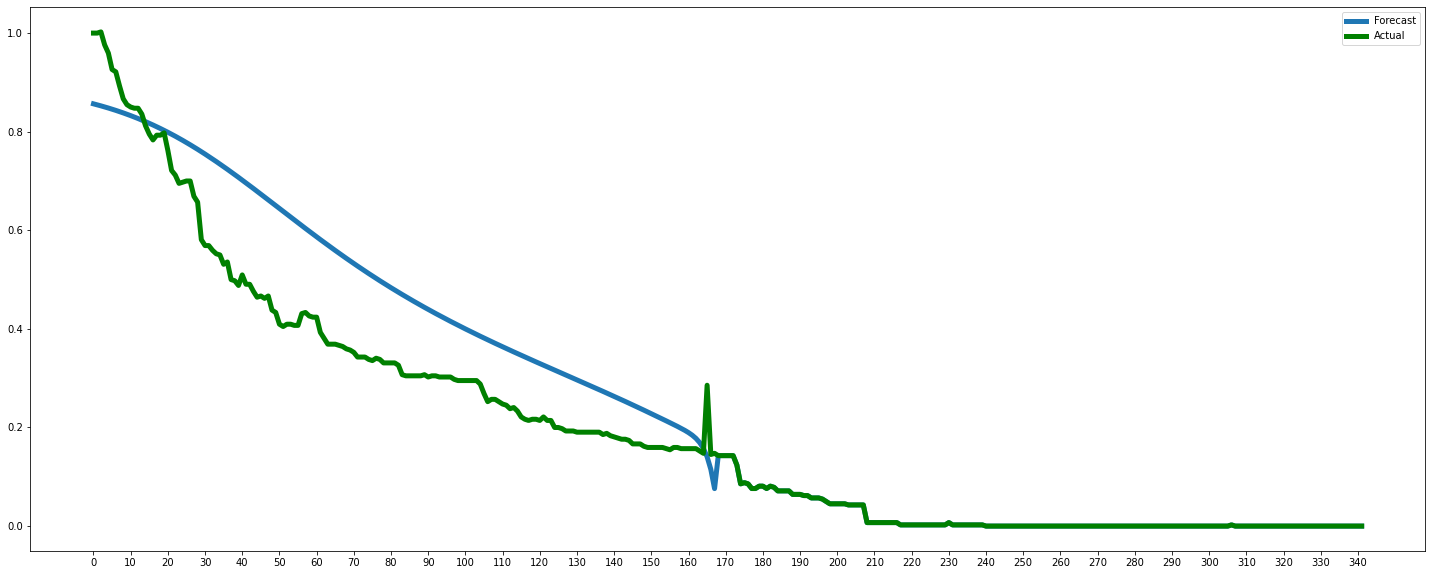

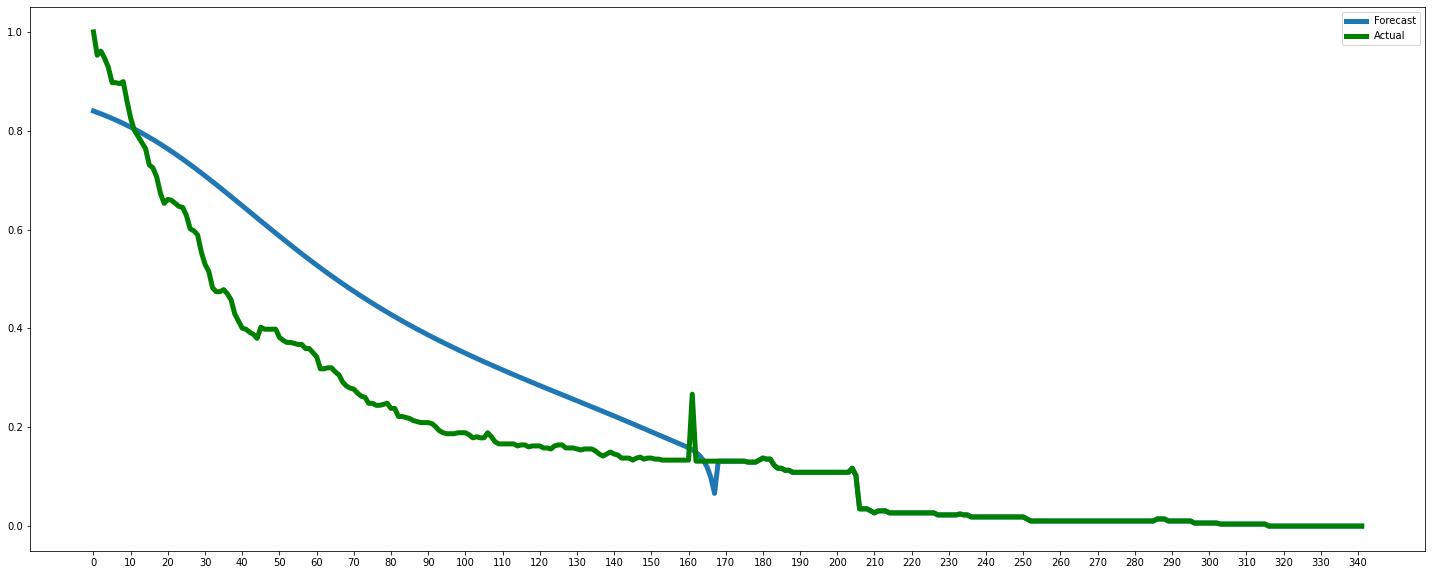

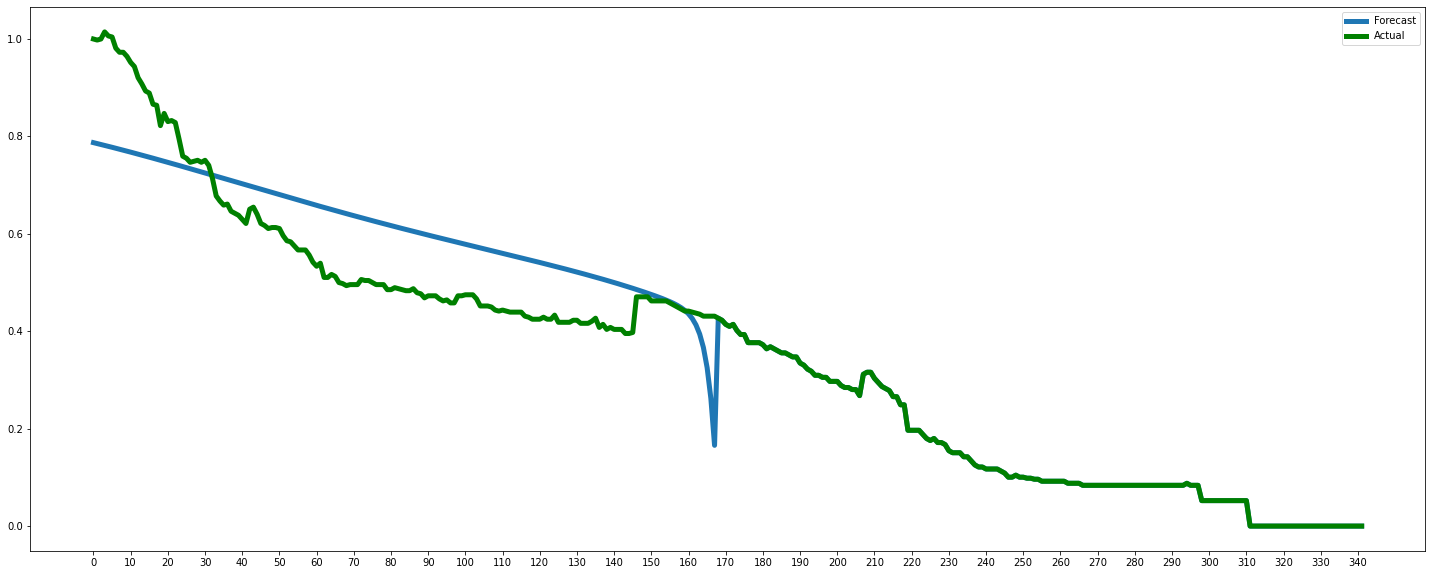

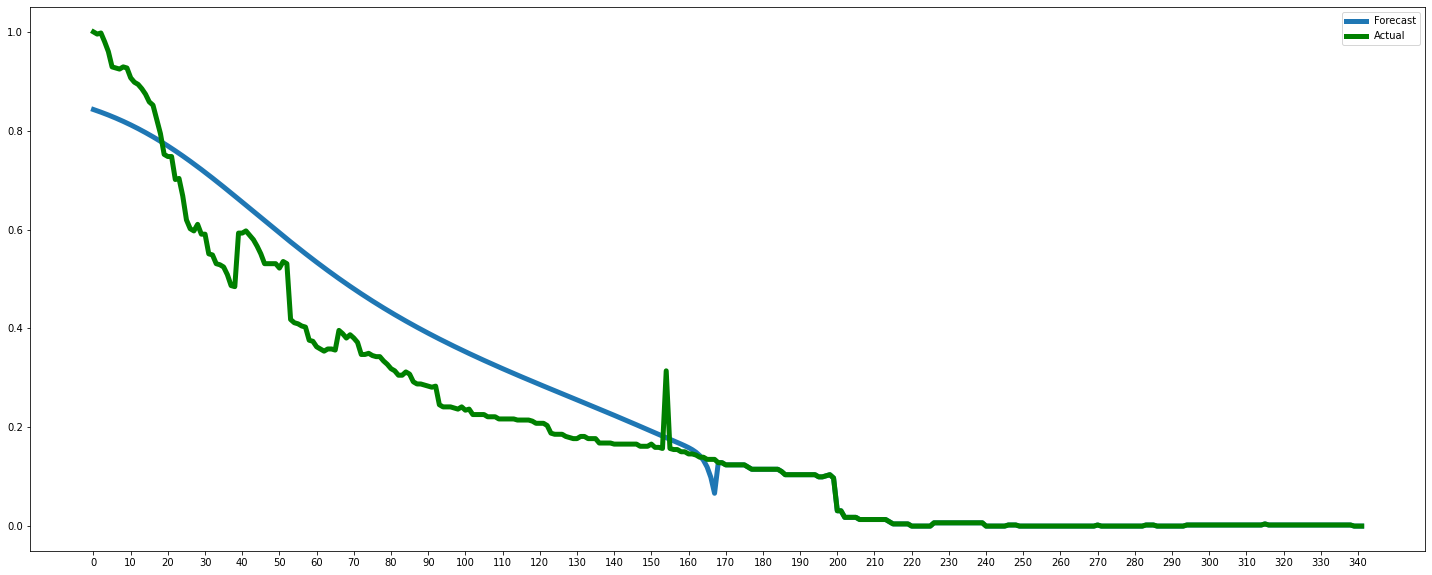

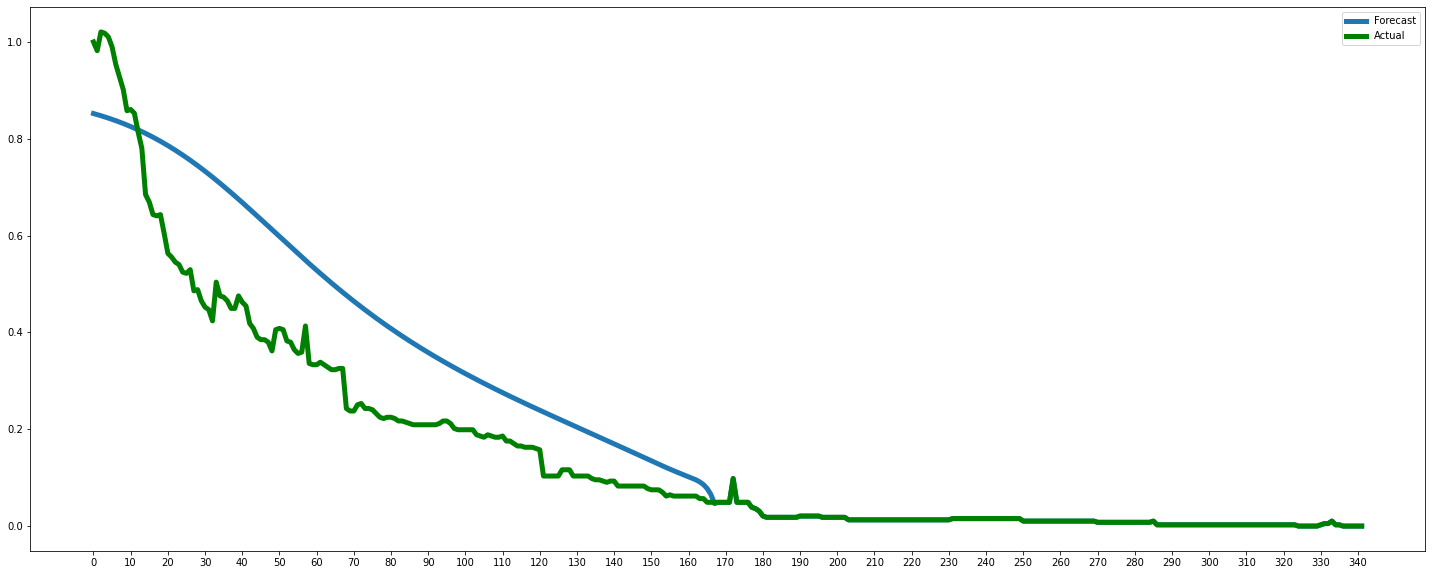

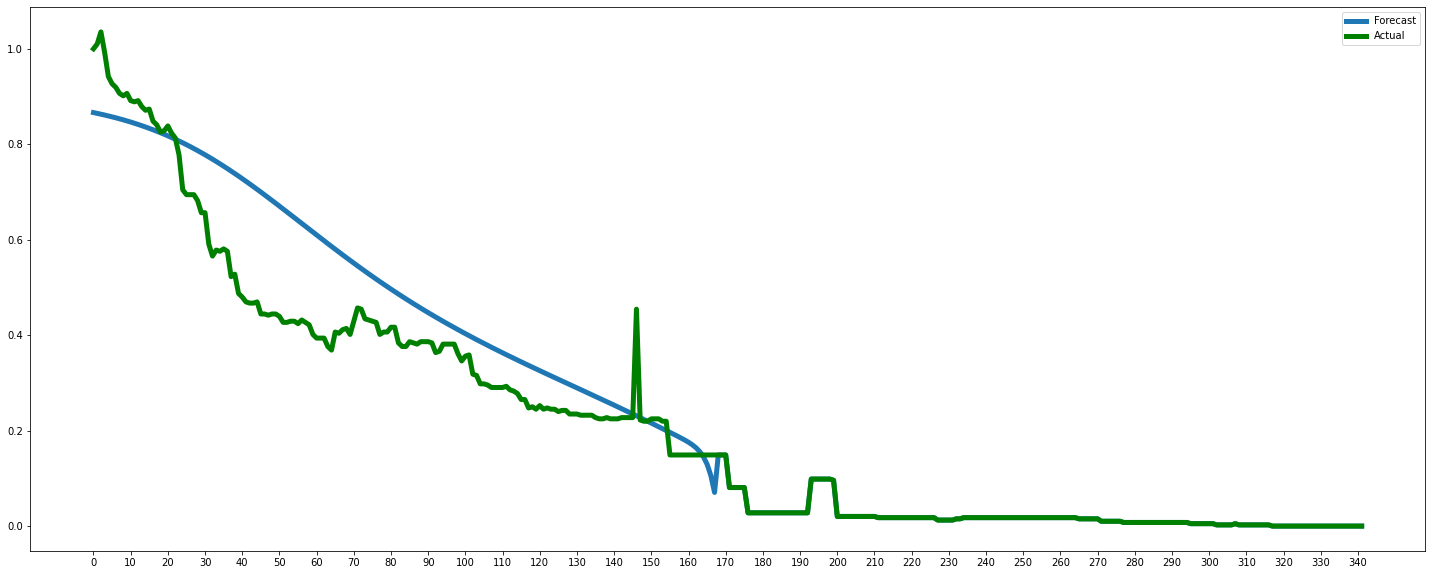

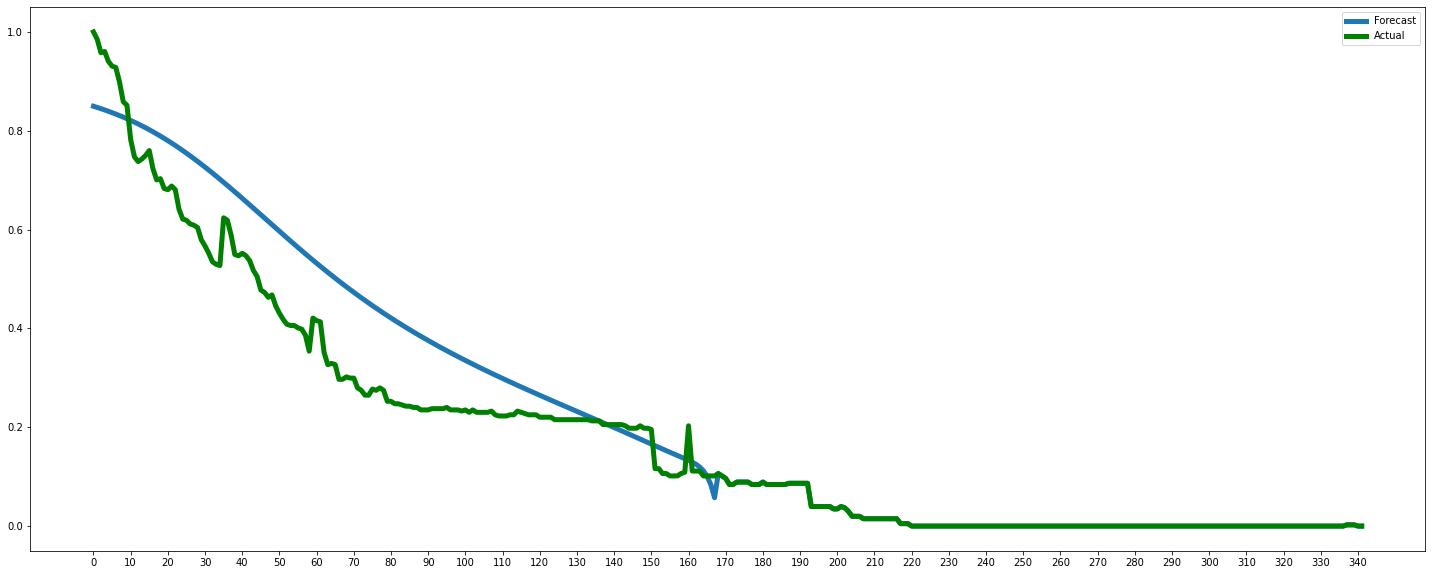

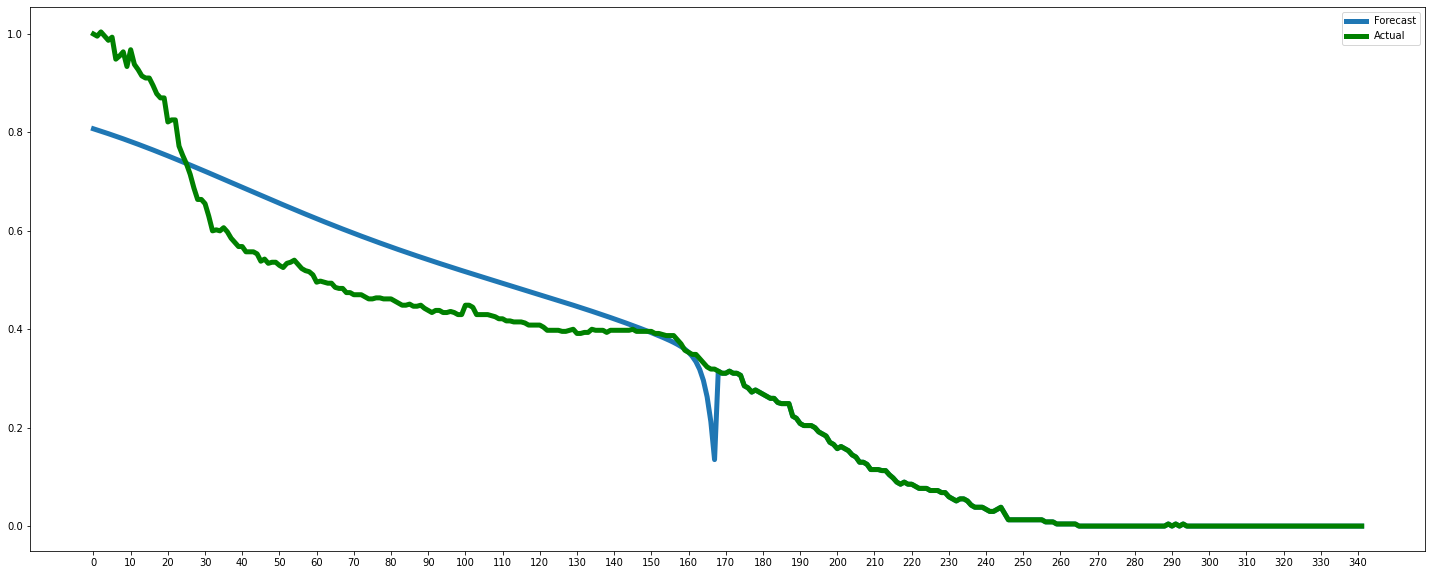

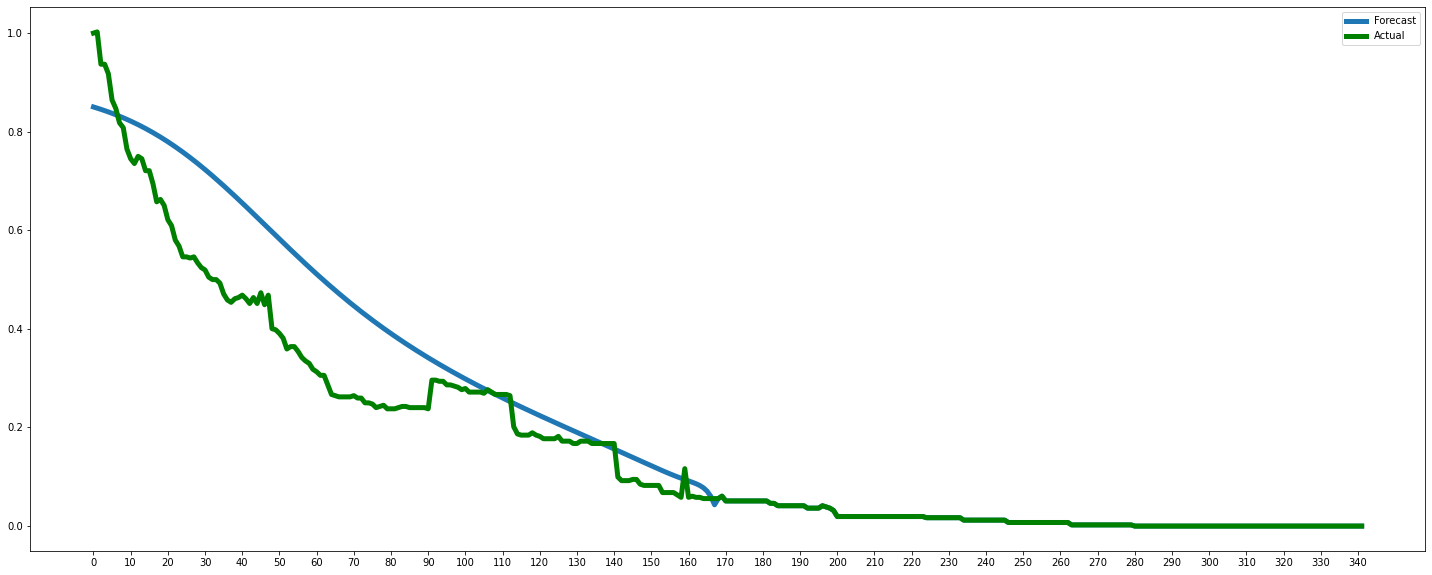

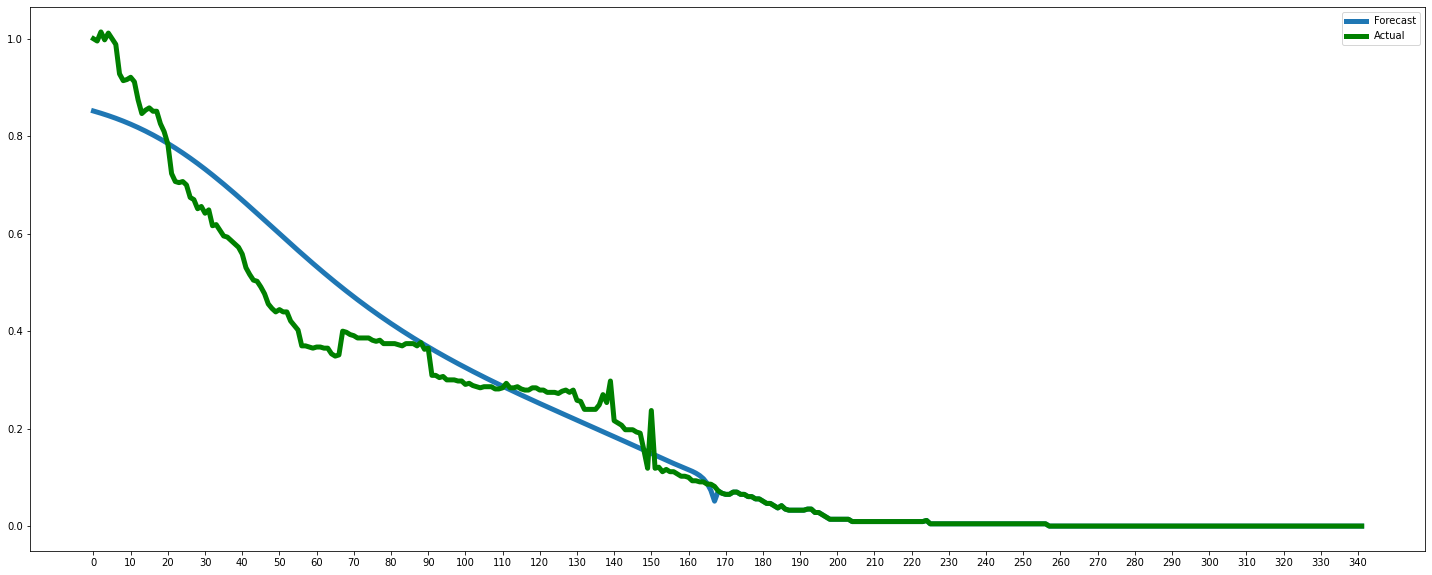

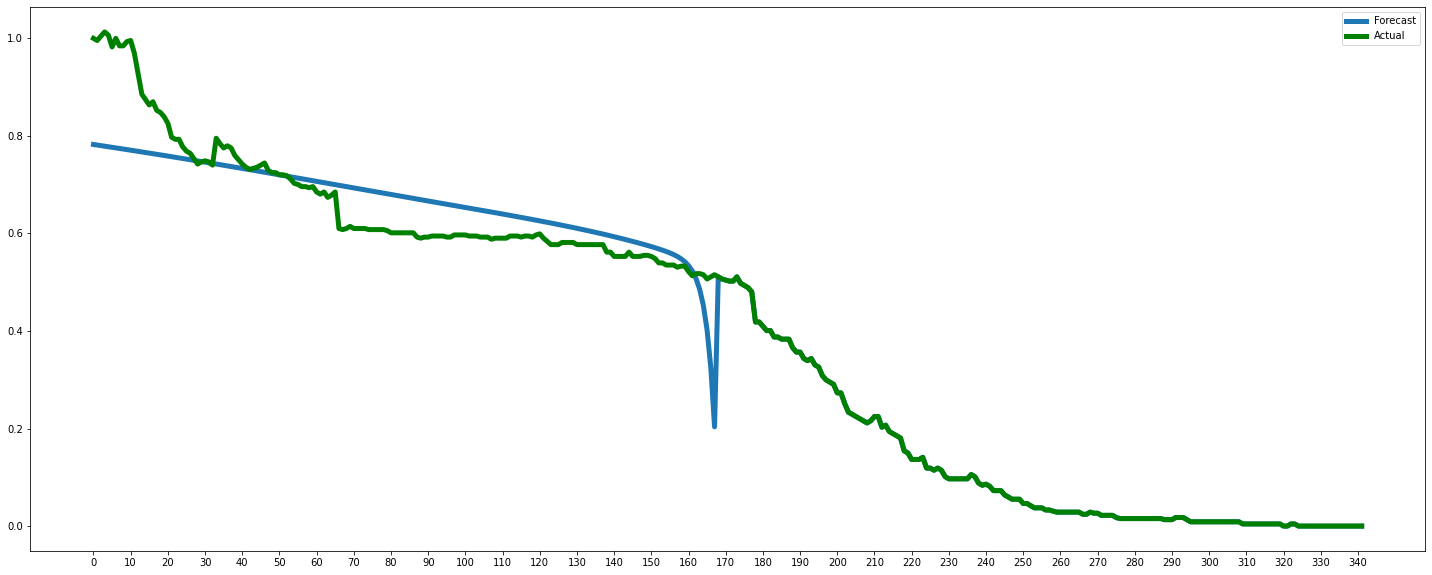

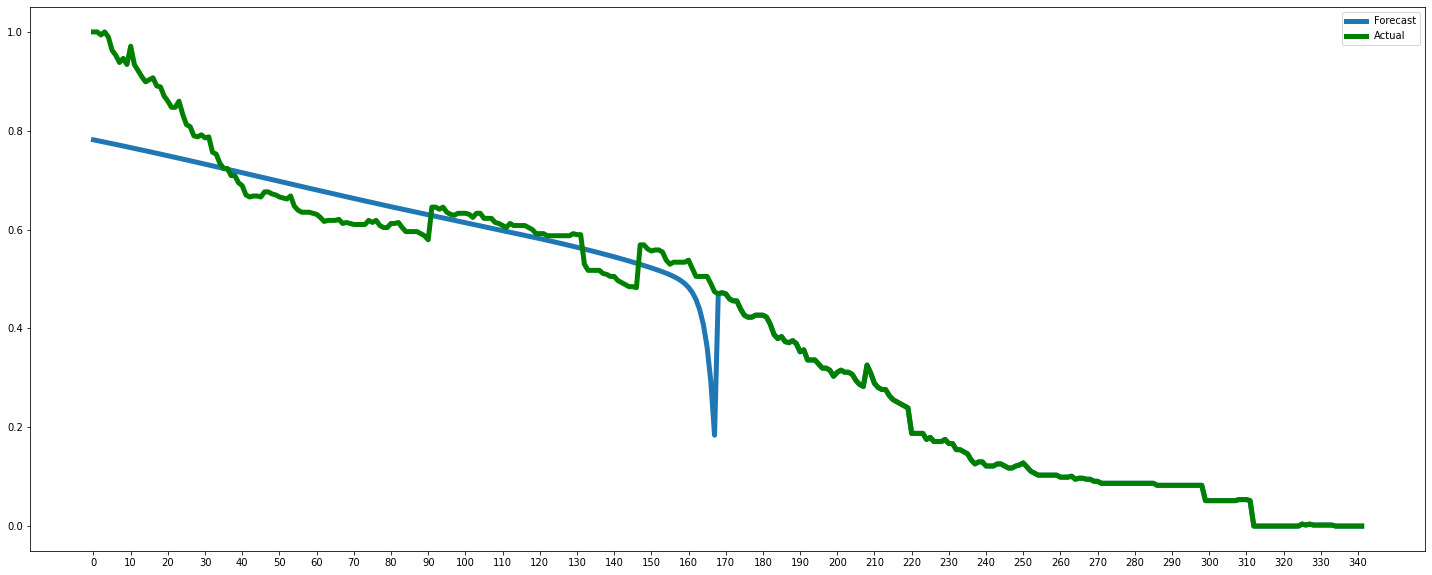

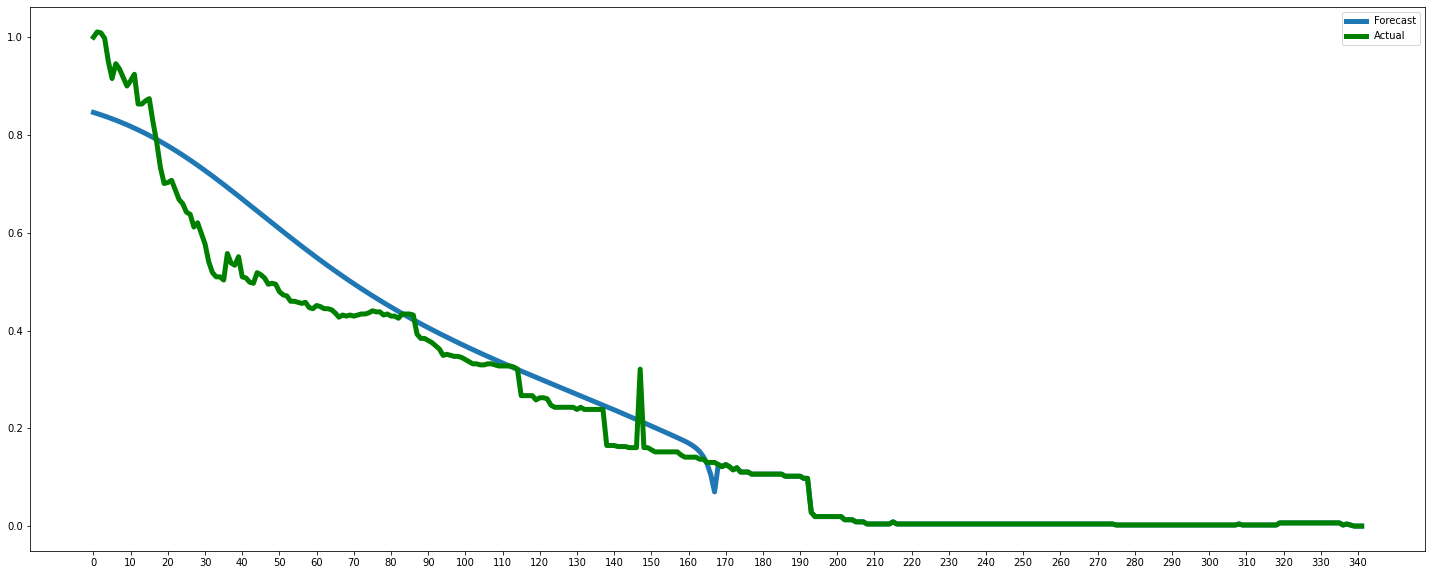

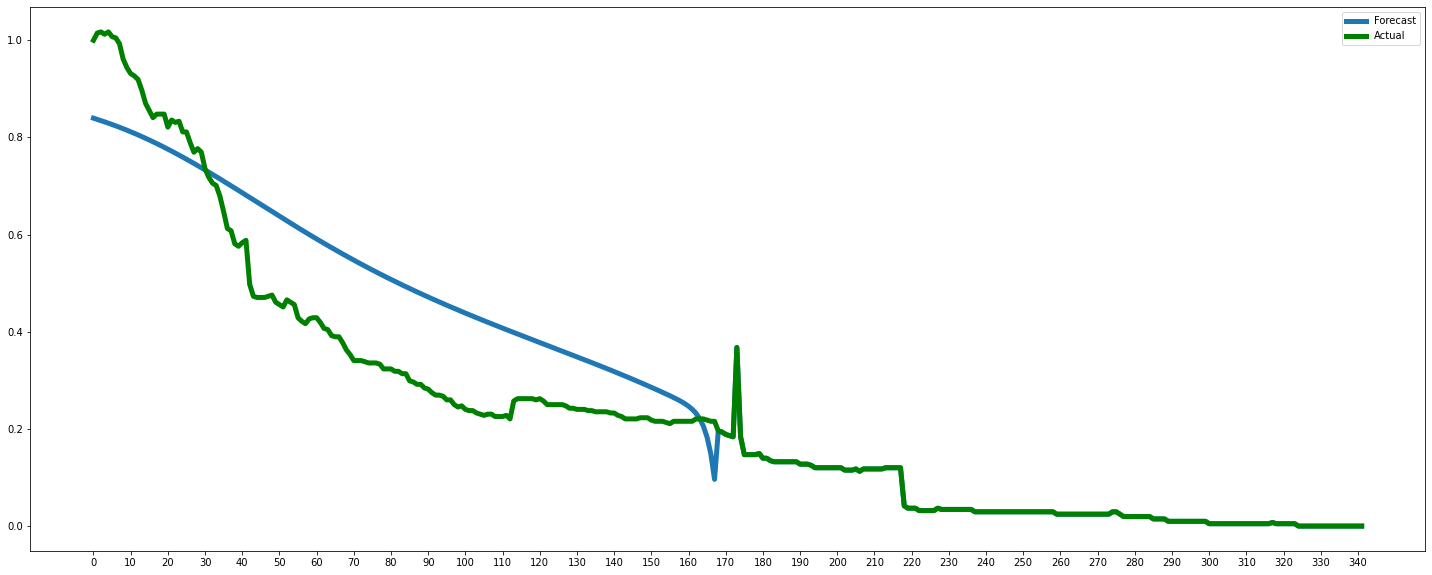

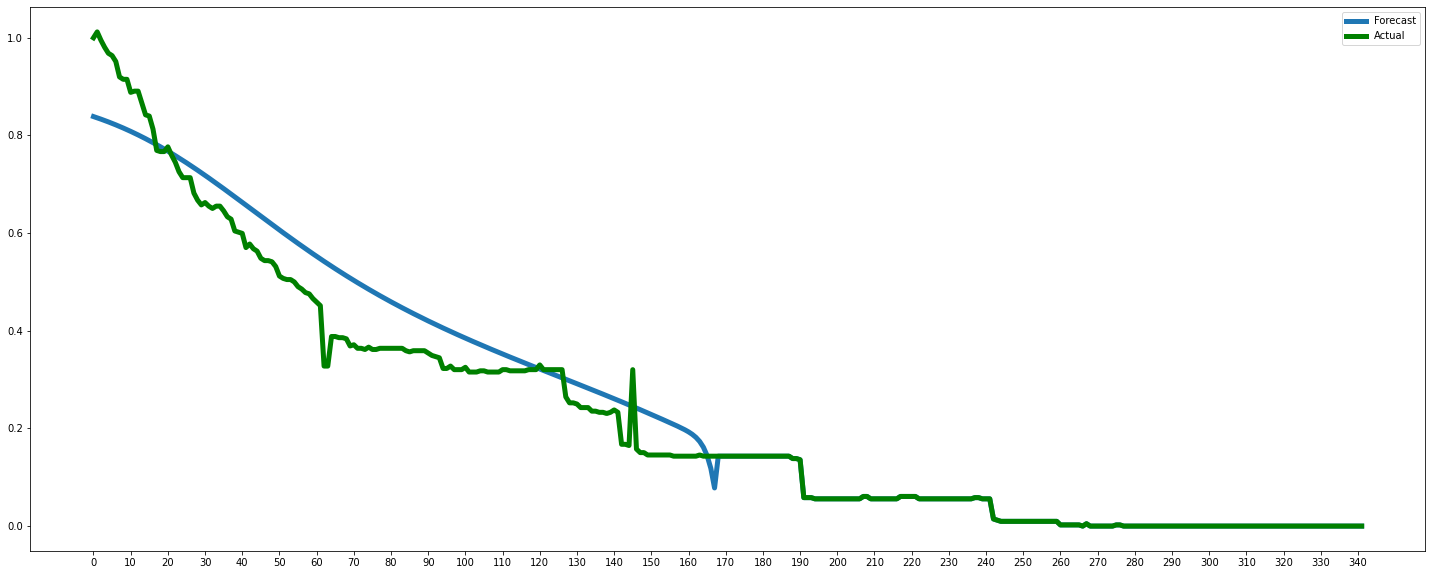

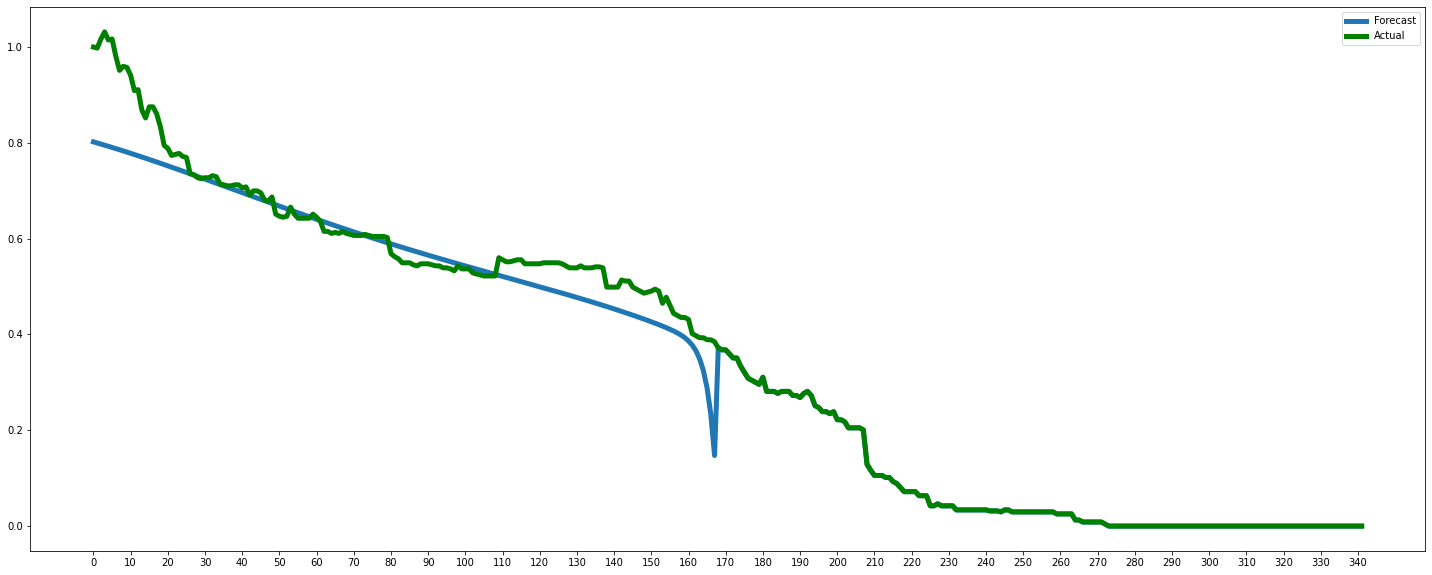

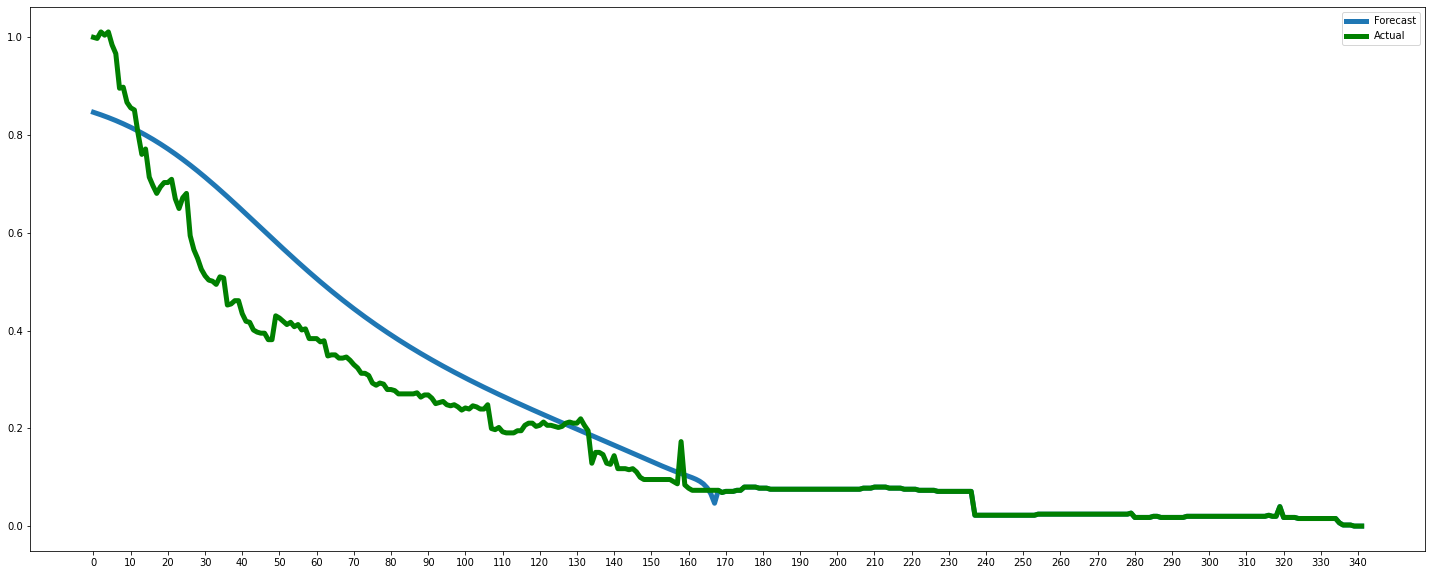

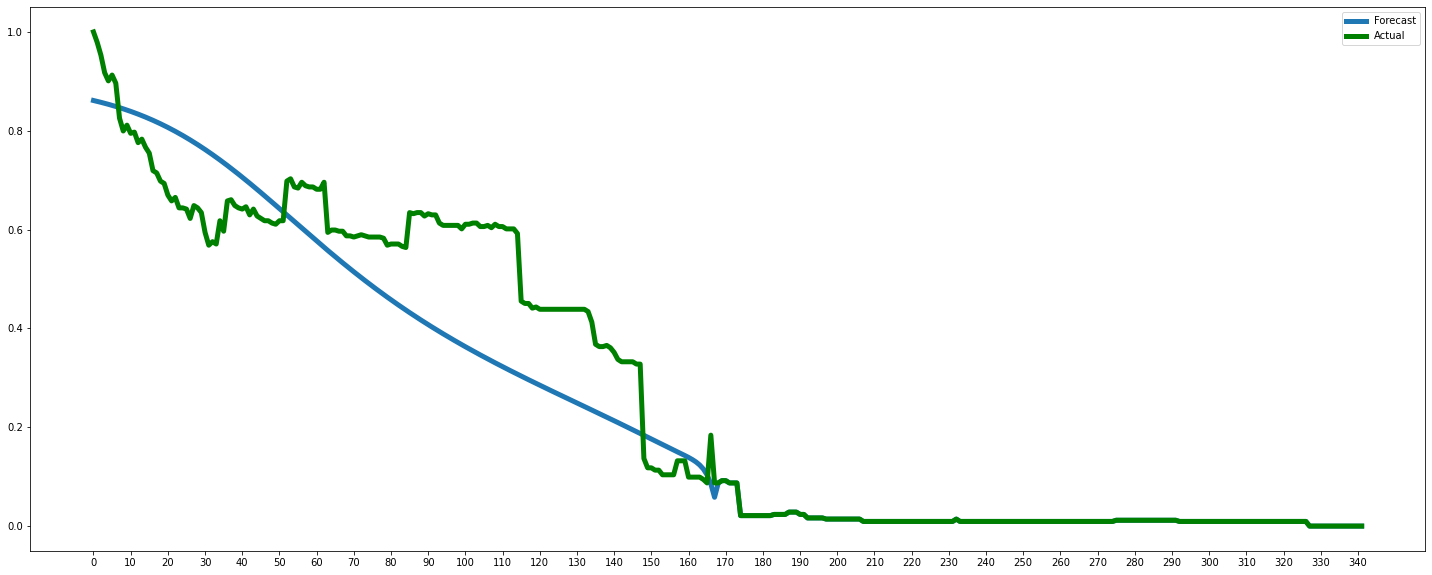

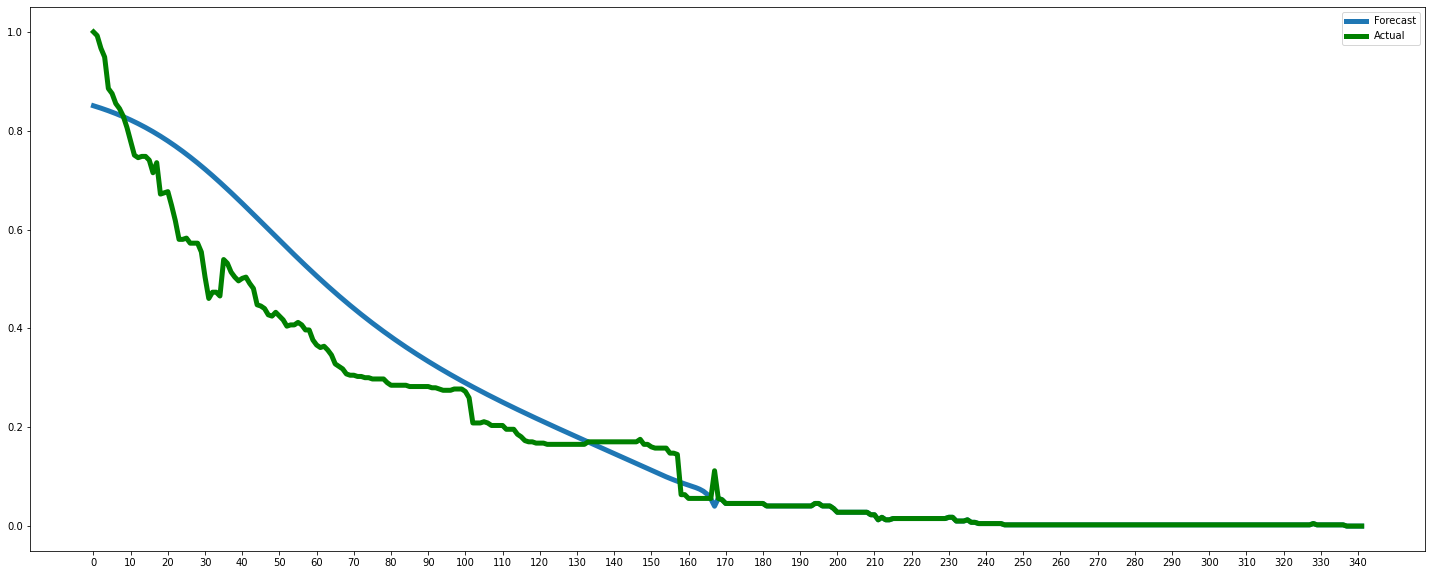

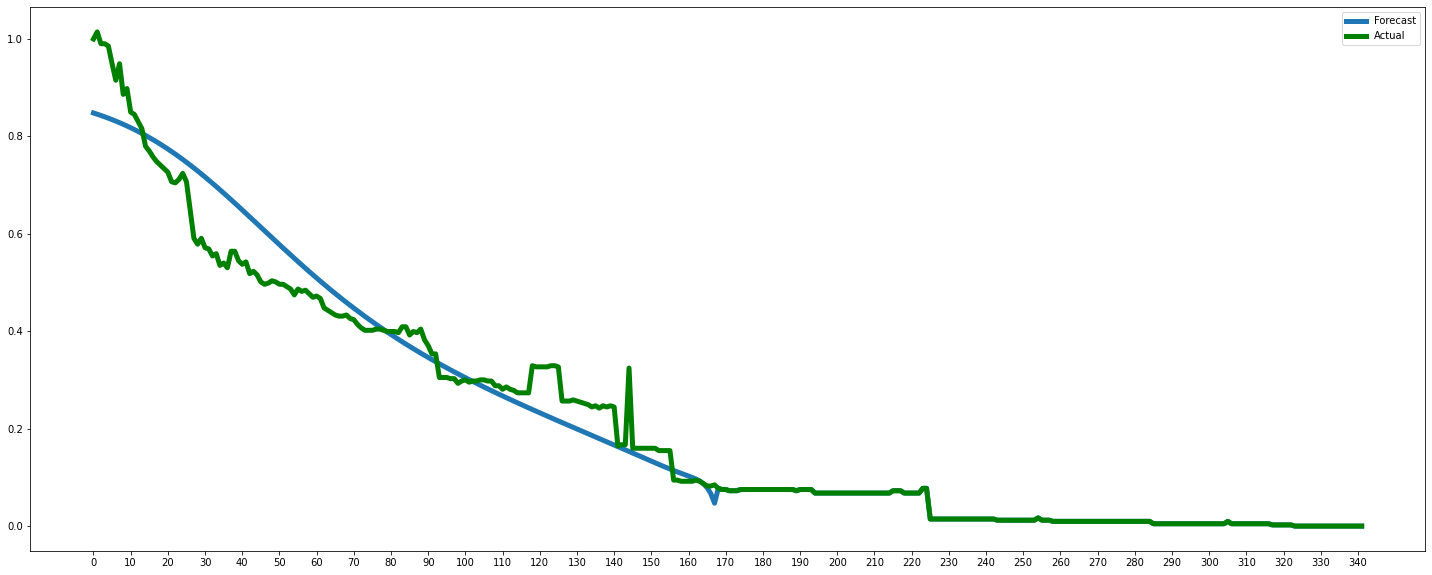

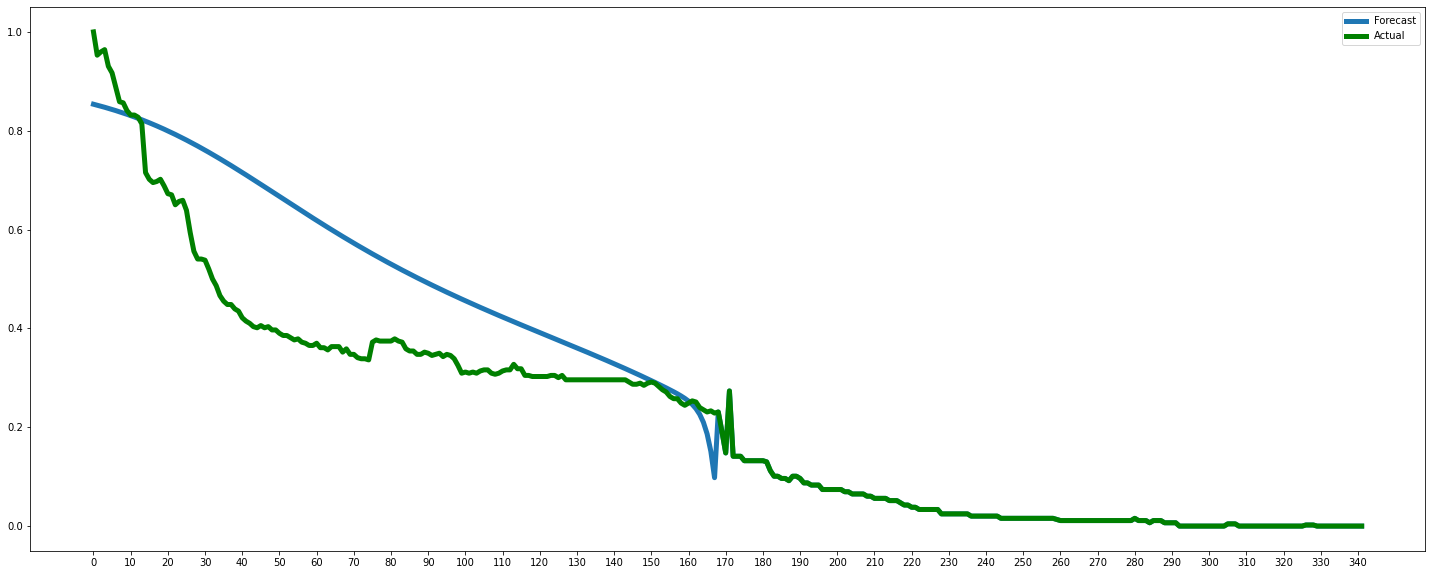

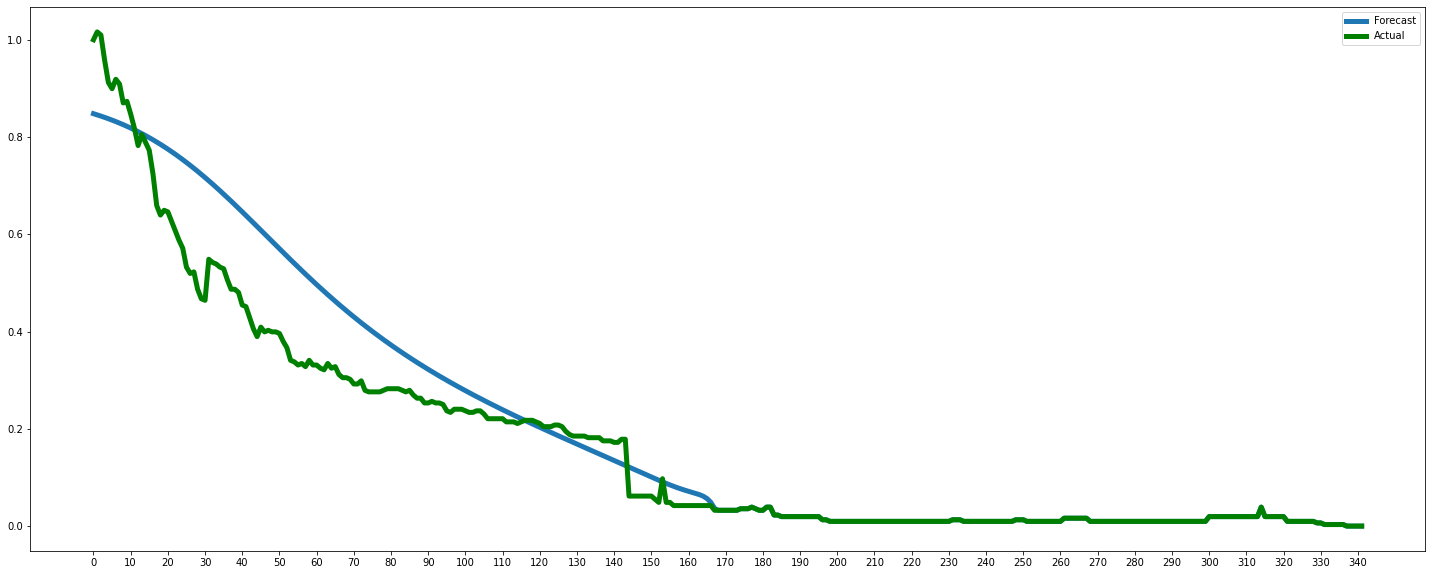

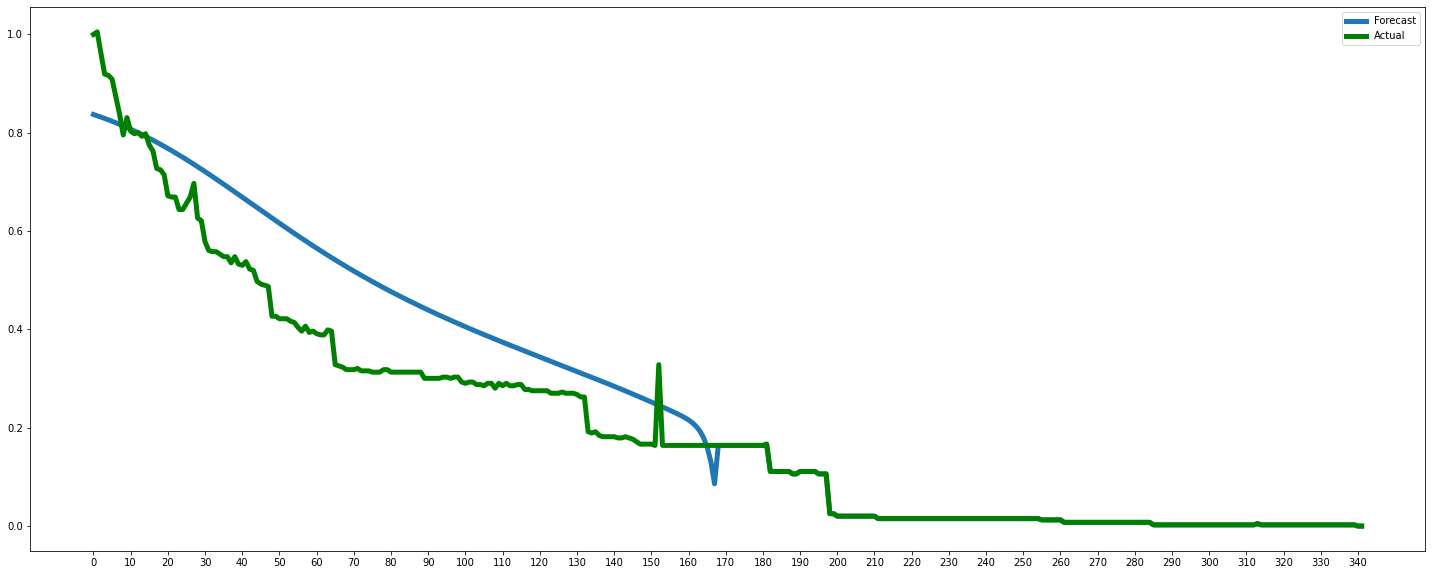

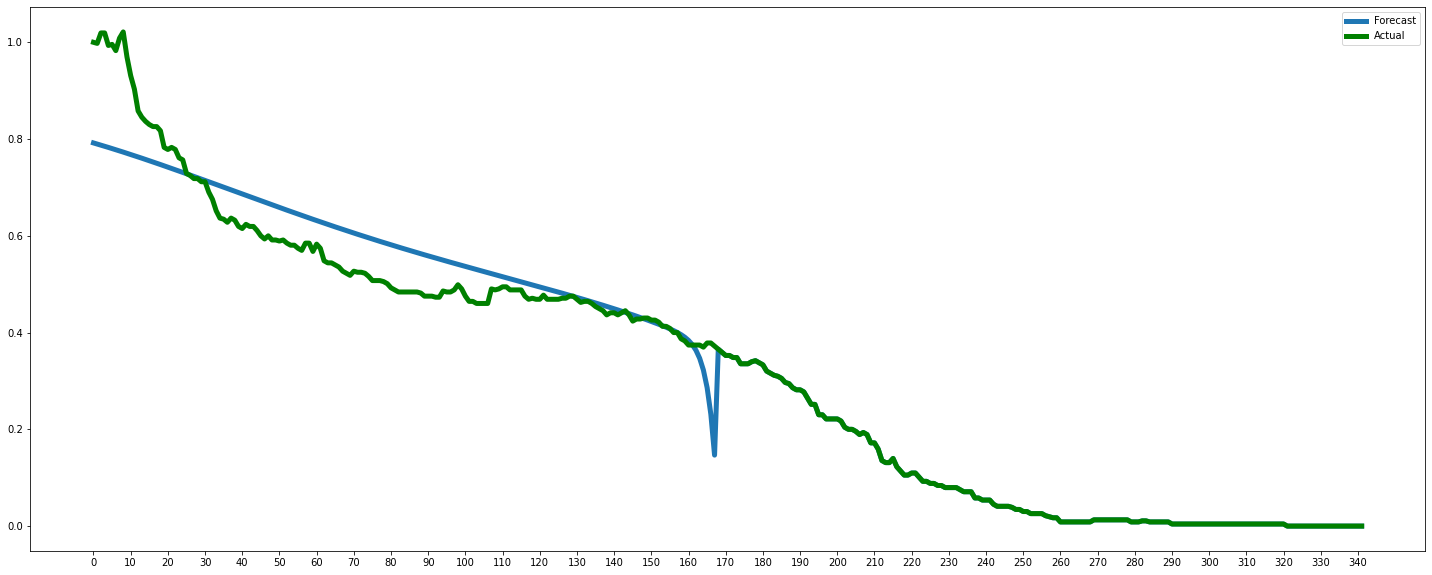

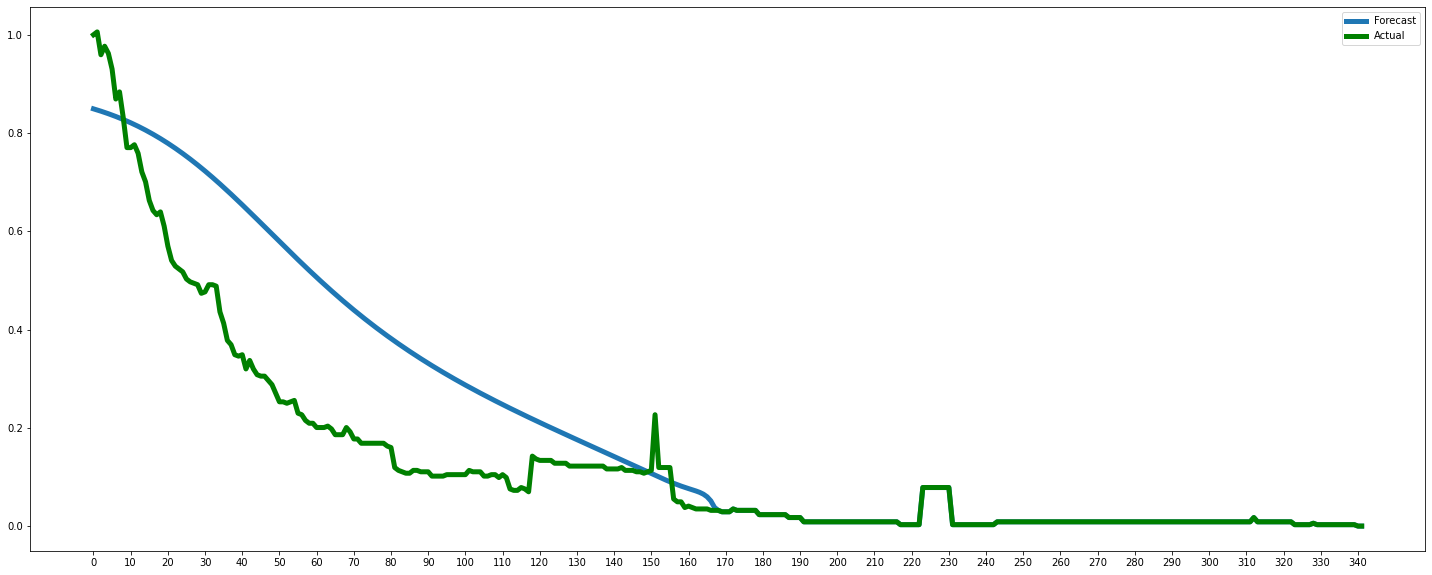

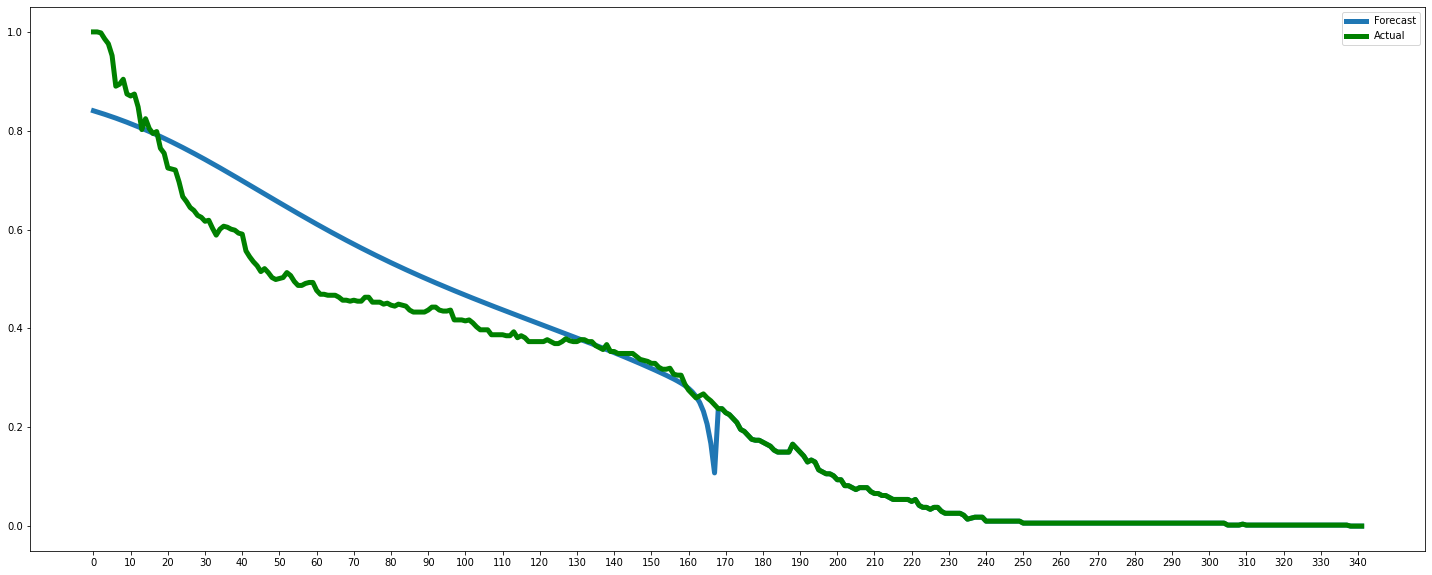

In [34]:
for v in range(df_val_xxx_dxb.shape[0]):
  df_val_xxx_dxb.loc[v,'0':str(last_available_data)] = _Y_val_xxx_dxb[v].reshape(-1)[::-1]
  rmse = sqrt(mean_squared_error(_df_val_xxx_dxb.loc[v,'0':'341'].values, df_val_xxx_dxb.loc[v,'0':'341'].values))
  df_val_xxx_dxb.loc[v,'RMSE']=rmse
  plt.figure(figsize=[25,10])
  plt.plot(df_val_xxx_dxb.loc[v,'0':'341'],  linestyle='-',linewidth=5, label='Forecast')
  plt.plot(_df_val_xxx_dxb.loc[v,'0':'341'],color='green',  linestyle='-',linewidth=5, label='Actual')
  plt.legend(loc='best')
  plt.xticks(np.arange(0, 342, 10))
  plt.show()

In [35]:
df_val_xxx_dxb['RMSE'].mean()

0.08037976761114354

In [36]:
val_seq2seq_forecast = df_val_dxb_xxx.append(df_val_xxx_dxb)

In [37]:
val_seq2seq_forecast.to_csv('val_seq2seq_forecast_raw.csv',index=False)

###Comparing Curve fit and Seq2Seq models

In [38]:
df_val_curve_forecasted = pd.read_csv('val_curve_forecast_raw.csv')
df_val_seq2seq_forecasted = pd.read_csv('val_seq2seq_forecast_raw.csv')

In [39]:
df_val_curve_forecasted.columns = df_val_curve_forecasted.columns.map(str)
df_val_seq2seq_forecasted.columns = df_val_seq2seq_forecasted.columns.map(str)

In [40]:
df_val_curve_f_dxb_xxx = df_val_curve_forecasted[df_val_curve_forecasted['Origin_Destination']=='DXB-XXX']
df_val_curve_f_xxx_dxb = df_val_curve_forecasted[df_val_curve_forecasted['Origin_Destination']=='XXX-DXB']

df_val_seq2seq_f_dxb_xxx = df_val_seq2seq_forecasted[df_val_seq2seq_forecasted['Origin_Destination']=='DXB-XXX']
df_val_seq2seq_f_xxx_dxb = df_val_seq2seq_forecasted[df_val_seq2seq_forecasted['Origin_Destination']=='XXX-DXB']

df_val_curve_f_dxb_xxx.reset_index(drop=True, inplace=True)
df_val_curve_f_xxx_dxb.reset_index(drop=True, inplace=True)

df_val_seq2seq_f_dxb_xxx.reset_index(drop=True, inplace=True)
df_val_seq2seq_f_xxx_dxb.reset_index(drop=True, inplace=True)

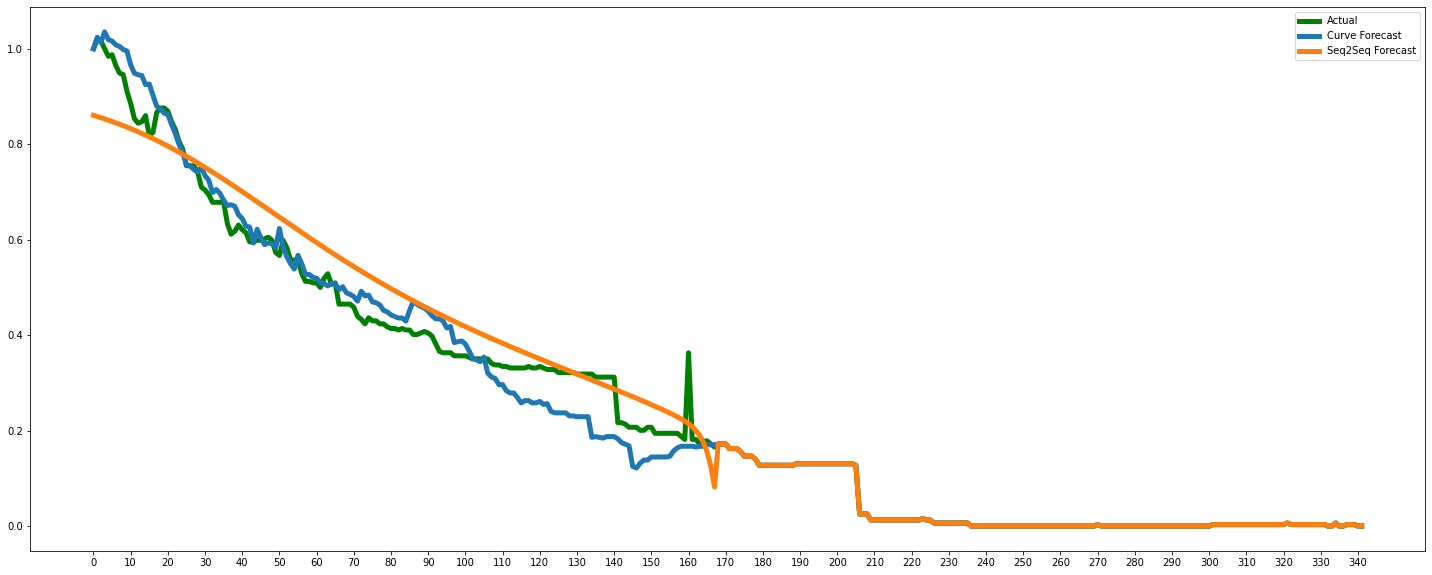

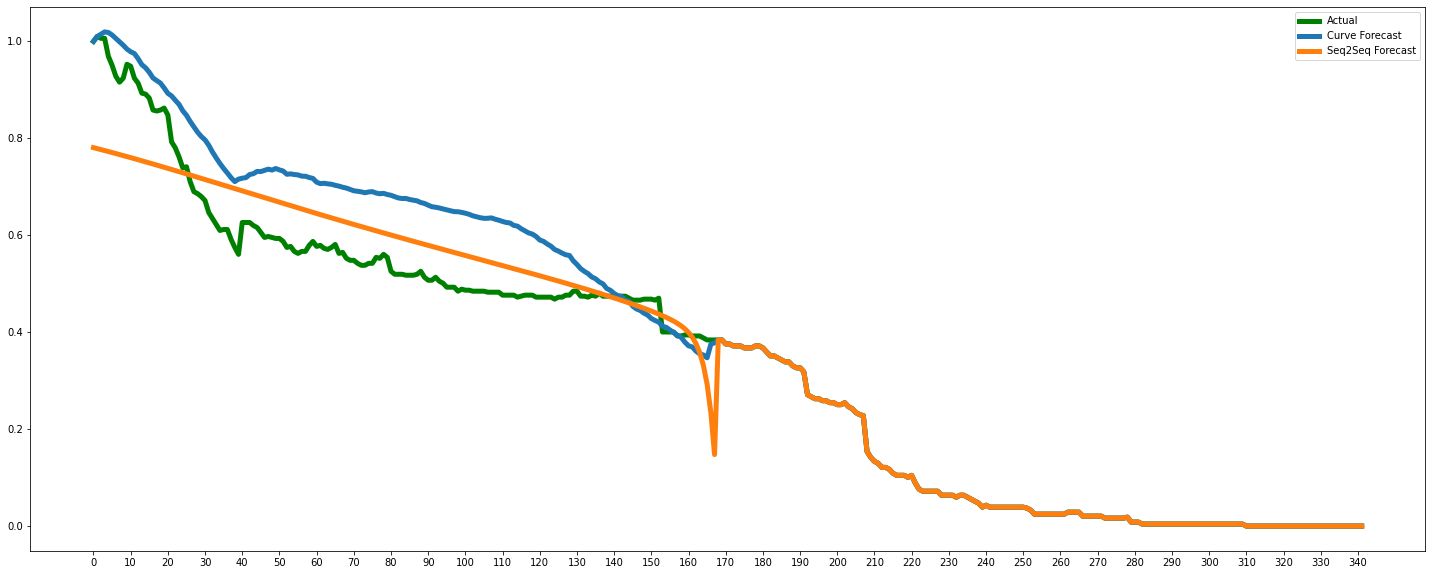

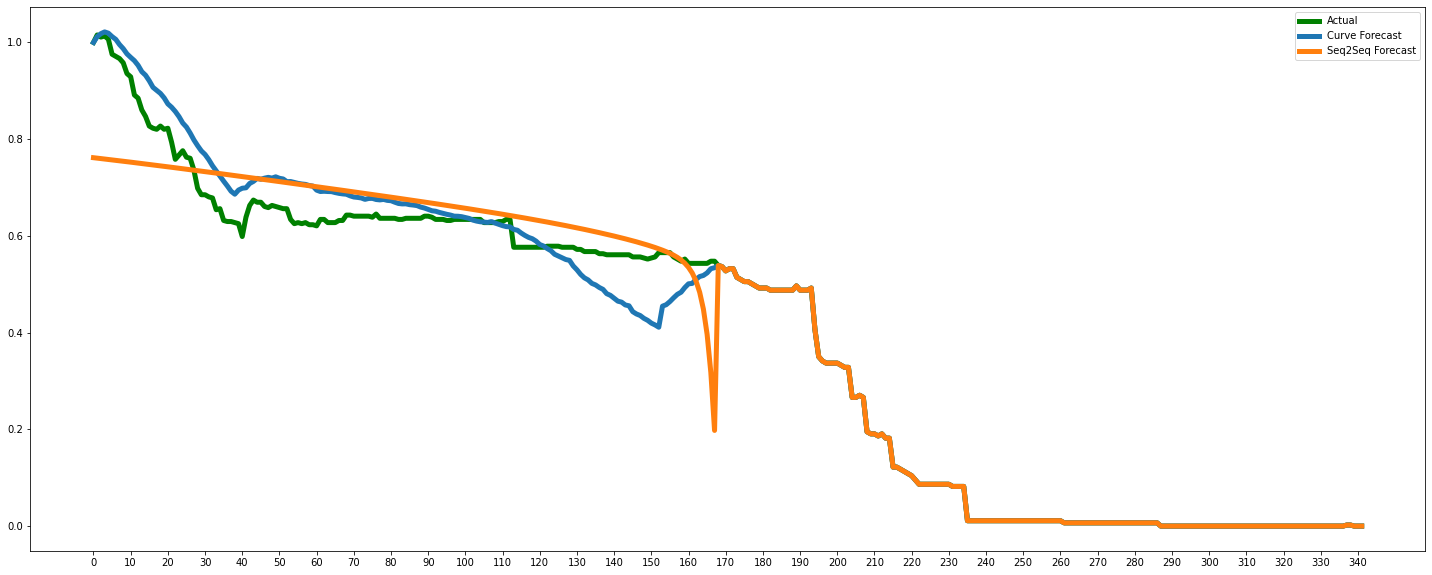

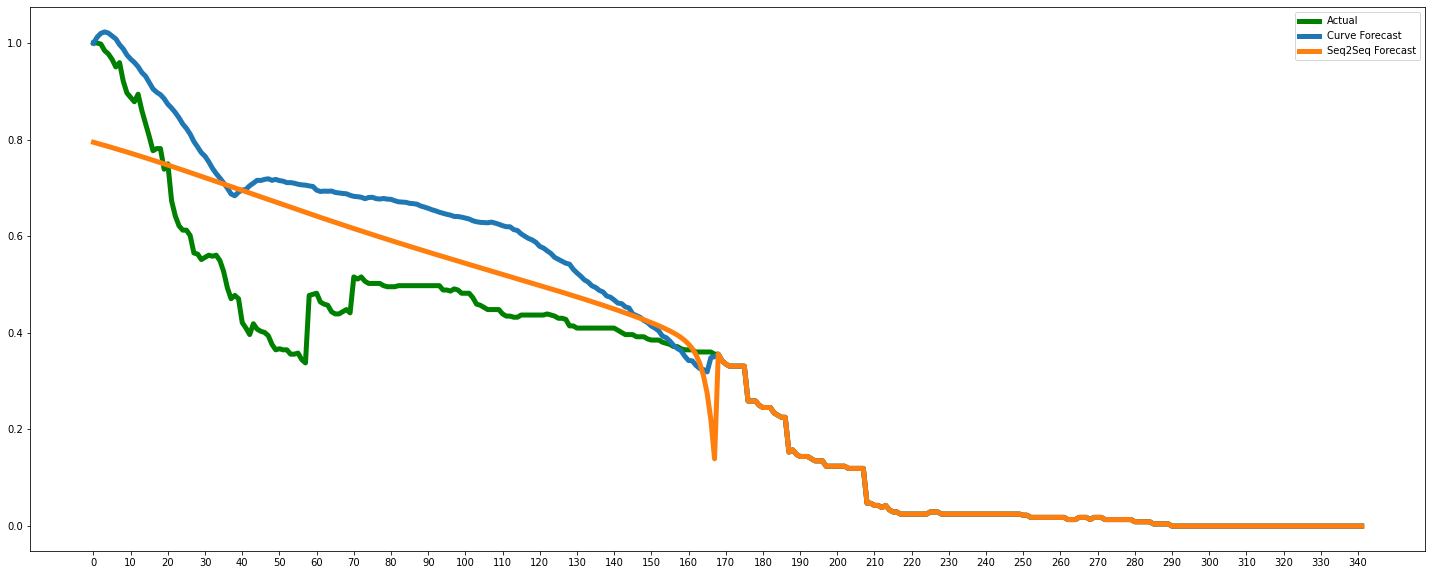

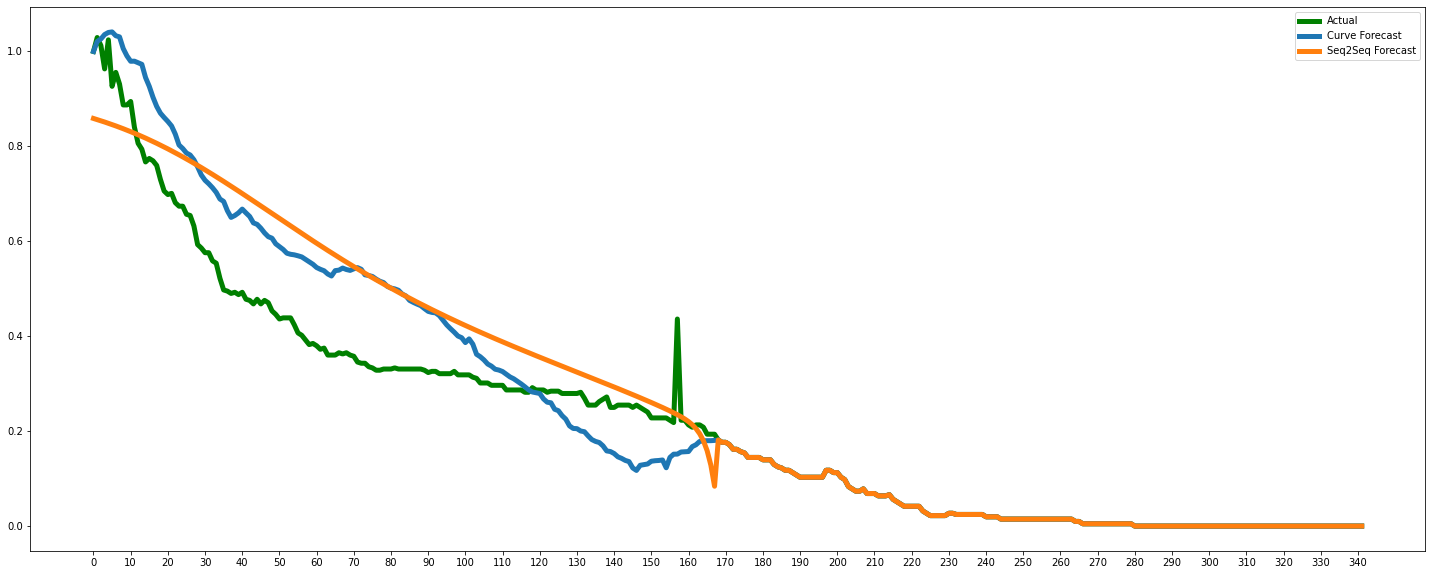

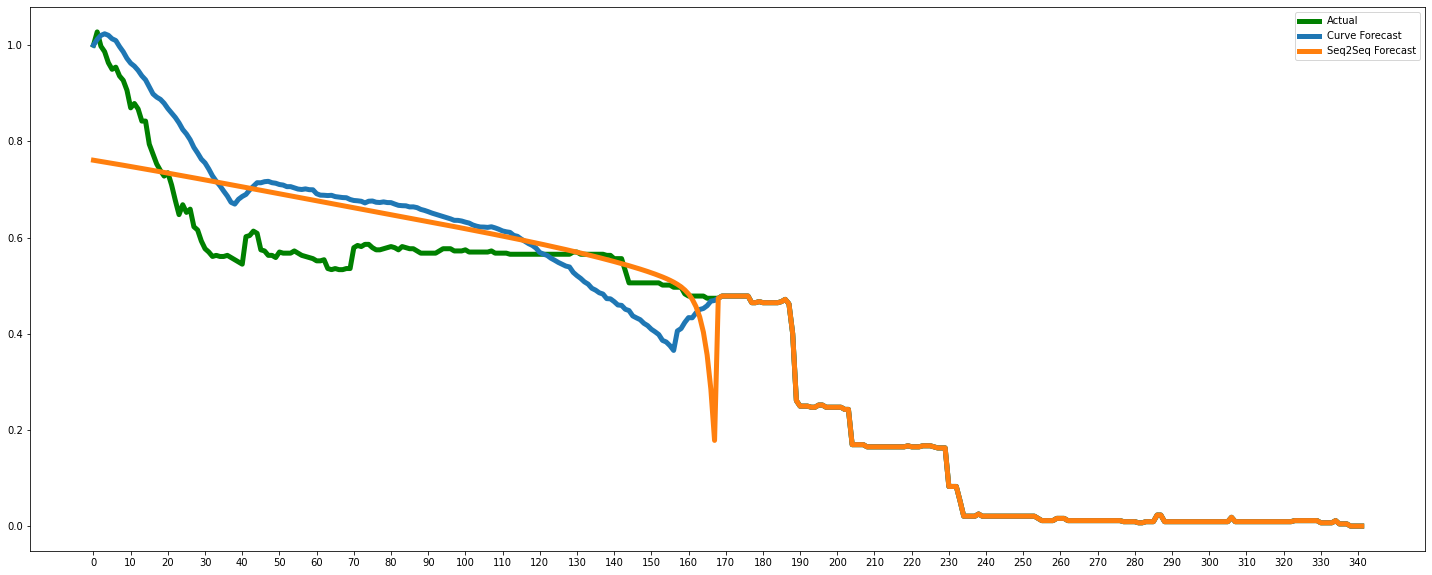

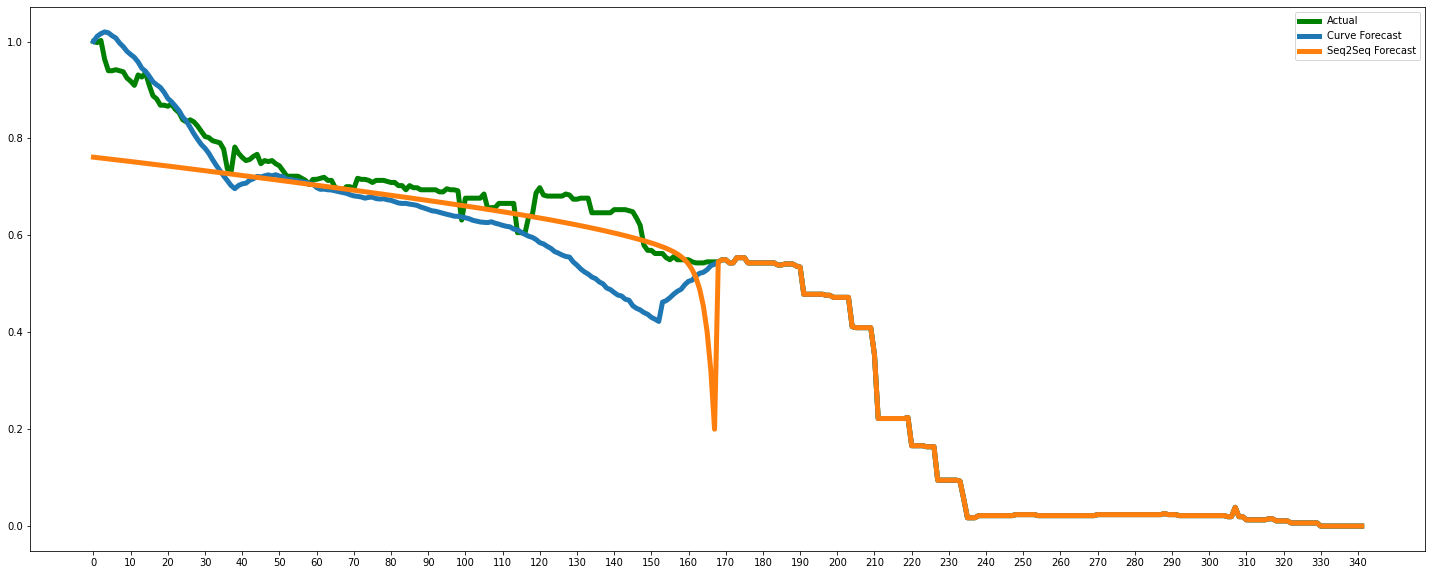

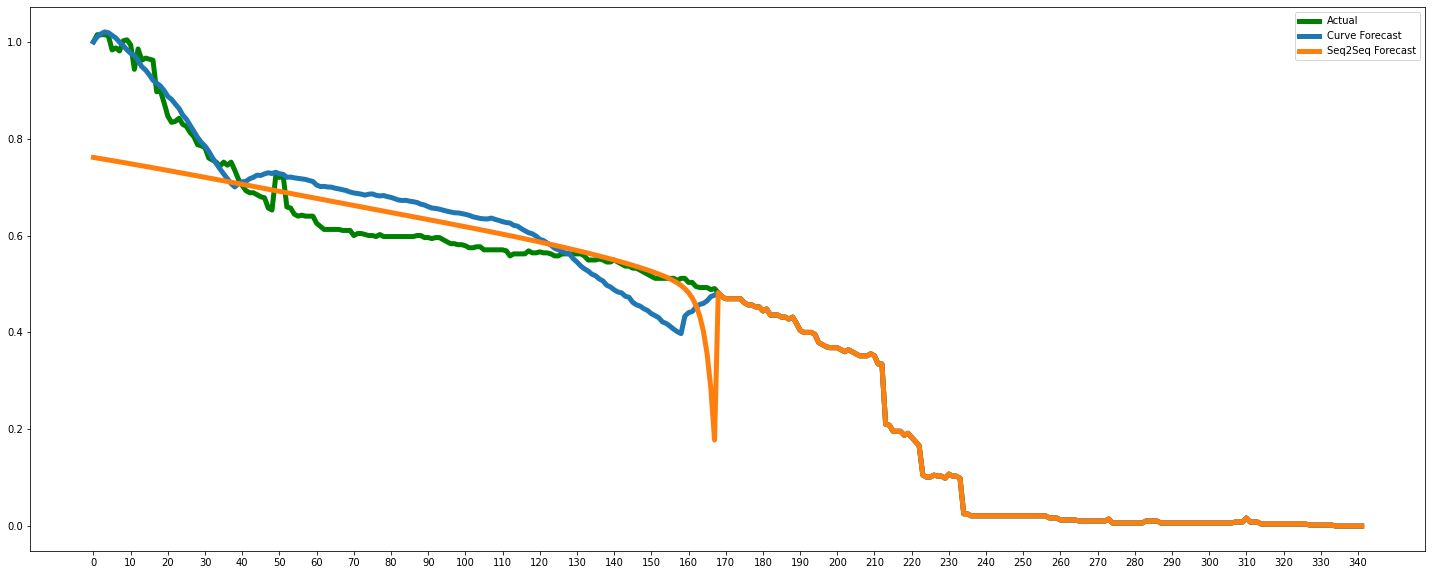

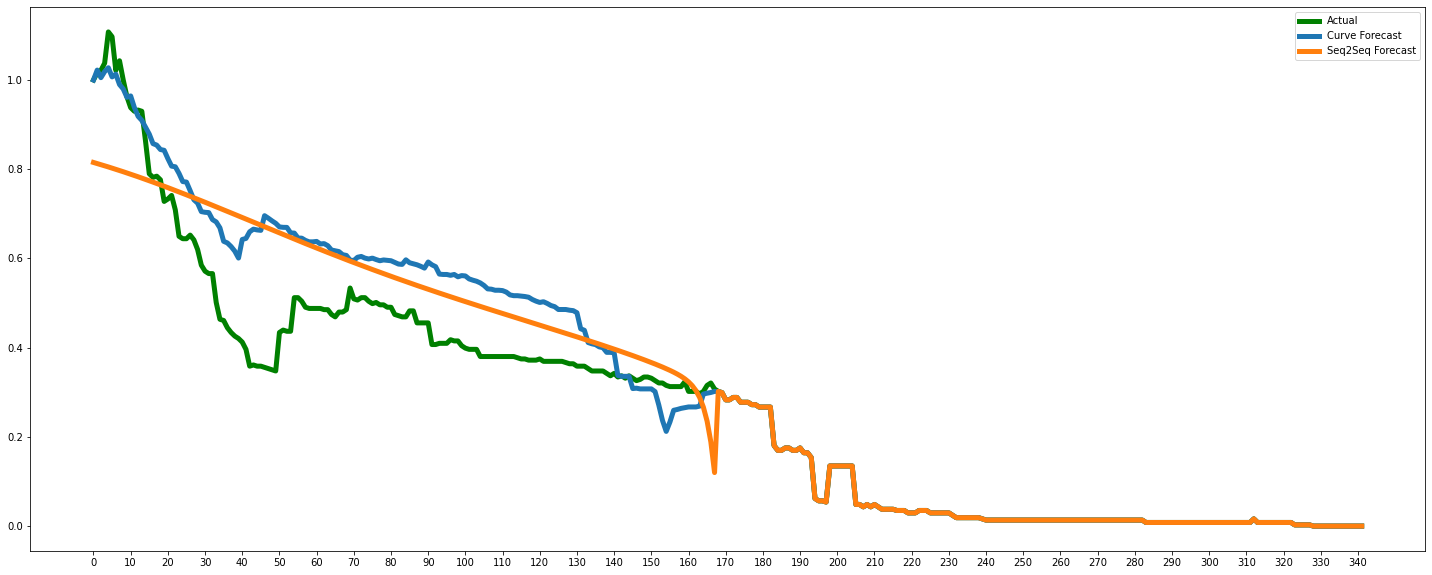

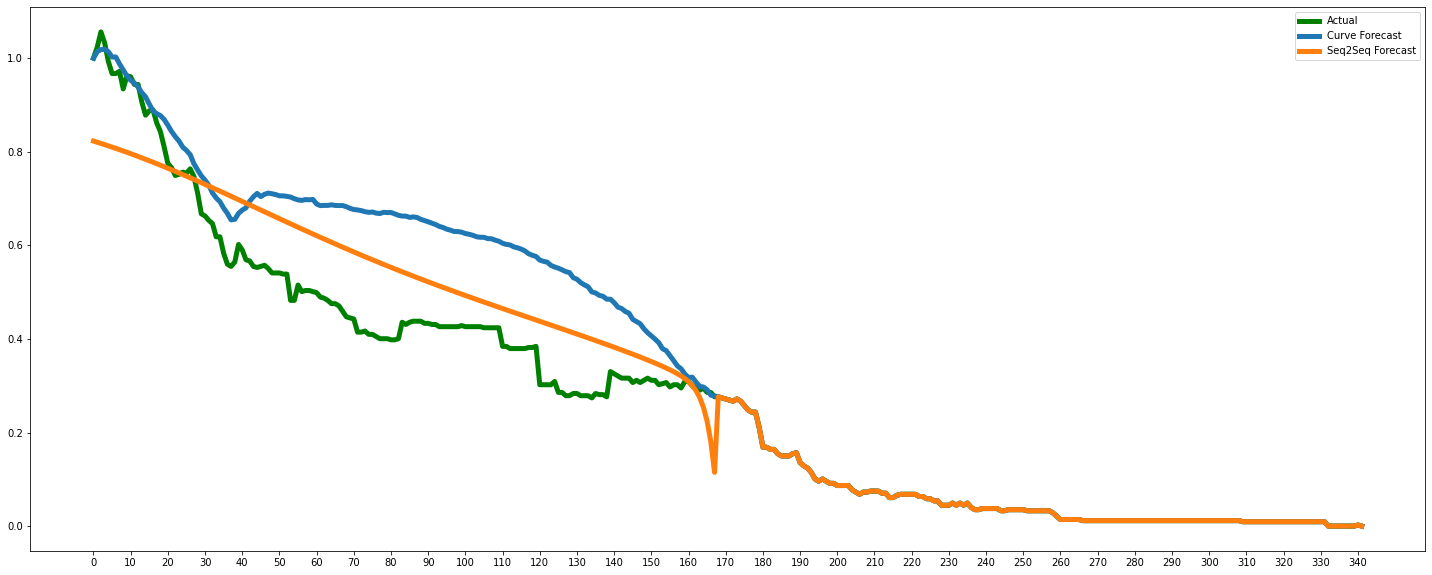

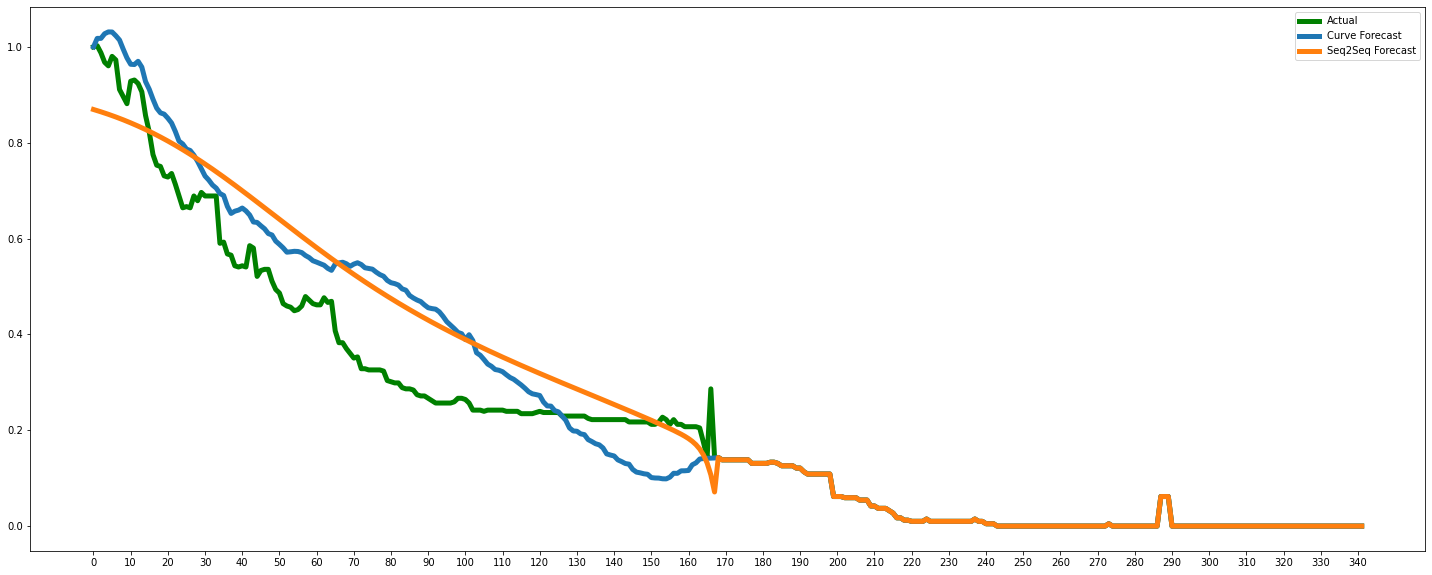

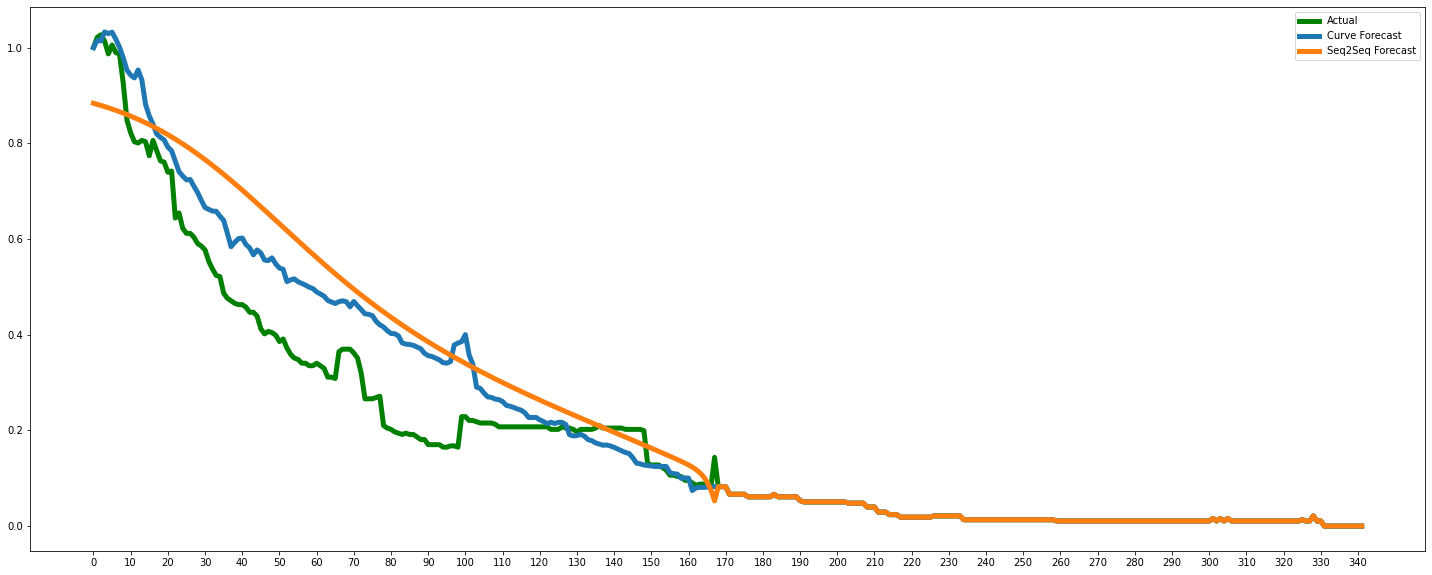

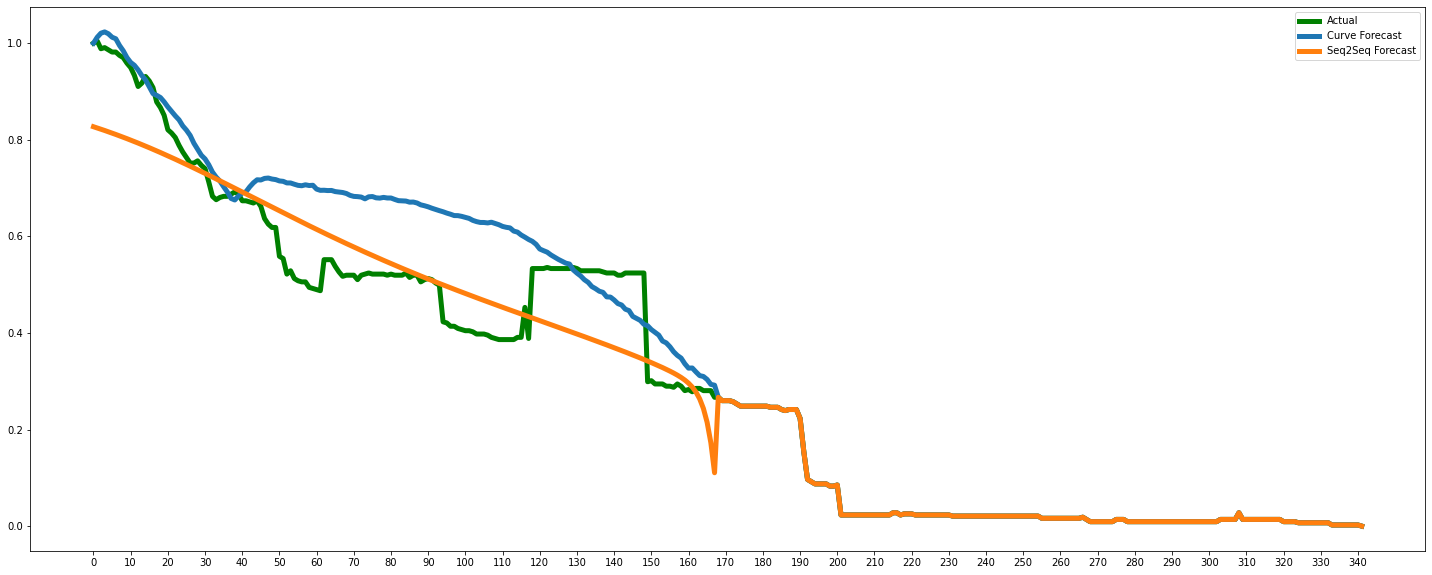

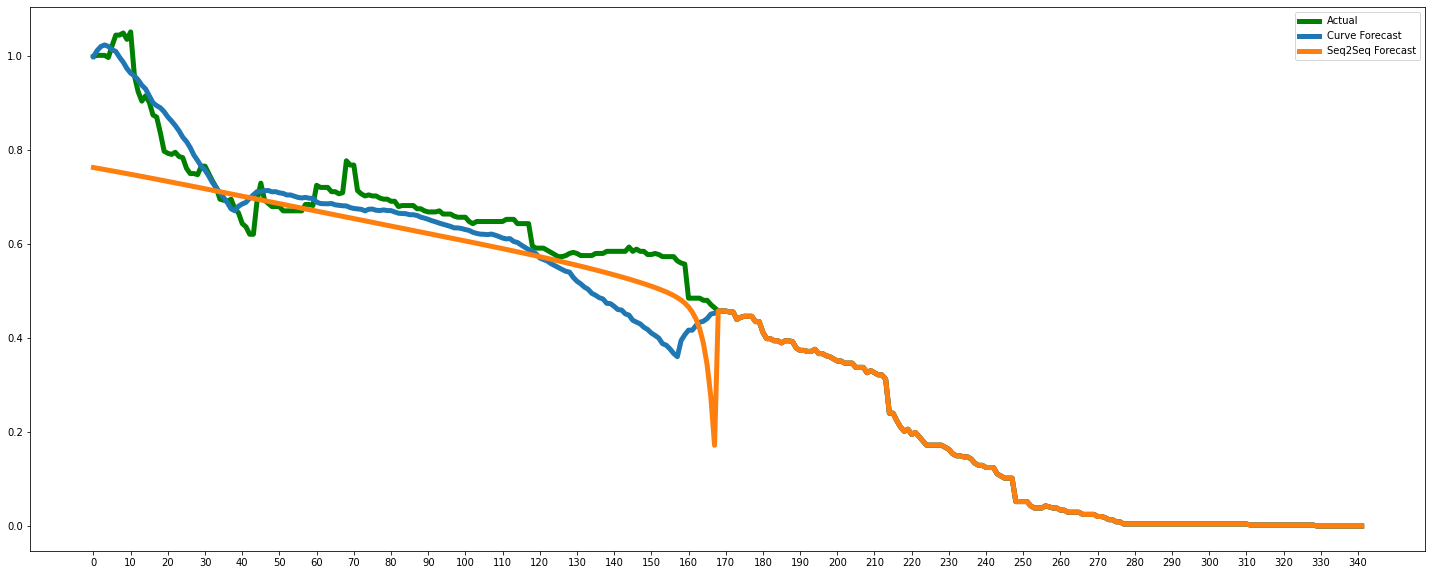

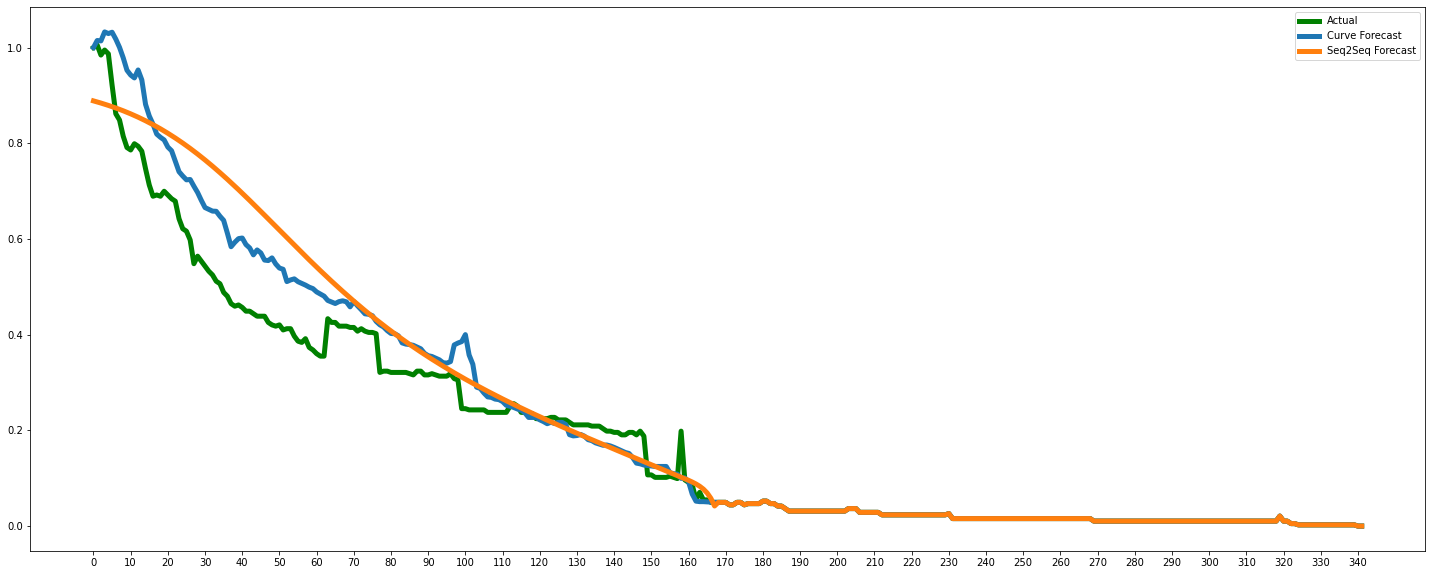

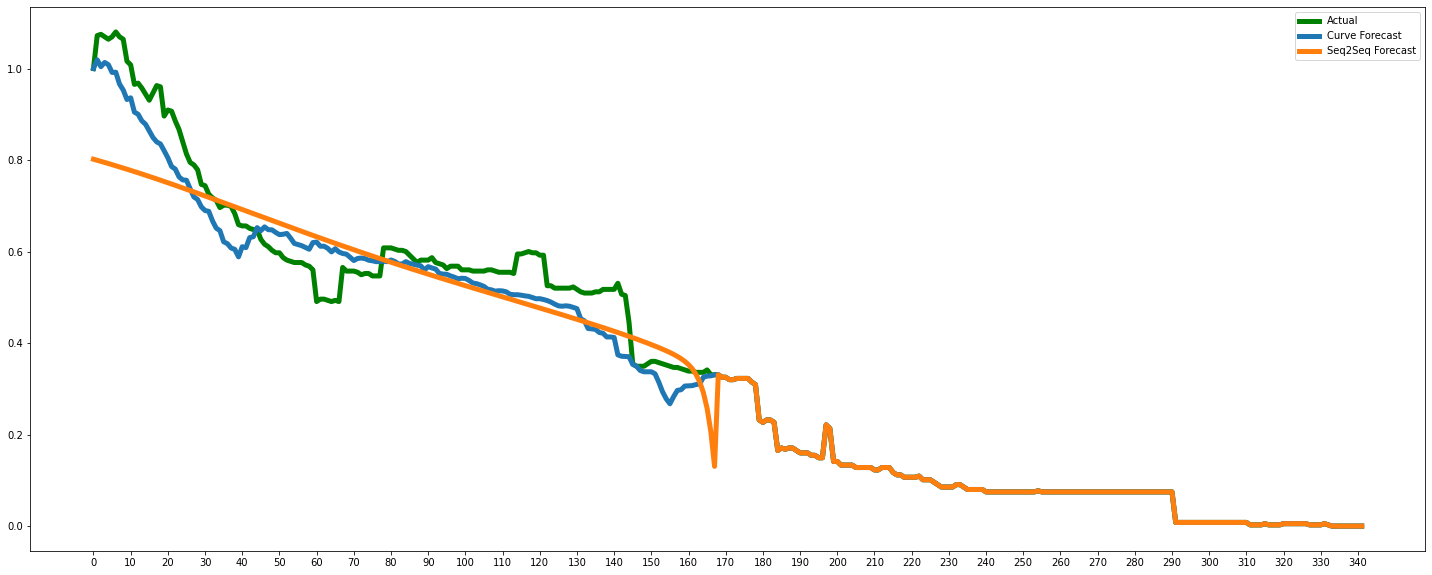

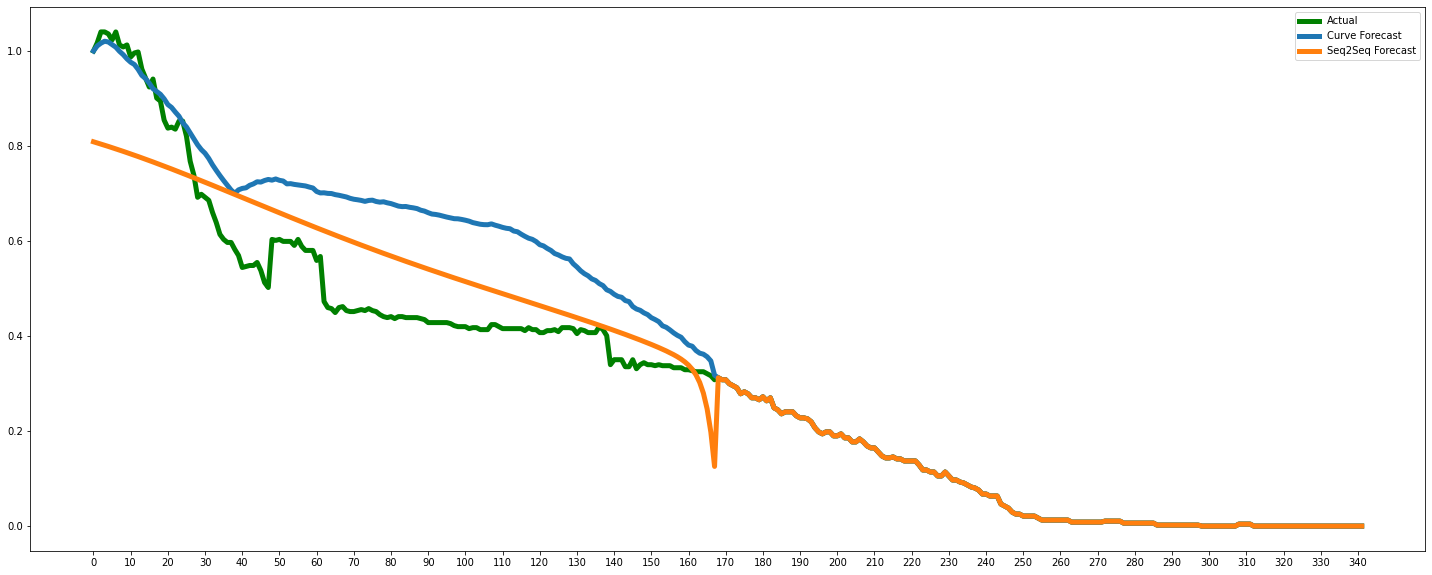

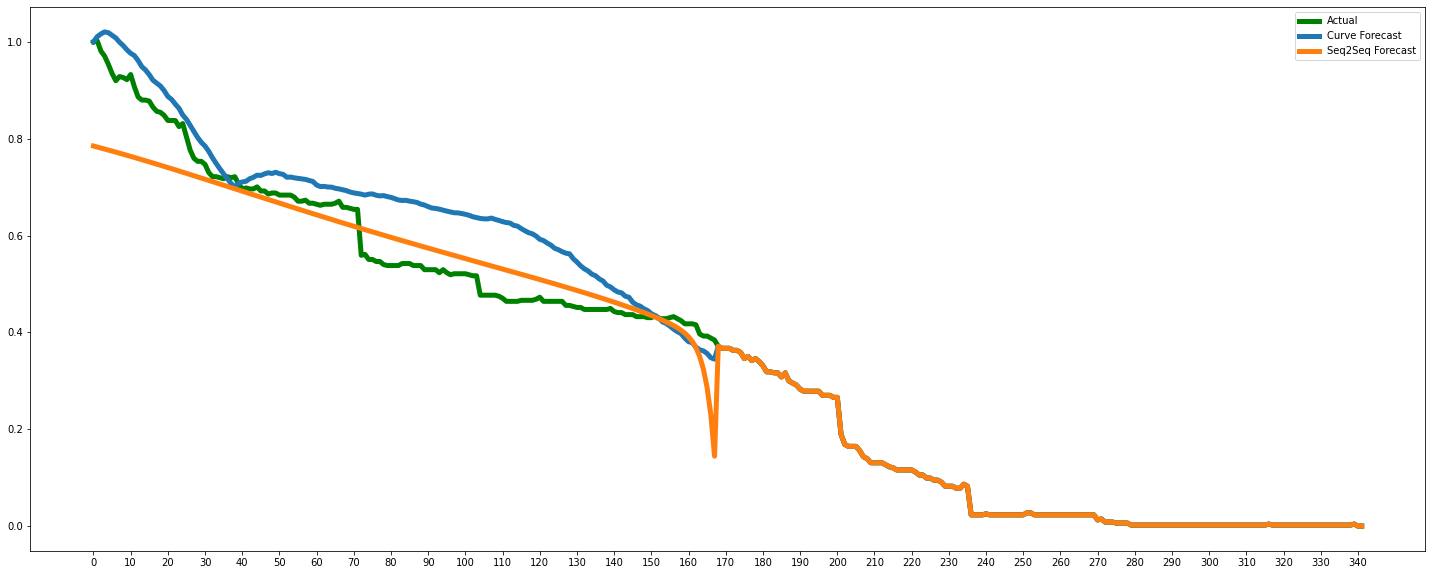

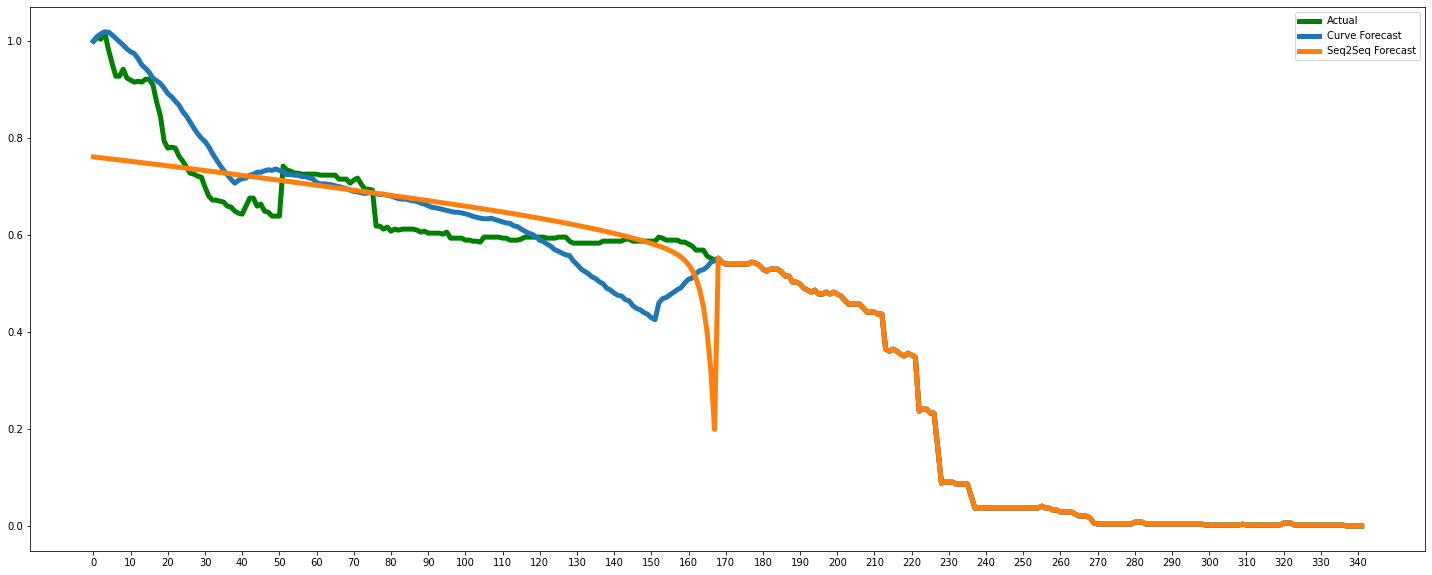

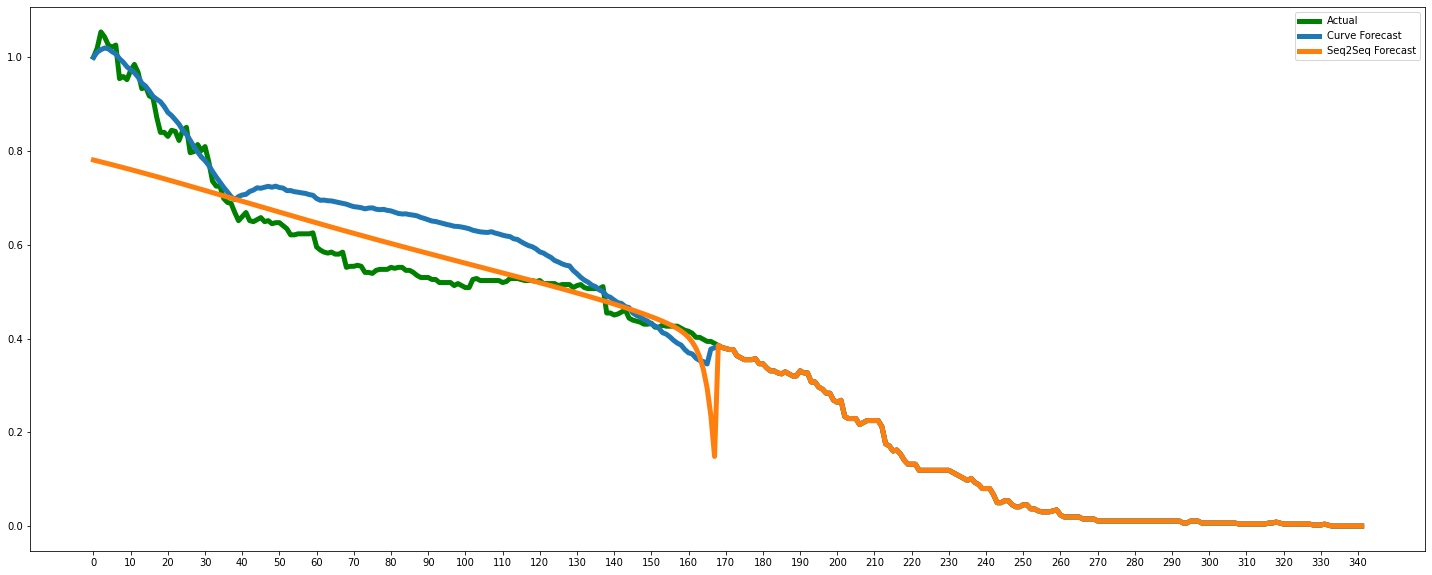

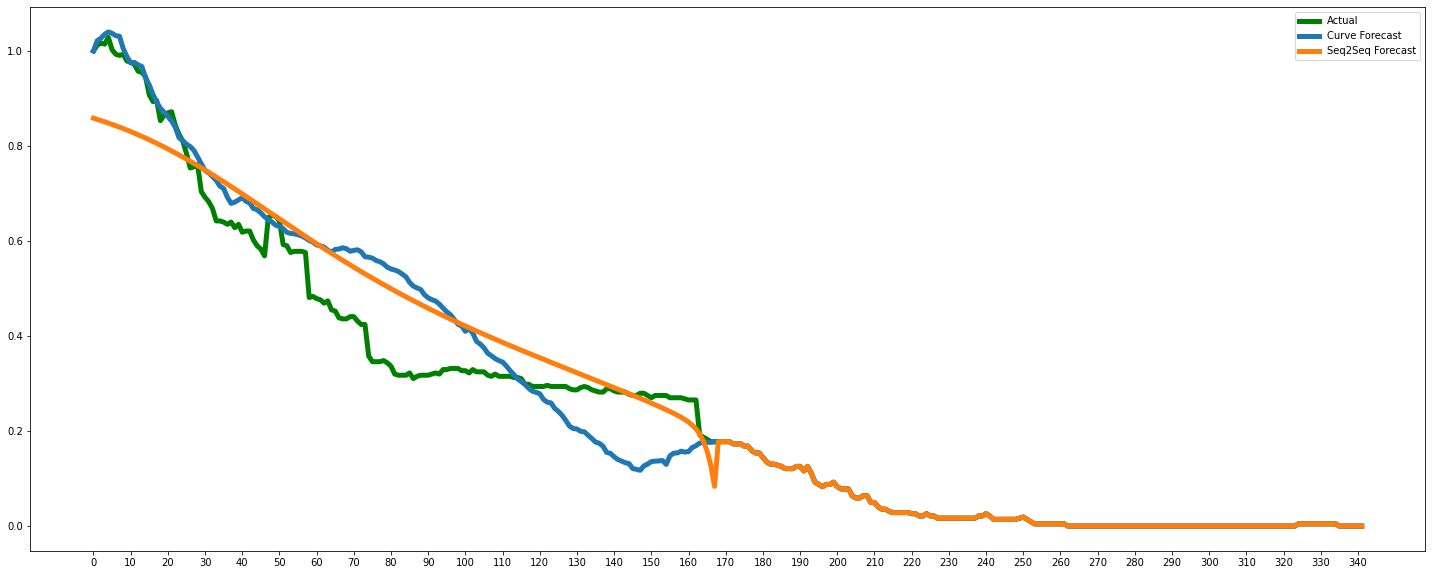

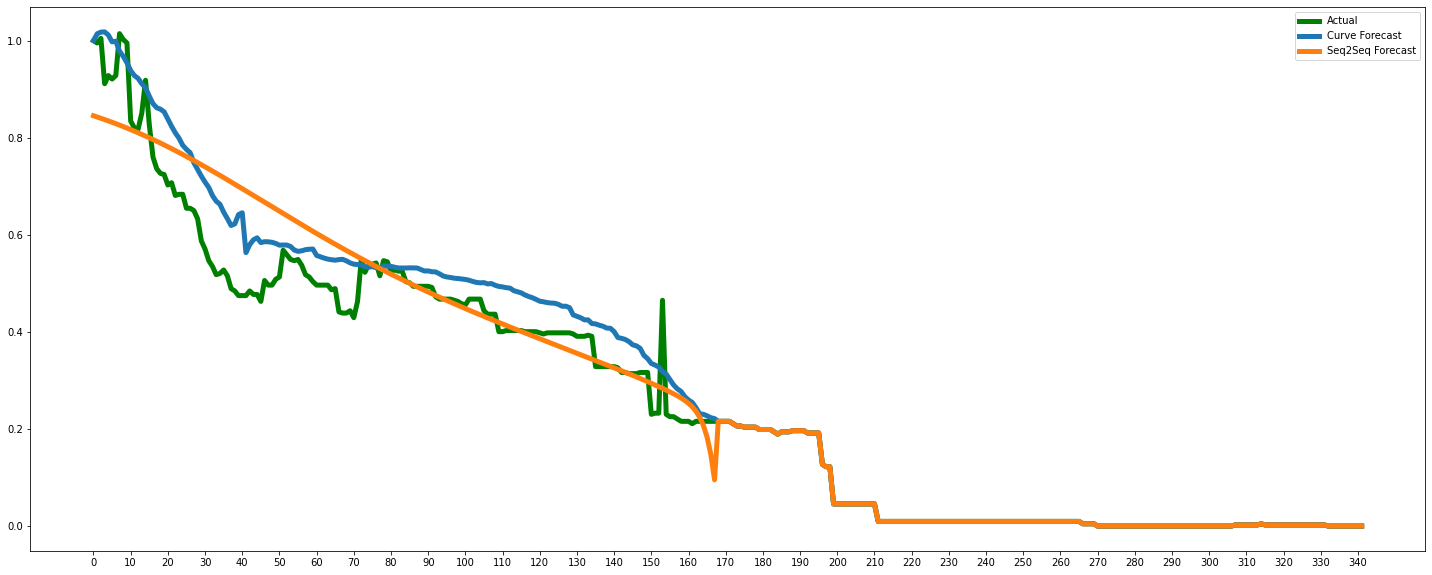

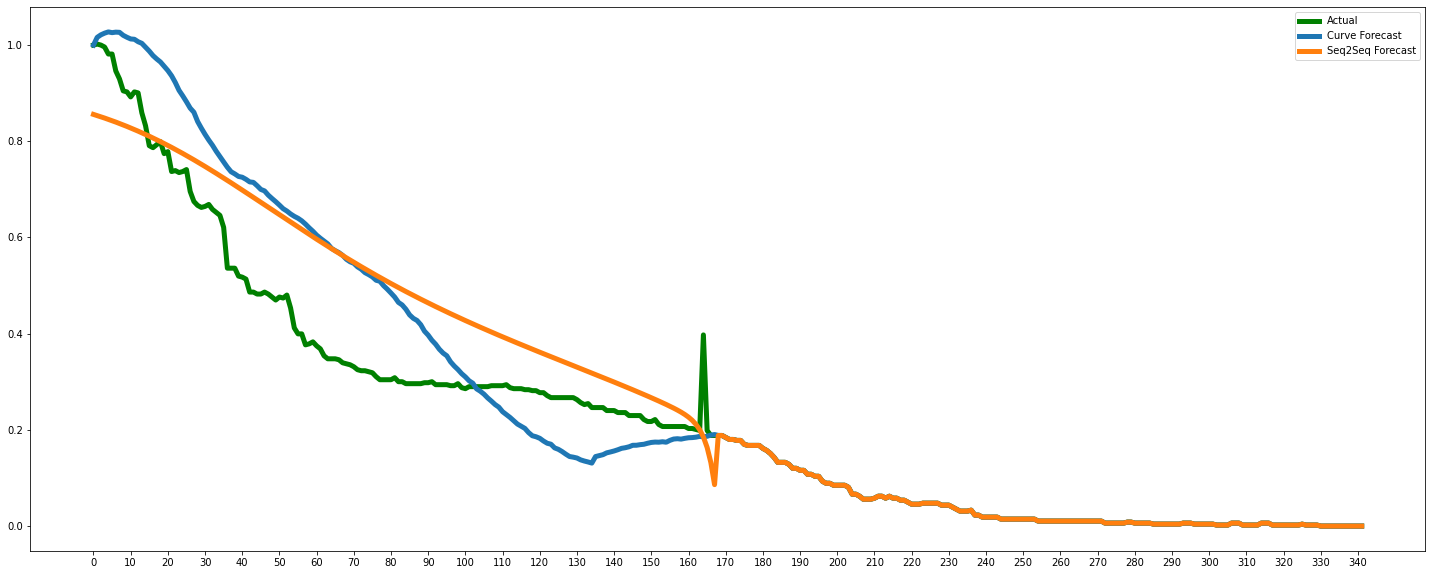

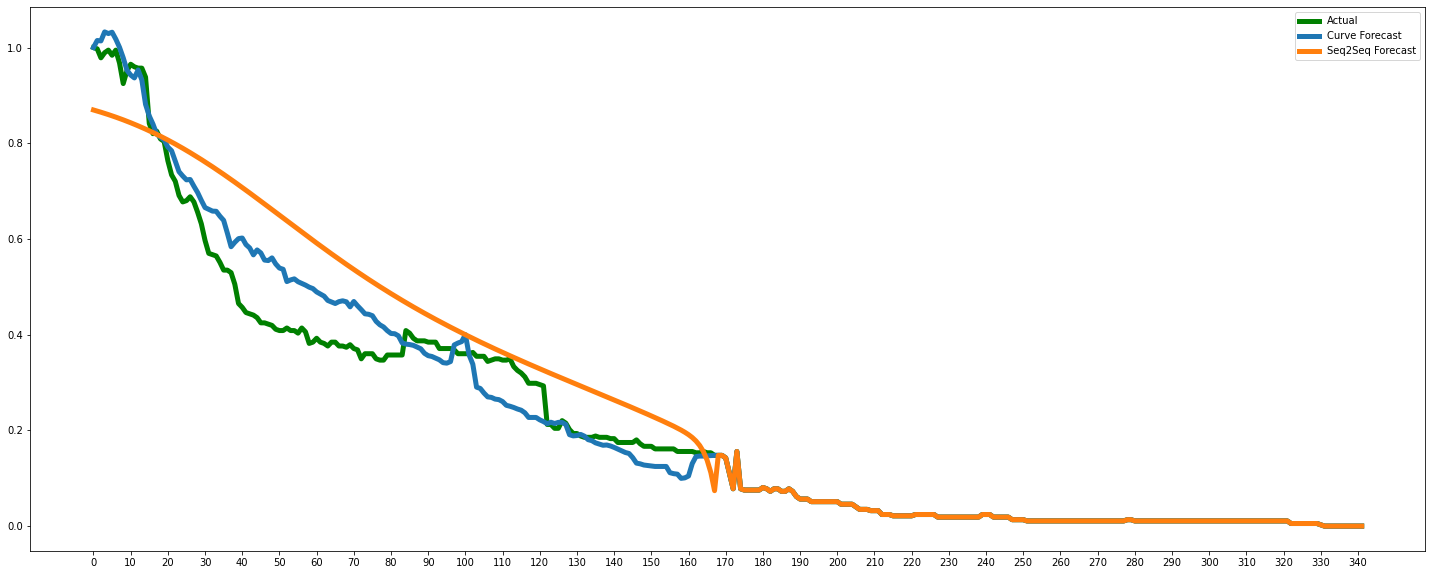

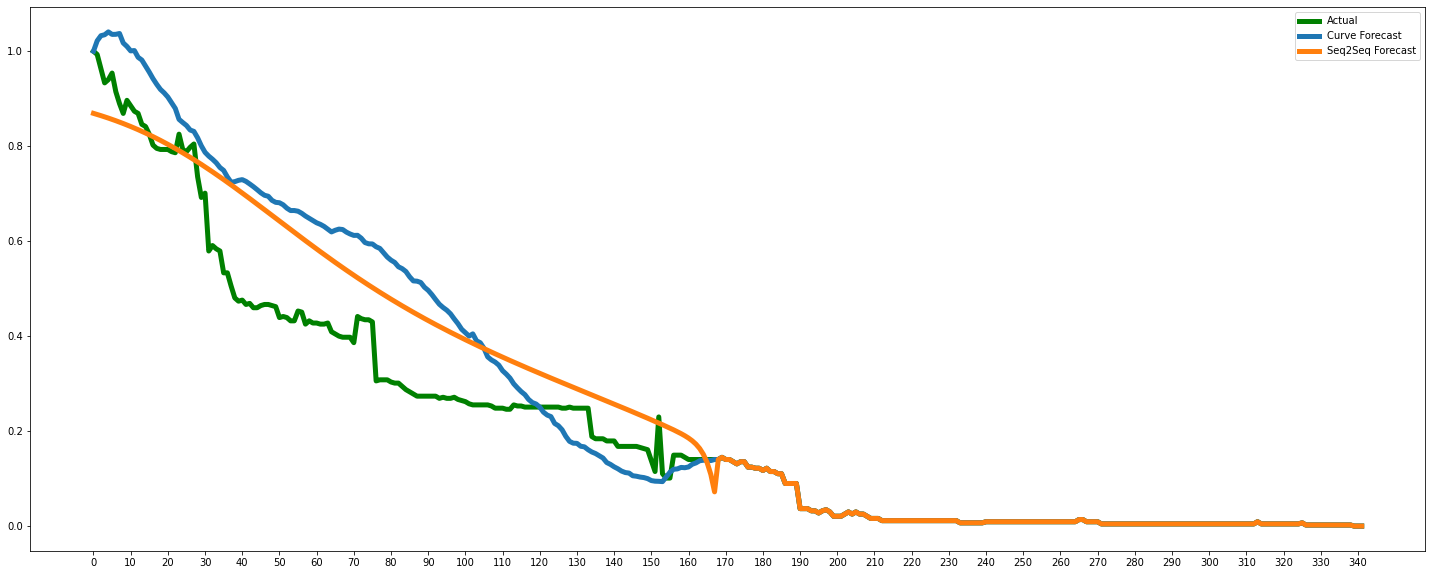

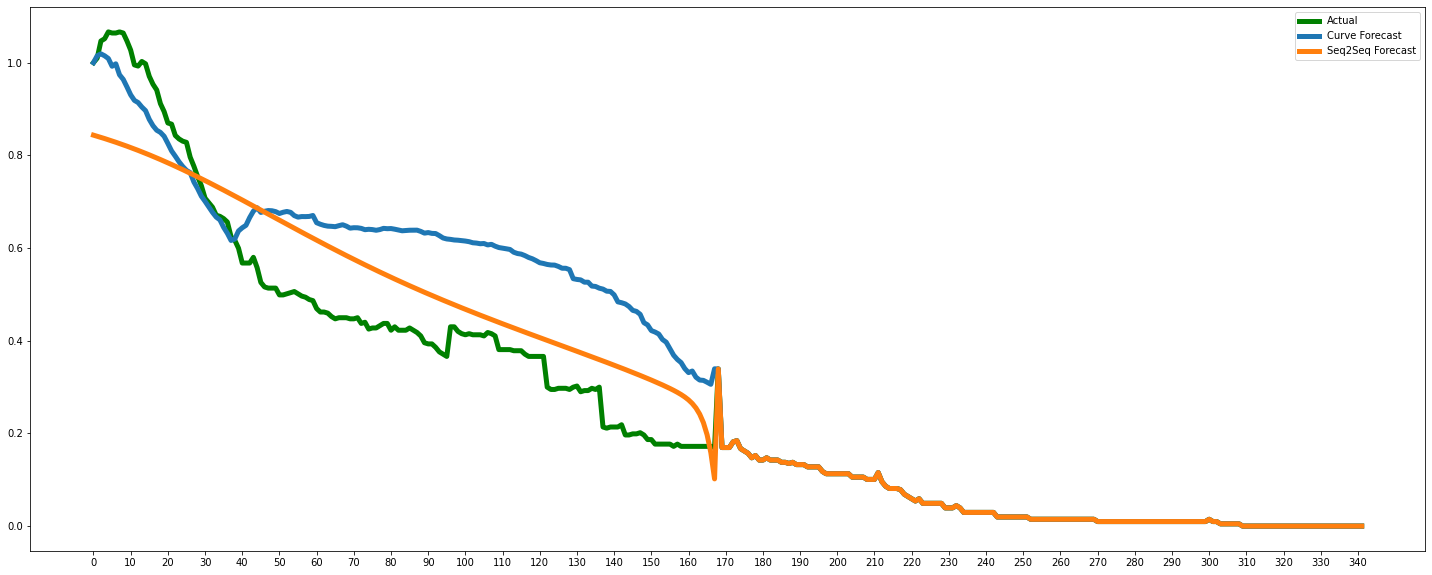

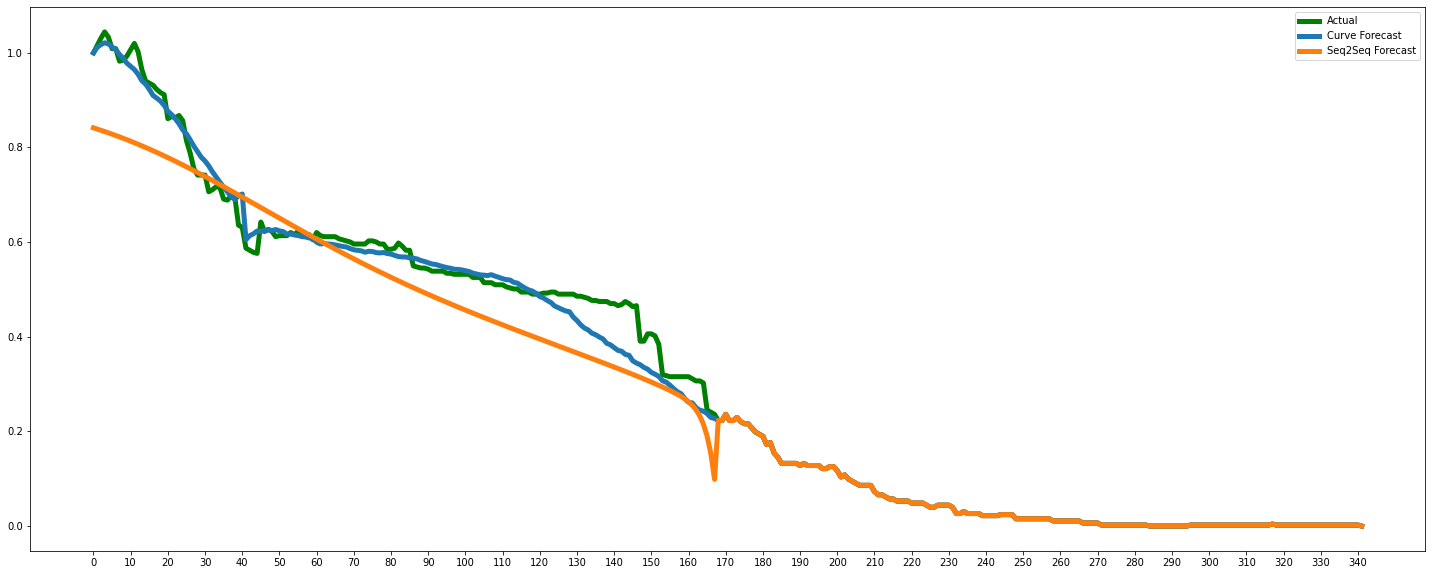

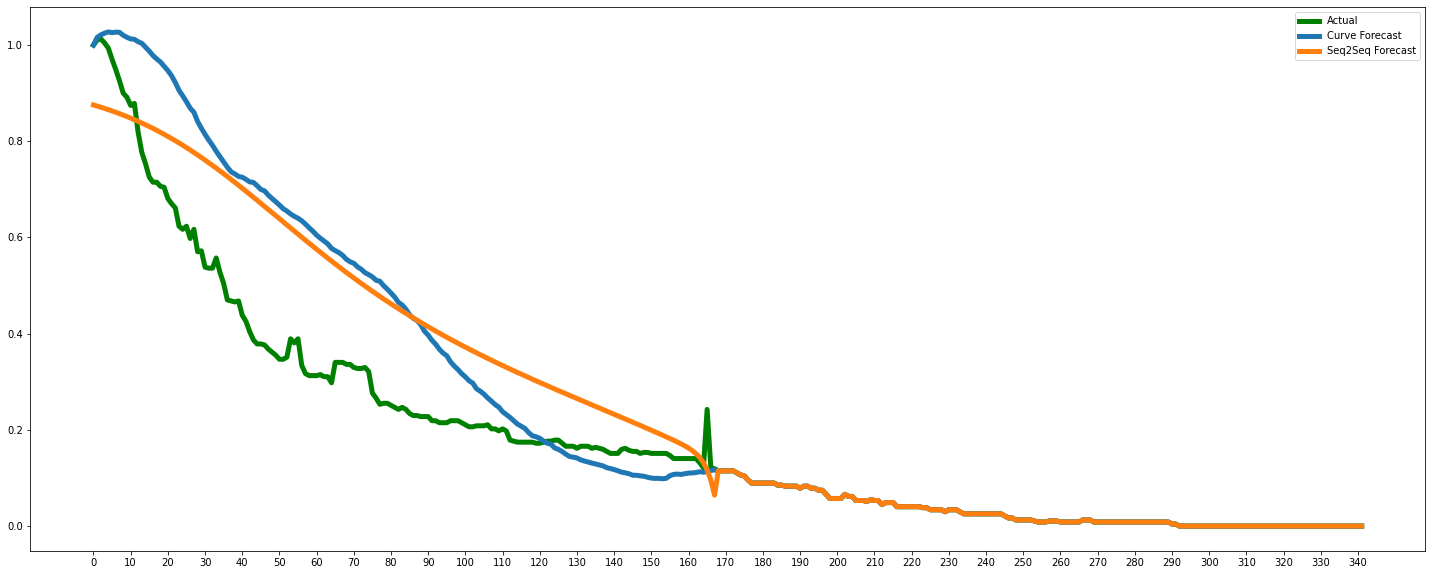

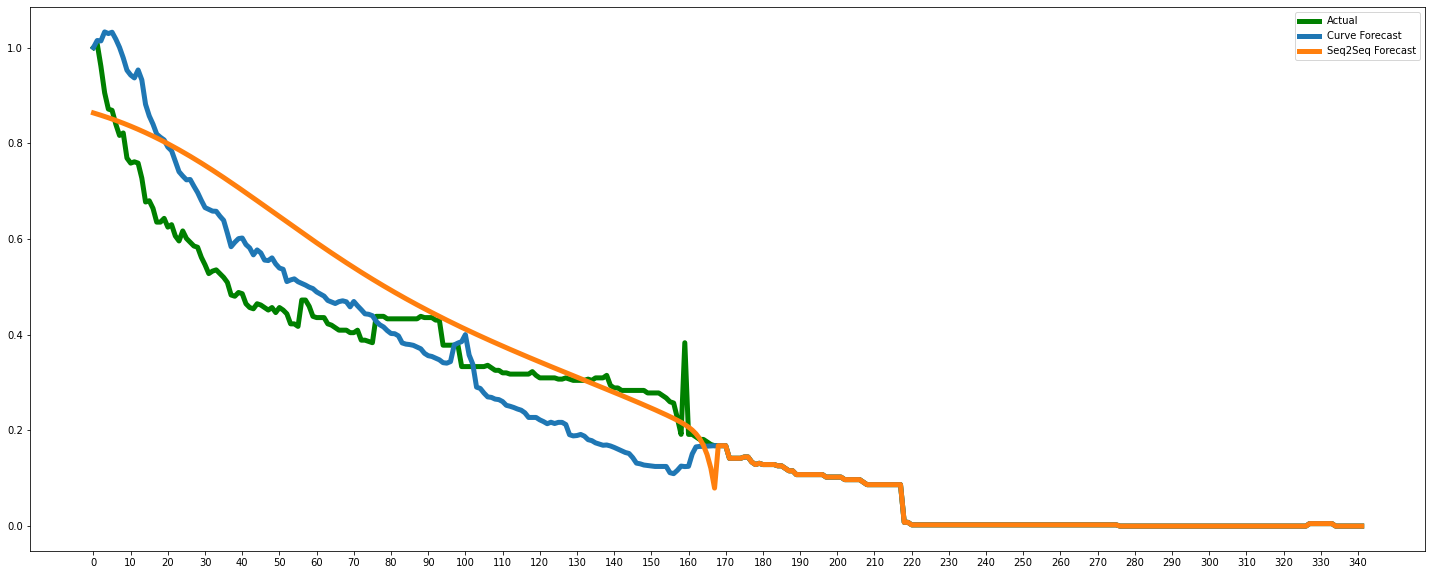

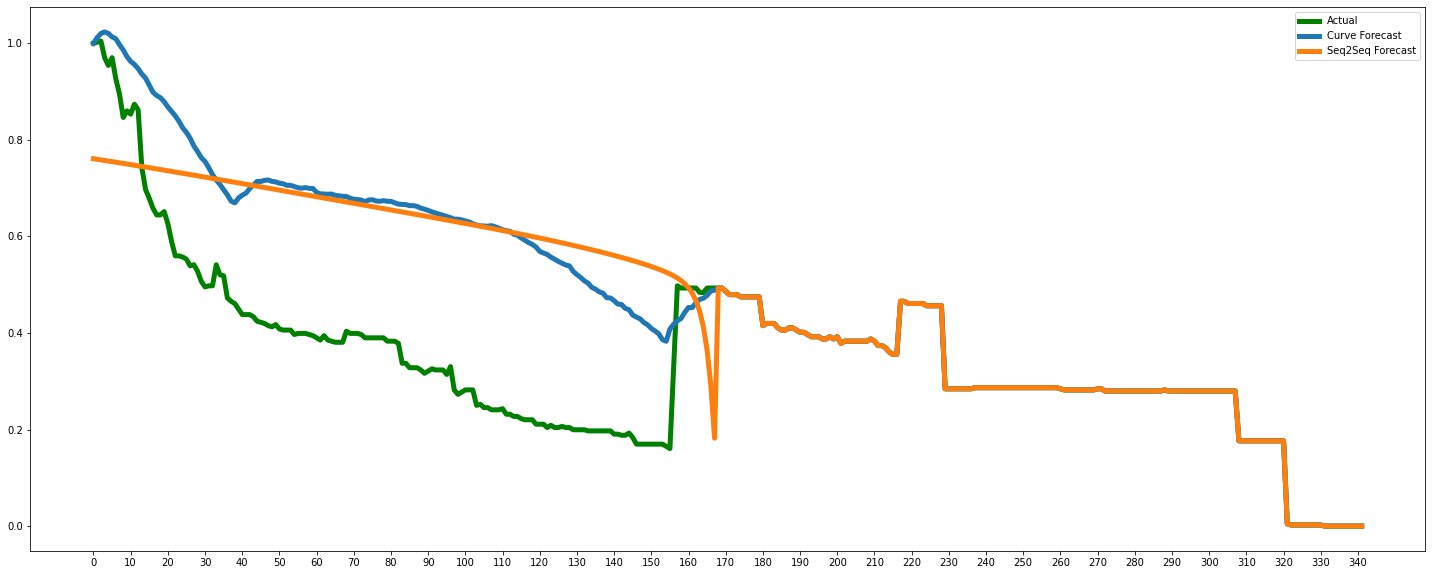

In [41]:
for v in range(df_val_curve_f_dxb_xxx.shape[0]):
  plt.figure(figsize=[25,10])
  plt.plot(_df_val_dxb_xxx.loc[v,'0':'341'],color='green',  linestyle='-',linewidth=5, label='Actual')
  plt.plot(df_val_curve_f_dxb_xxx.loc[v,'0':'341'],  linestyle='-',linewidth=5, label='Curve Forecast')
  plt.plot(df_val_seq2seq_f_dxb_xxx.loc[v,'0':'341'],linestyle='-',linewidth=5, label='Seq2Seq Forecast')
  plt.legend(loc='best')
  plt.xticks(np.arange(0, 342, 10))
  plt.show()

### Output data

In [42]:
df_output = pd.read_csv('out_curve_forecast_raw.csv')

In [43]:
df_output.head()

departure_Date Origin_Destination  Target    0         1  \
0  2023-03-13T00:00:00.000Z            DXB-XXX    1004  1.0  1.011119   
1  2023-06-12T00:00:00.000Z            DXB-XXX     489  1.0  1.009919   
2  2023-03-12T00:00:00.000Z            DXB-XXX     988  1.0  1.011119   
3  2023-06-11T00:00:00.000Z            DXB-XXX     489  1.0  1.009919   
4  2023-03-11T00:00:00.000Z            DXB-XXX     990  1.0  1.011119   

          2         3         4         5         6  ...     332     333  \
0  1.015228  1.019796  1.018410  1.012113  1.006823  ...  0.0000  0.0000   
1  1.014741  1.019493  1.018307  1.013124  1.006140  ...  0.0000  0.0000   
2  1.015228  1.019796  1.018410  1.012113  1.006823  ...  0.0000  0.0000   
3  1.014741  1.019493  1.018307  1.013124  1.006140  ...  0.0041  0.0041   
4  1.015228  1.019796  1.018410  1.012113  1.006823  ...  0.0000  0.0000   

      334     335     336     337     338     339  340  341  
0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0  
1  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0  
2  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0  
3  0.0041  0.0041  0.0041  0.0041  0.0041  0.0041  0.0  0.0  
4  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0  

[5 rows x 345 columns]

In [44]:
df_output.fillna(0,inplace=True)

In [45]:
df_output.columns = df_output.columns.map(str)

In [46]:
df_out_dxb_xxx = df_output[df_output['Origin_Destination']=='DXB-XXX']
df_out_xxx_dxb = df_output[df_output['Origin_Destination']=='XXX-DXB']

In [47]:
df_out_dxb_xxx.reset_index(drop=True, inplace=True)
df_out_xxx_dxb.reset_index(drop=True, inplace=True)

In [48]:
_df_out_dxb_xxx = df_out_dxb_xxx.copy()
_df_out_xxx_dxb = df_out_xxx_dxb.copy()

In [49]:
X_out_dxb_xxx = df_out_dxb_xxx.loc[:,str(last_available_data+1):'341']
X_out_dxb_xxx = X_out_dxb_xxx[X_out_dxb_xxx.columns[::-1]].values
X_out_dxb_xxx = X_out_dxb_xxx.reshape(X_out_dxb_xxx.shape[0],-1,1)

Y_out_dxb_xxx = df_out_xxx_dxb.loc[:,'0':str(last_available_data)]
Y_out_dxb_xxx = Y_out_dxb_xxx[Y_out_dxb_xxx.columns[::-1]].values
Y_out_dxb_xxx = Y_out_dxb_xxx.reshape(Y_out_dxb_xxx.shape[0],-1,1)

X_out_xxx_dxb = df_out_xxx_dxb.loc[:,str(last_available_data+1):'341']
X_out_xxx_dxb = X_out_xxx_dxb[X_out_xxx_dxb.columns[::-1]].values
X_out_xxx_dxb = X_out_xxx_dxb.reshape(X_out_xxx_dxb.shape[0],-1,1)

Y_out_xxx_dxb = df_out_xxx_dxb.loc[:,'0':str(last_available_data)]
Y_out_xxx_dxb = Y_out_xxx_dxb[Y_out_xxx_dxb.columns[::-1]].values
Y_out_xxx_dxb = Y_out_xxx_dxb.reshape(Y_out_xxx_dxb.shape[0],-1,1)

In [50]:
_Y_out_dxb_xxx = model_dxb_xxx.predict(X_out_dxb_xxx).reshape(-1,n_lookup)
_Y_out_xxx_dxb = model_xxx_dxb.predict(X_out_xxx_dxb).reshape(-1,n_lookup)

1/1 [==============================] - 0s 38ms/step


In [51]:
for n, i in df_out_dxb_xxx.iterrows():
  if ~np.isnan(_Y_out_dxb_xxx[n][0]):
    df_out_dxb_xxx.loc[n,'0':str(last_available_data)] = _Y_out_dxb_xxx[n].reshape(-1)[::-1]

In [52]:
for n, i in df_out_xxx_dxb.iterrows():
  if ~np.isnan(_Y_out_xxx_dxb[n][0]):
    df_out_xxx_dxb.loc[n,'0':str(last_available_data)] = _Y_out_xxx_dxb[n].reshape(-1)[::-1]

0


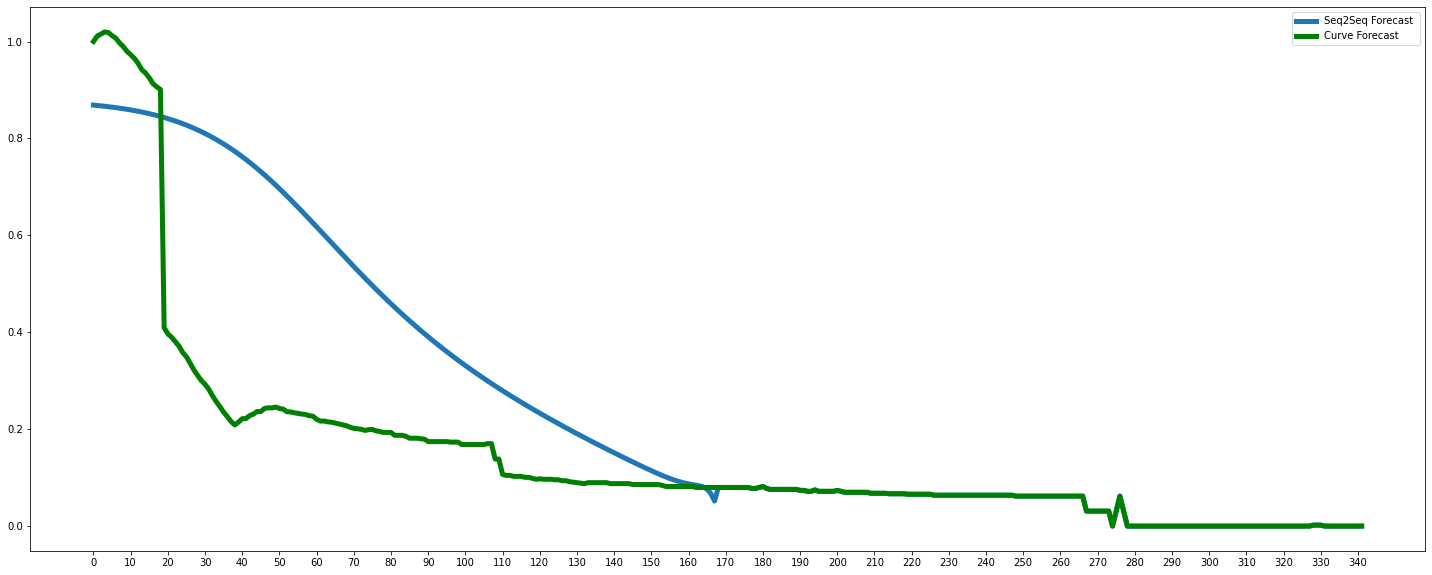

1


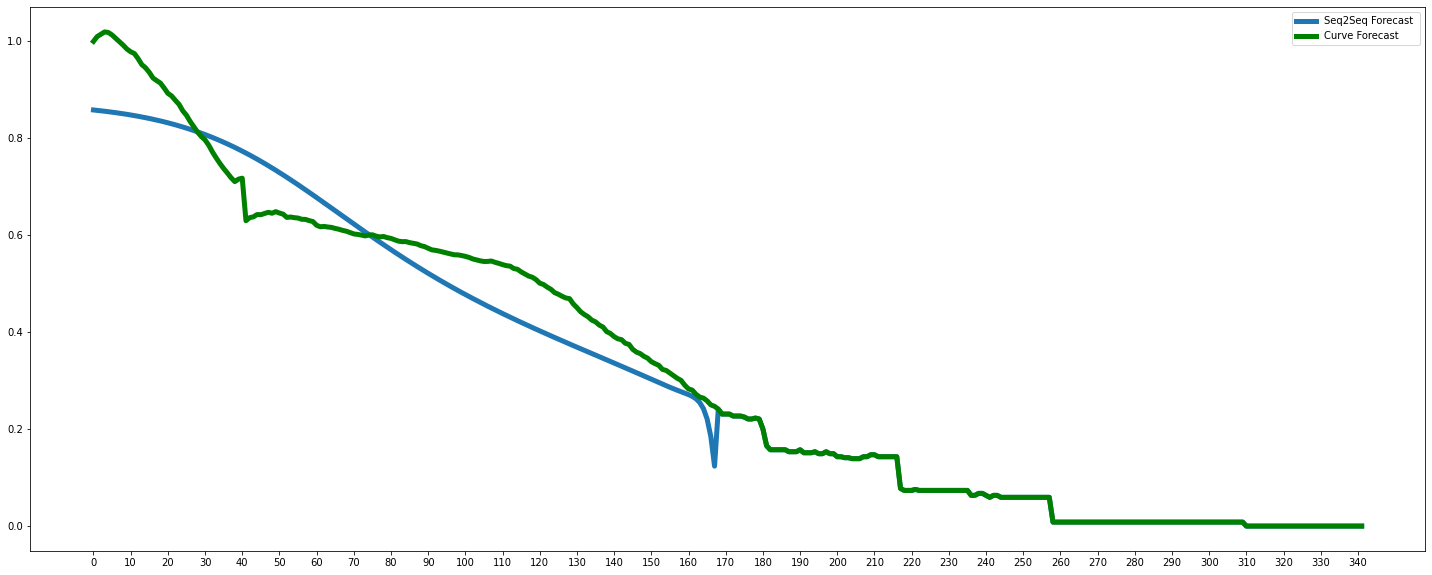

2


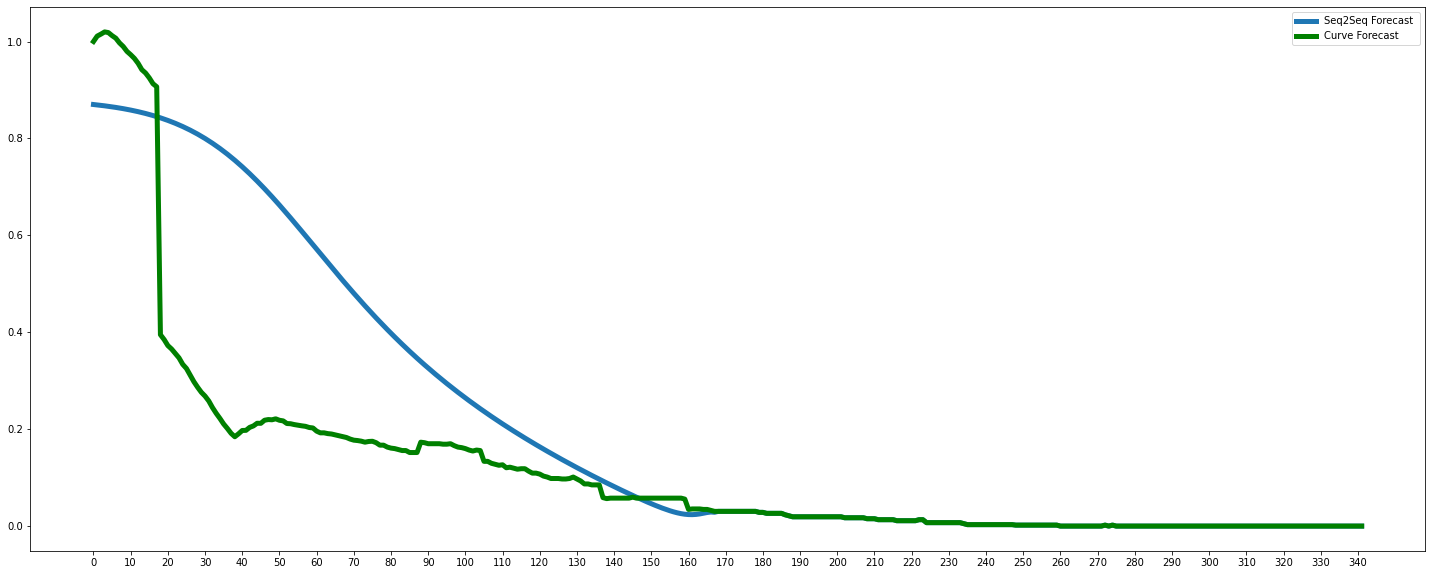

3


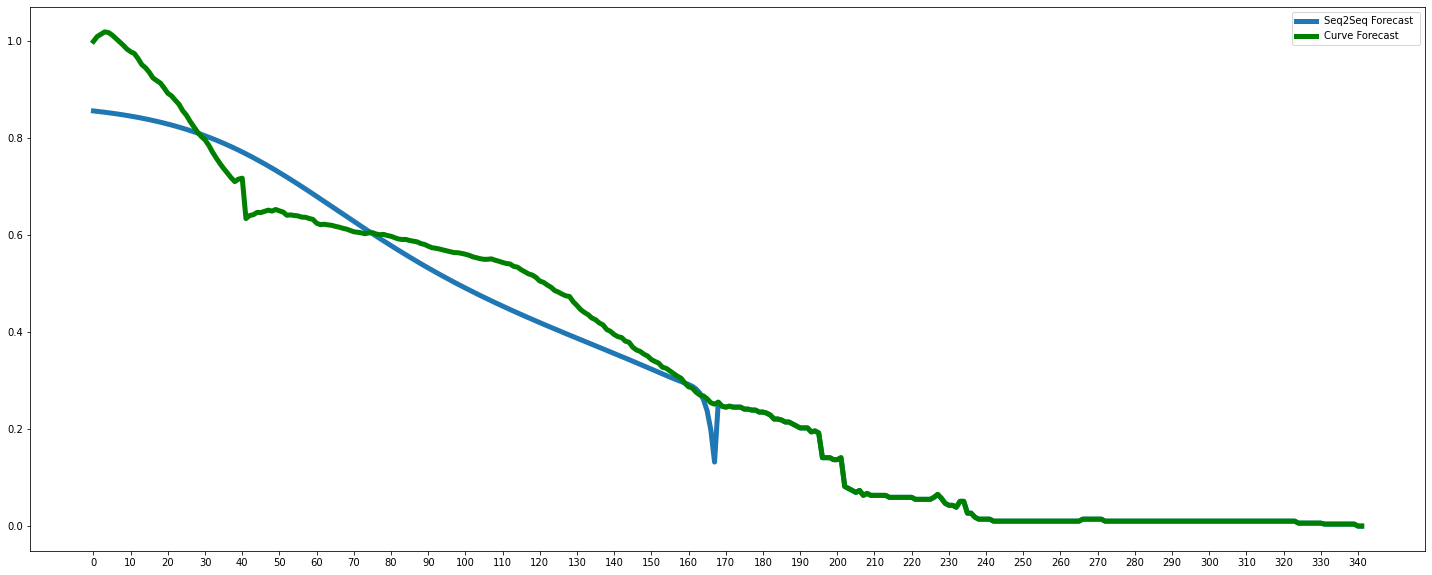

4


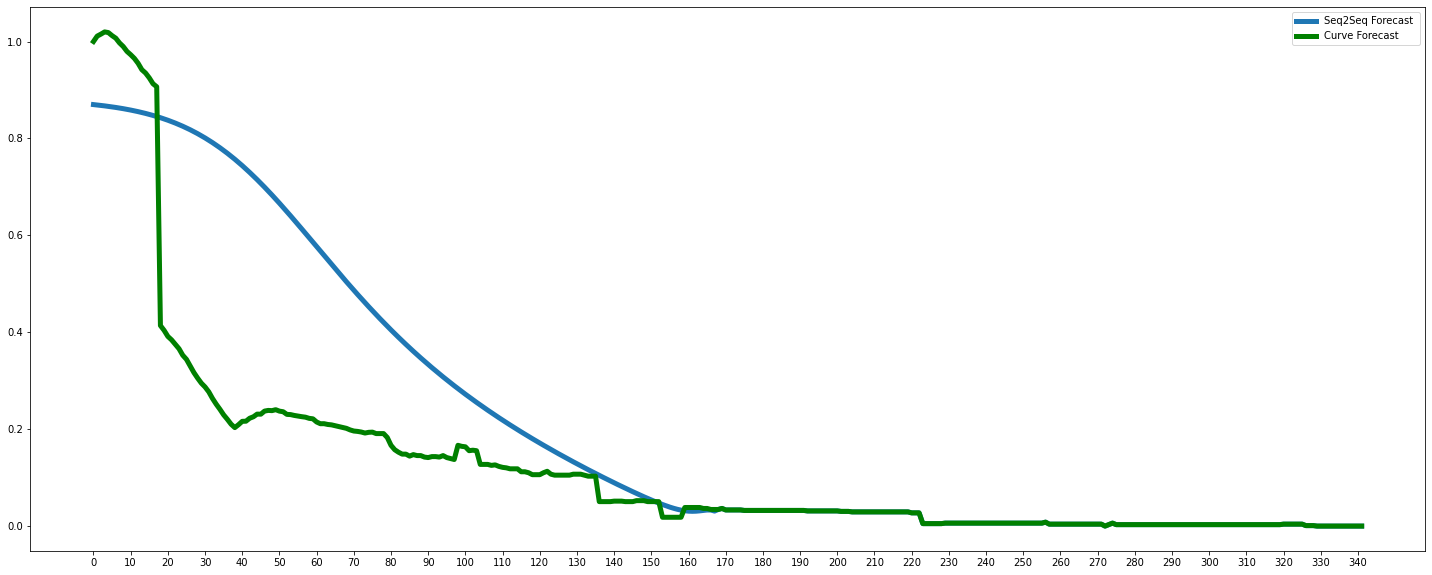

5


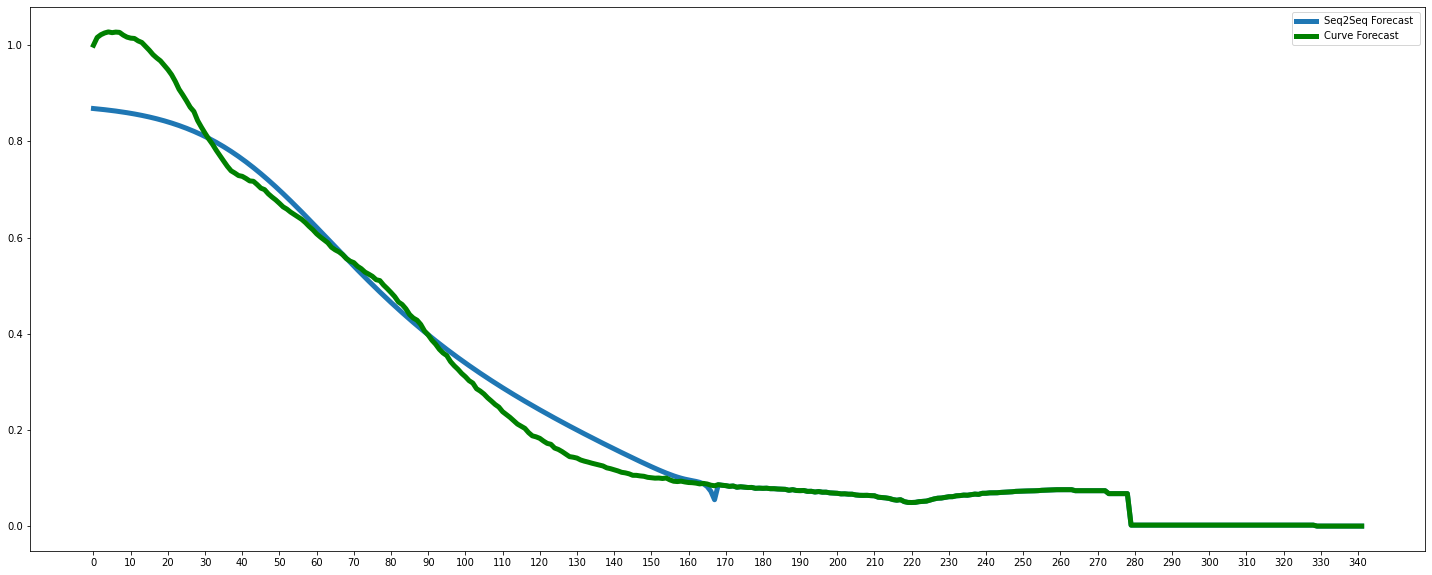

6


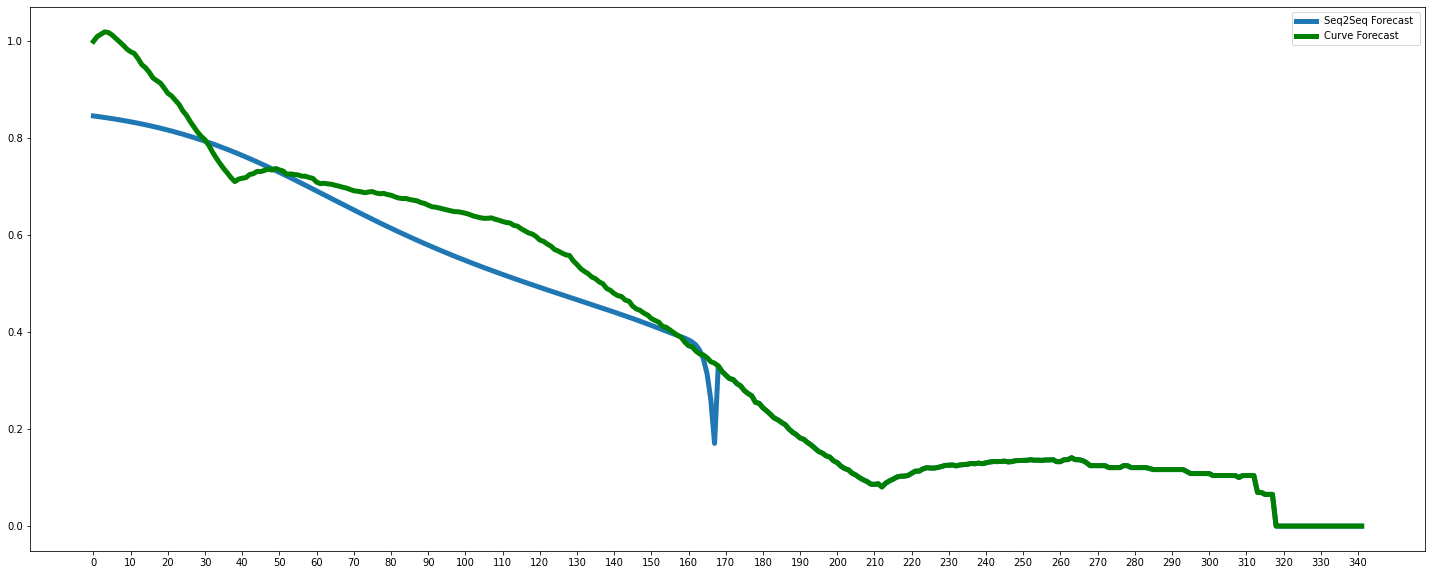

7


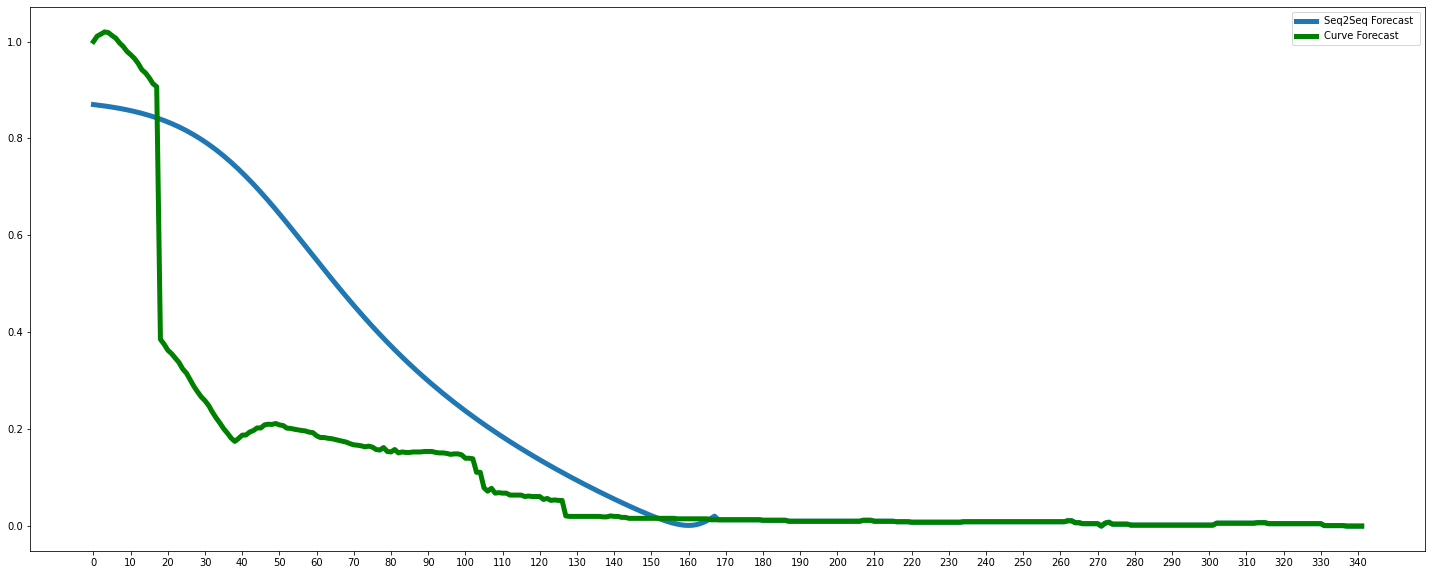

8


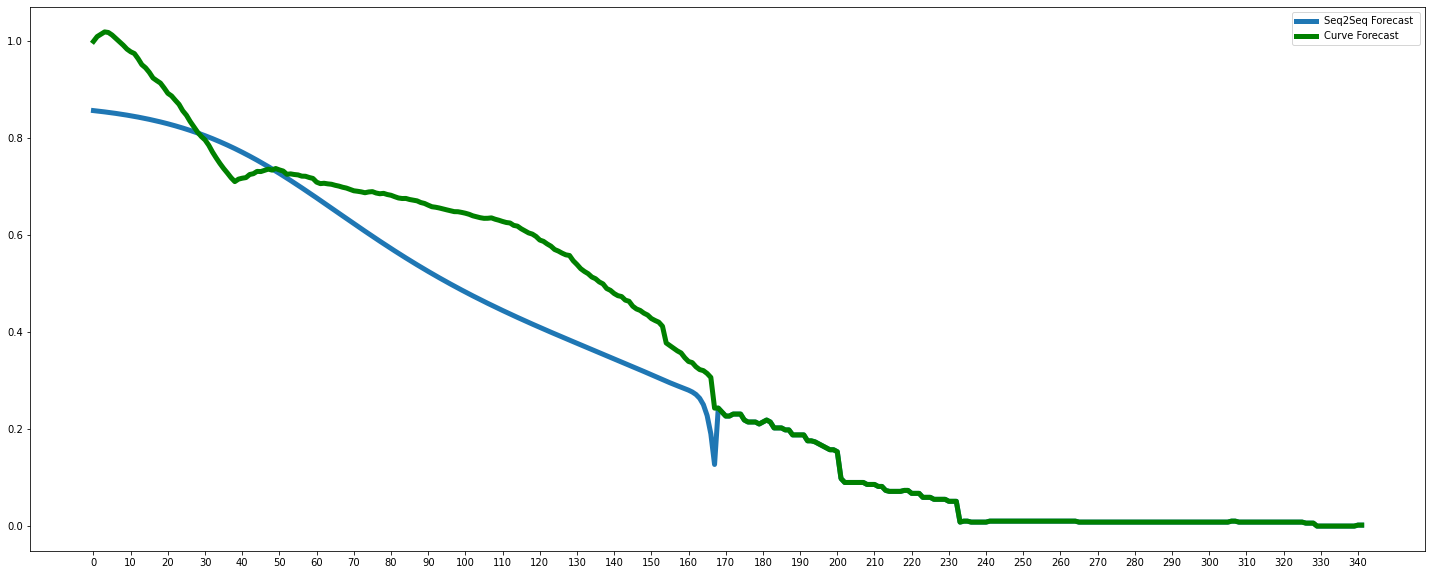

9


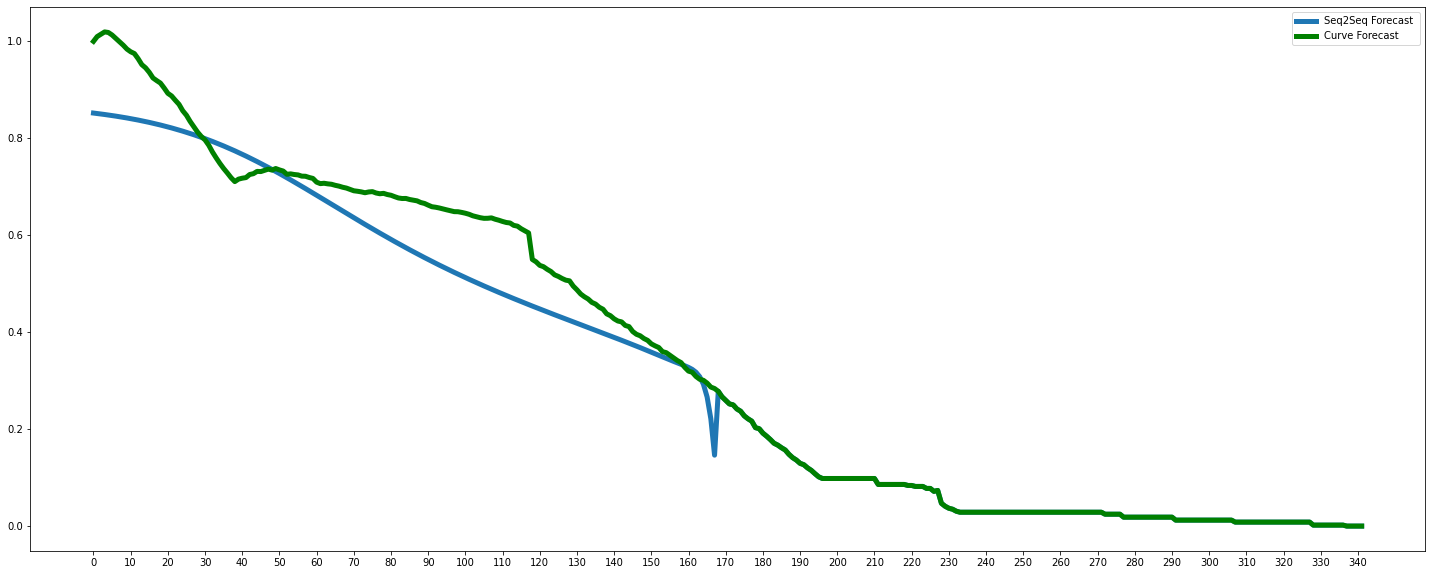

10


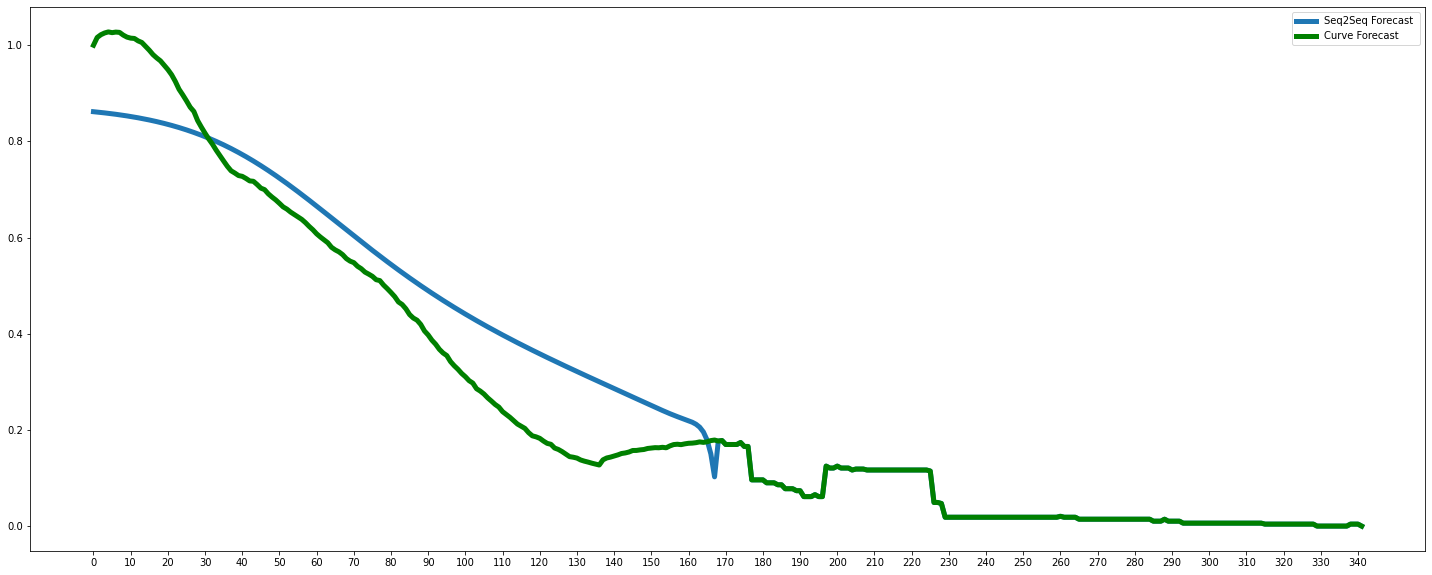

11


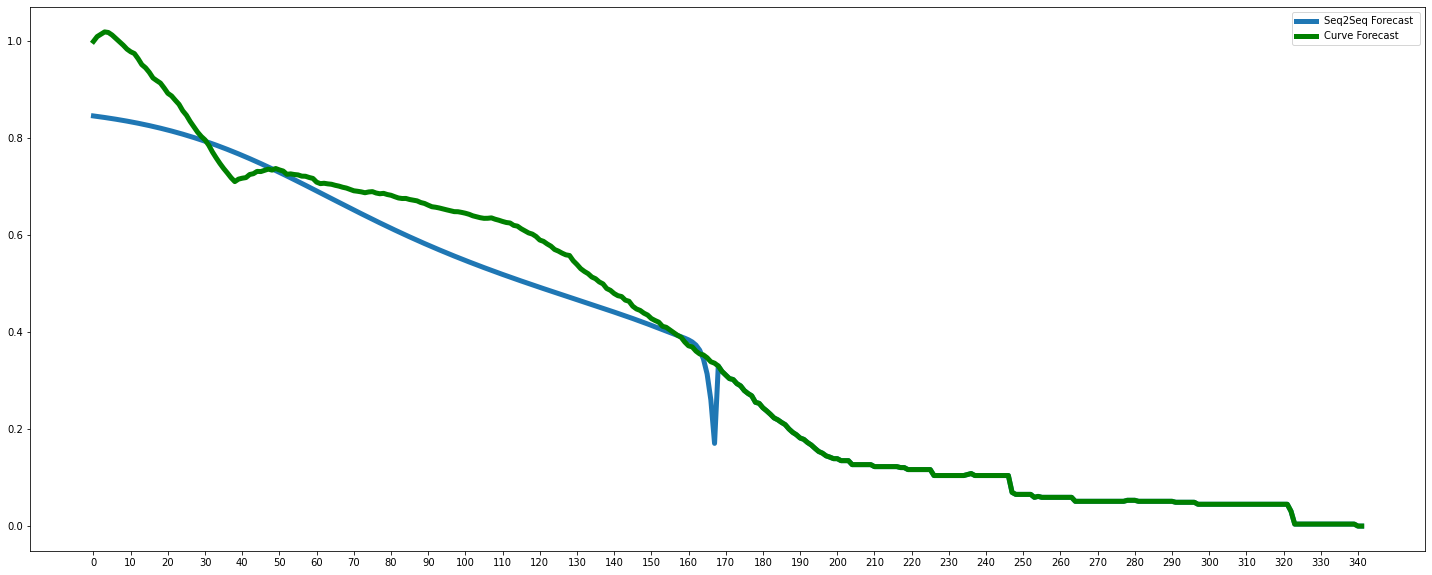

12


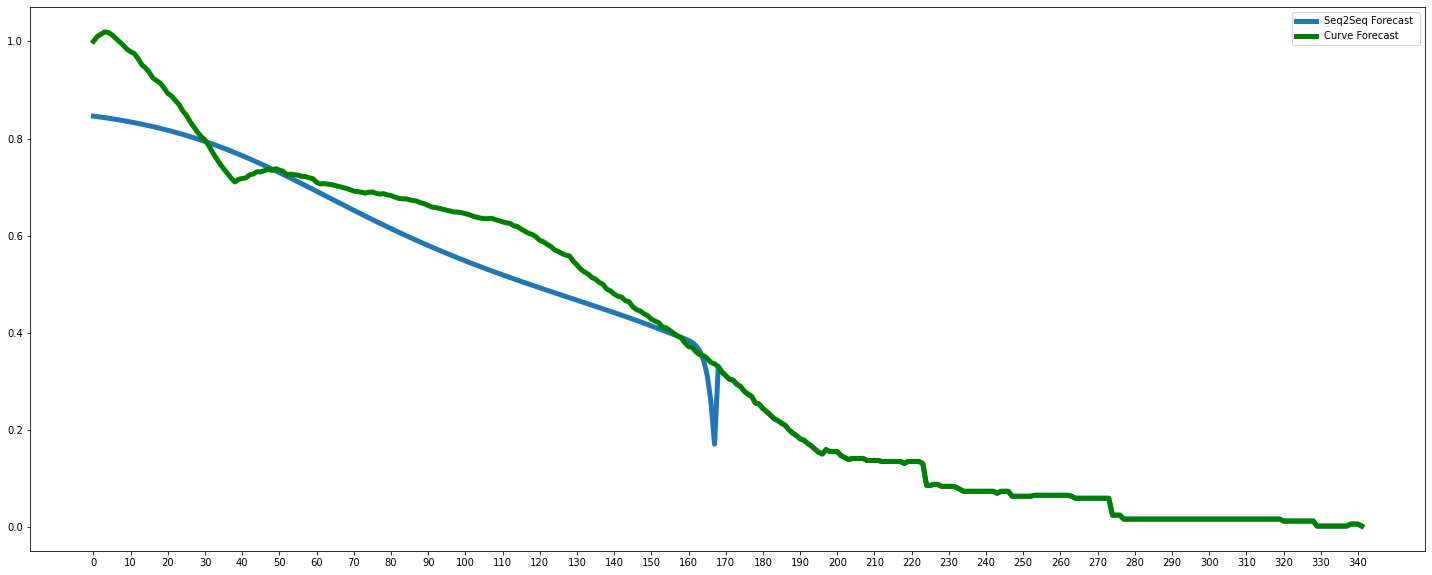

13


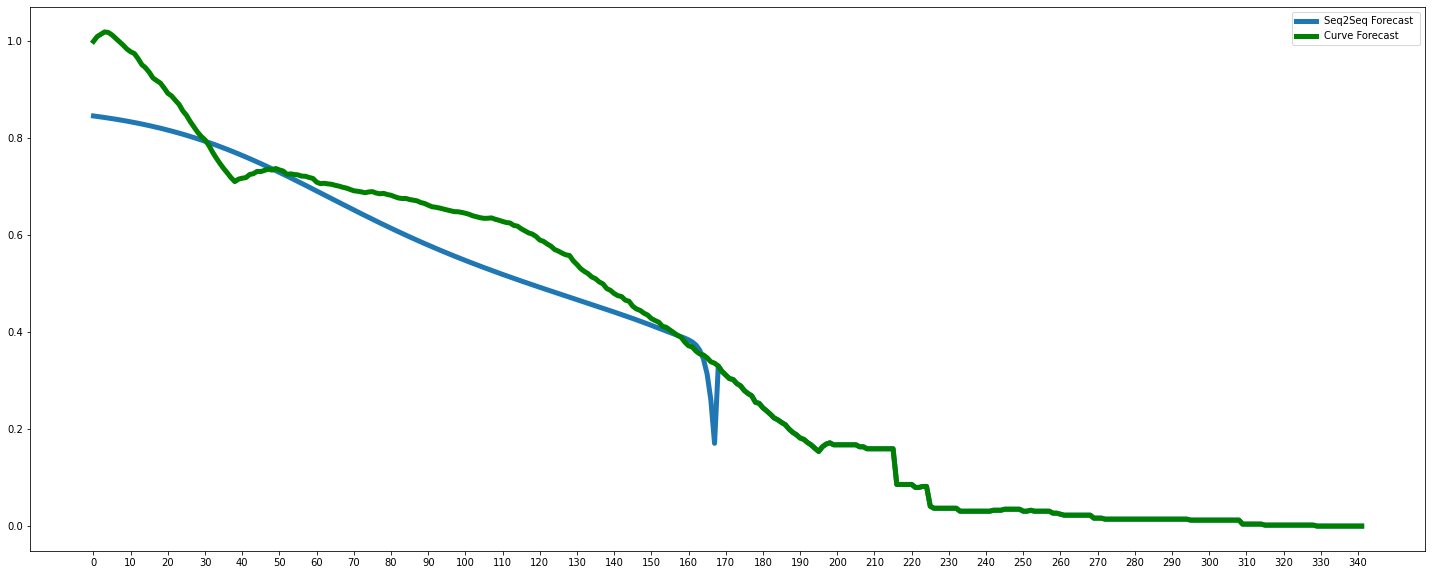

14


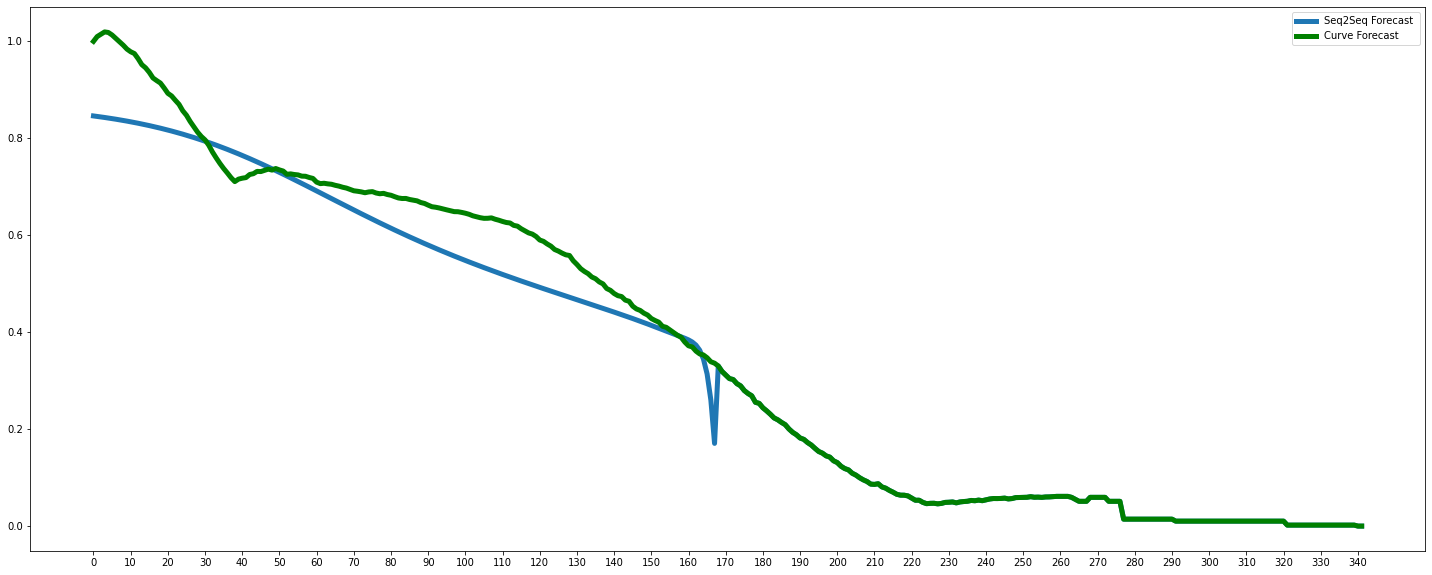

15


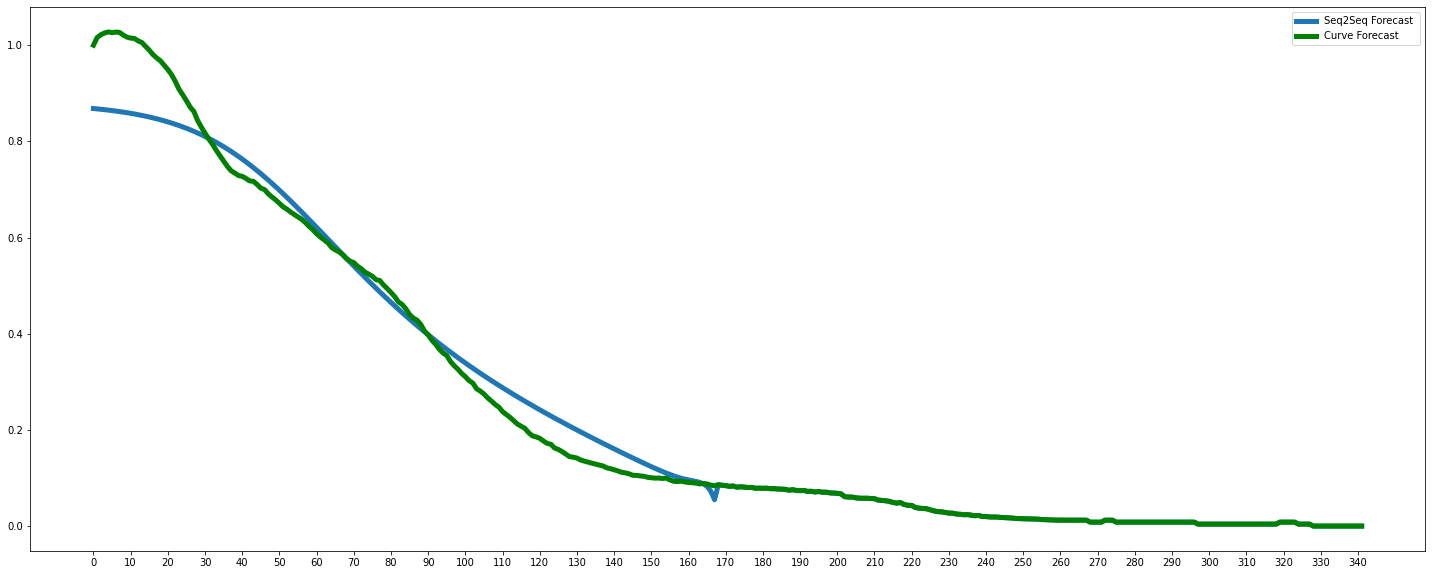

In [54]:
for v in range(df_out_dxb_xxx.shape[0]):
  print(v)
  rmse = sqrt(mean_squared_error(_df_out_dxb_xxx.loc[v,'0':'341'].values, df_out_dxb_xxx.loc[v,'0':'341'].values))
  df_out_dxb_xxx.loc[v,'RMSE_SEQ2SEQ']=rmse
  plt.figure(figsize=[25,10])
  plt.plot(df_out_dxb_xxx.loc[v,'0':'341'],  linestyle='-',linewidth=5, label='Seq2Seq Forecast ')
  plt.plot(_df_out_dxb_xxx.loc[v,'0':'341'],color='green',  linestyle='-',linewidth=5, label='Curve Forecast')
  plt.legend(loc='best')
  plt.xticks(np.arange(0, 342, 10))
  plt.show()

0


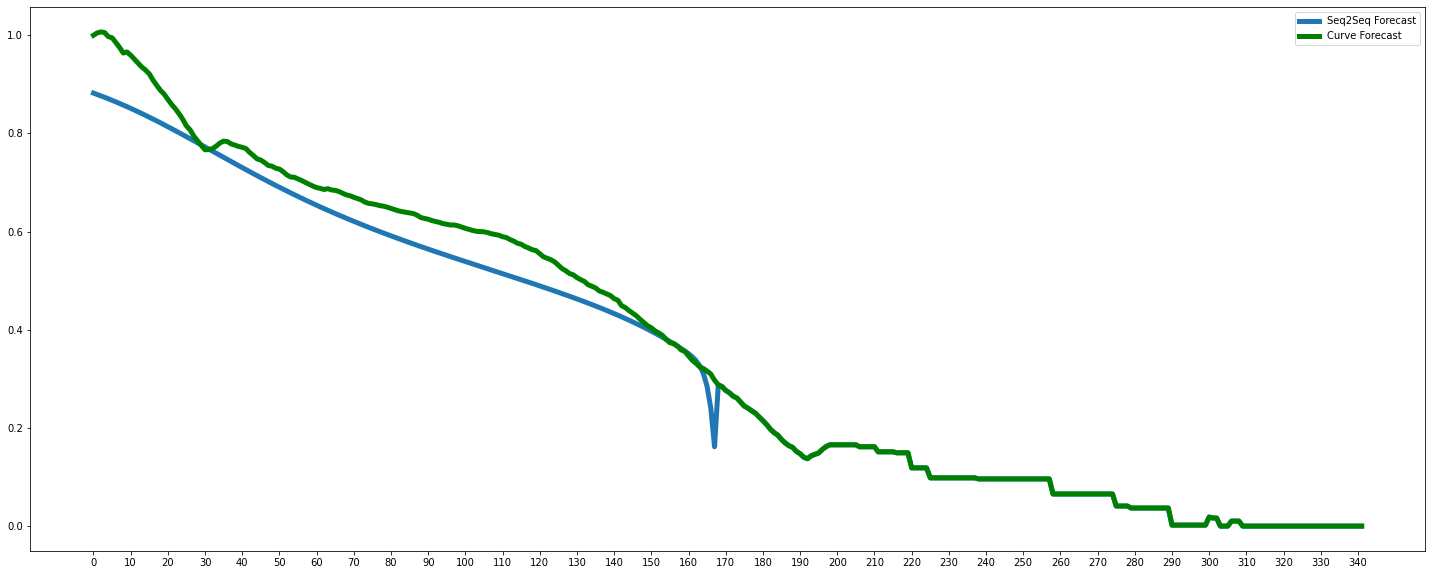

1


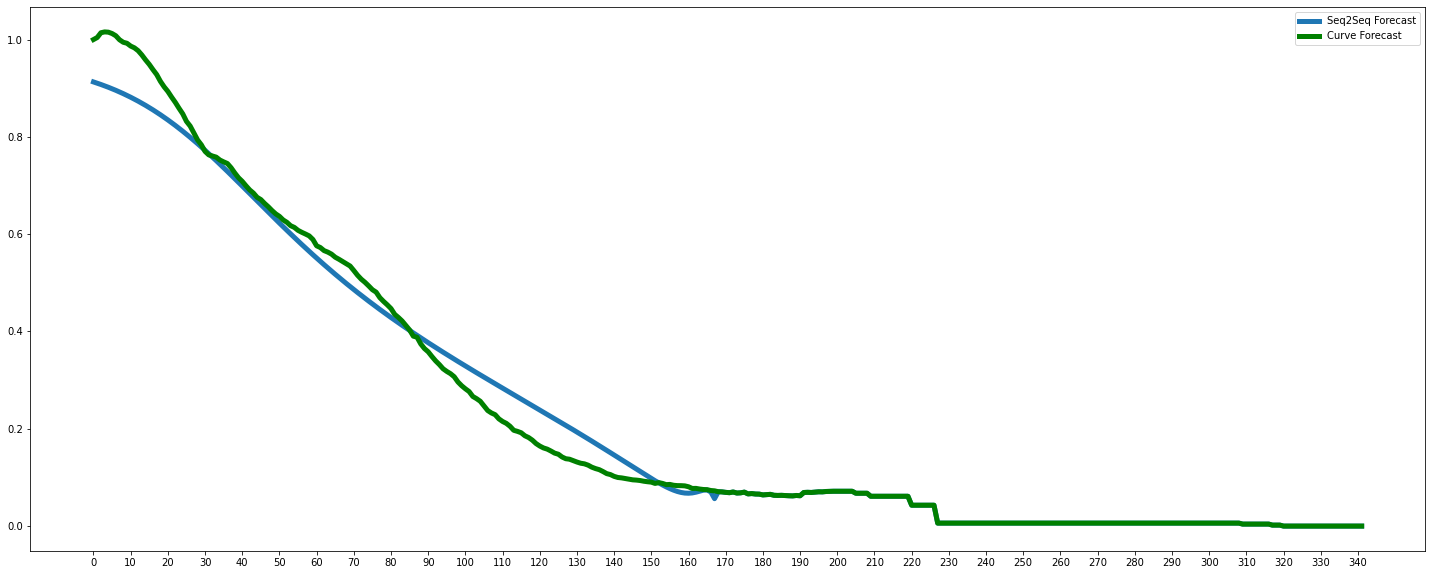

2


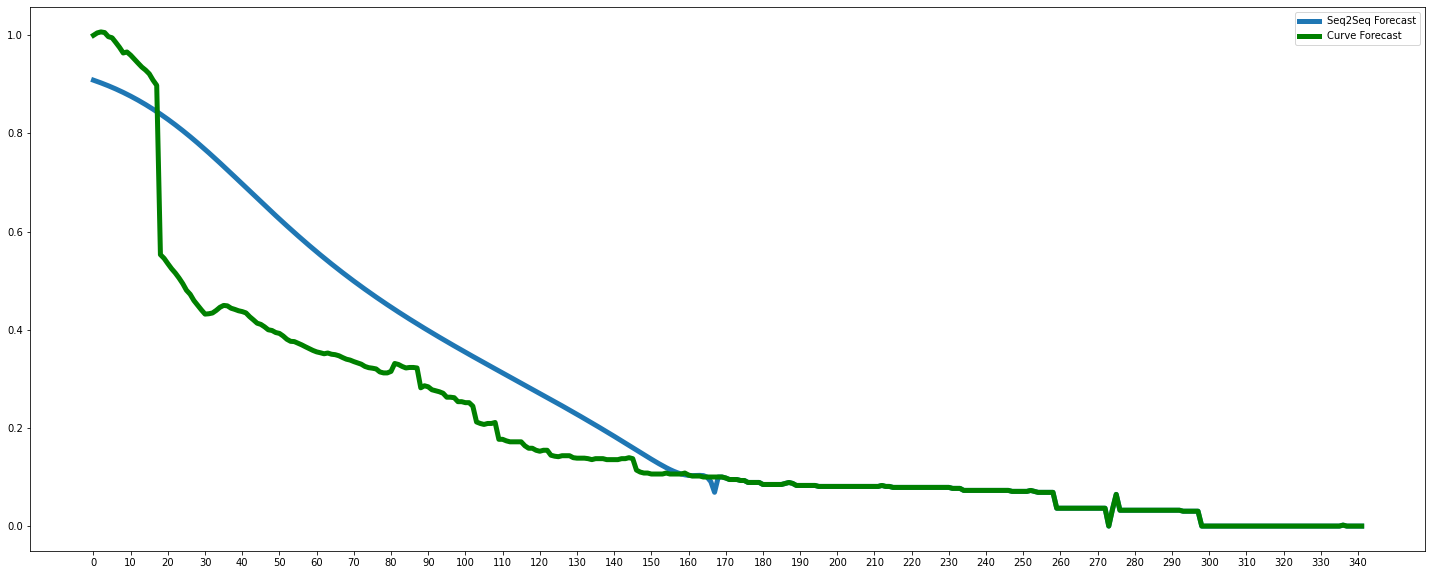

3


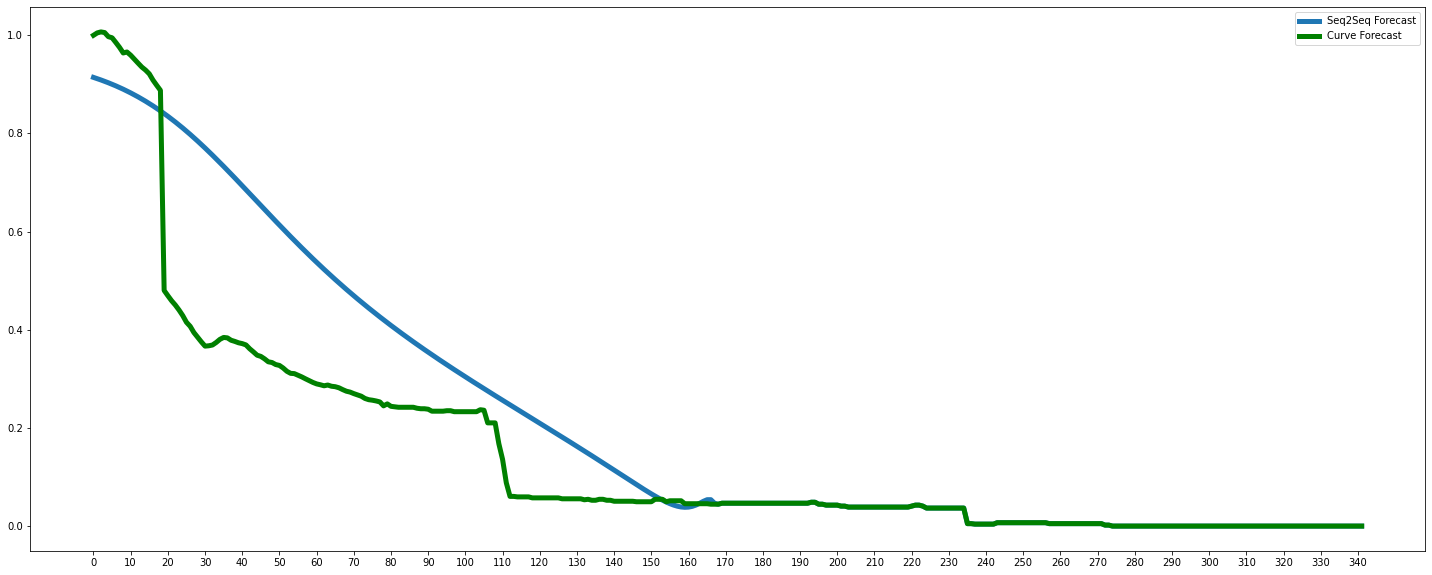

4


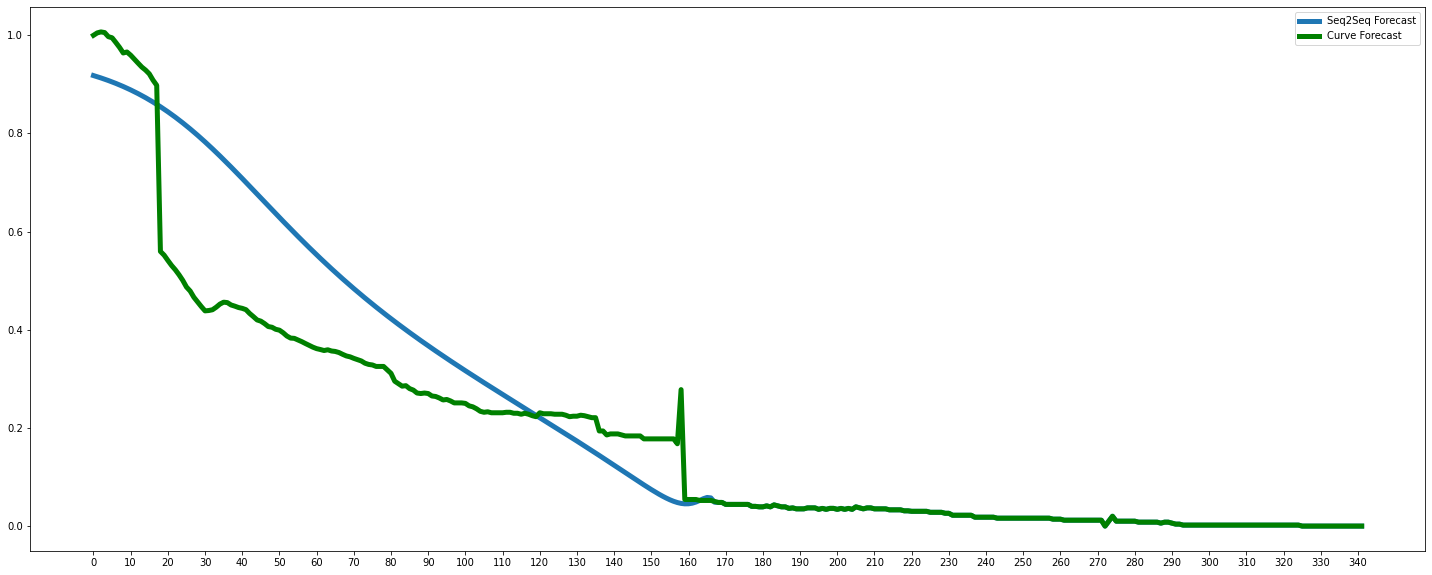

5


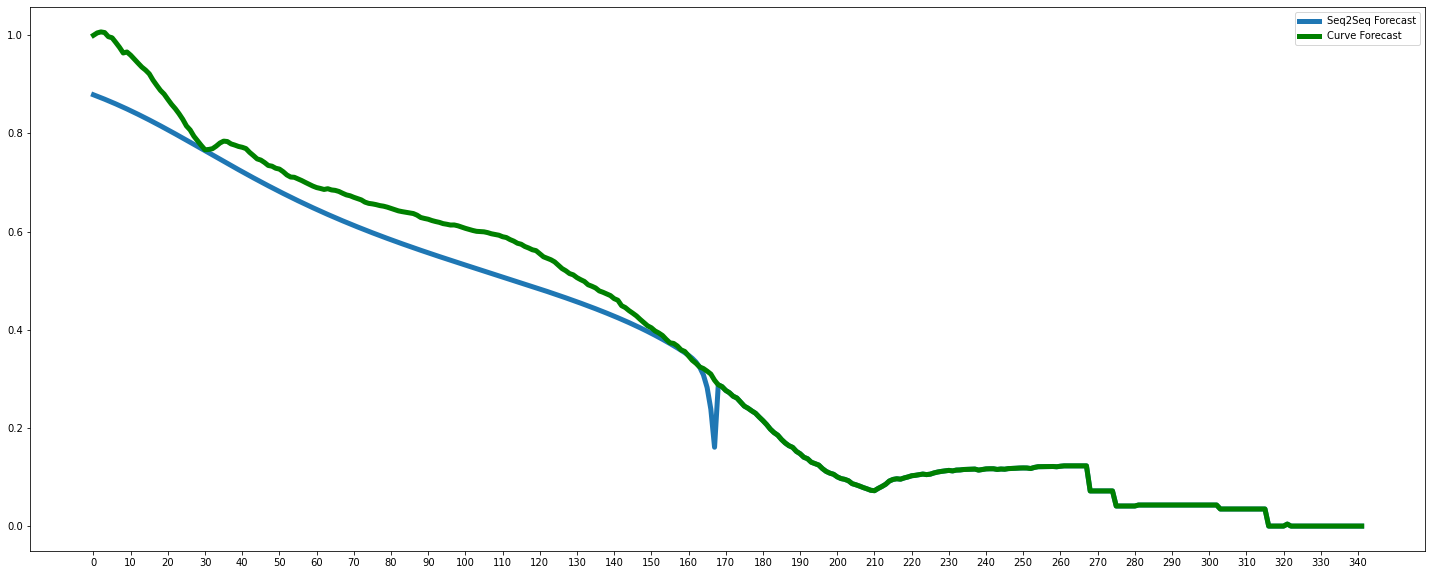

6


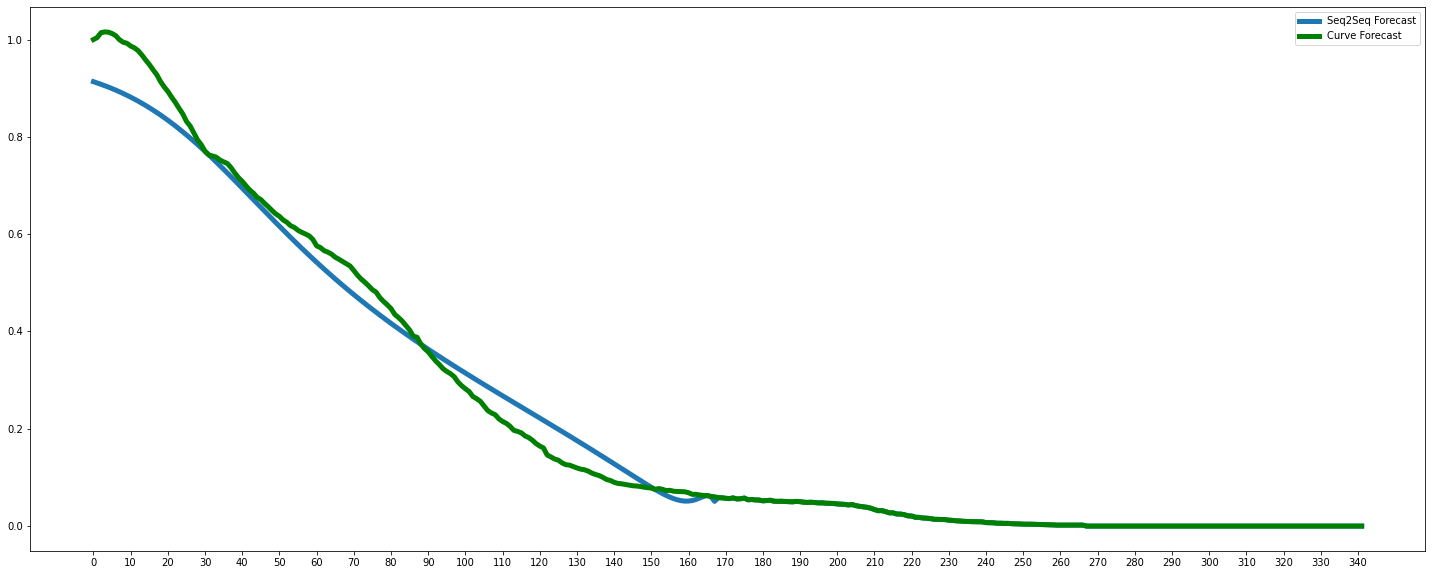

7


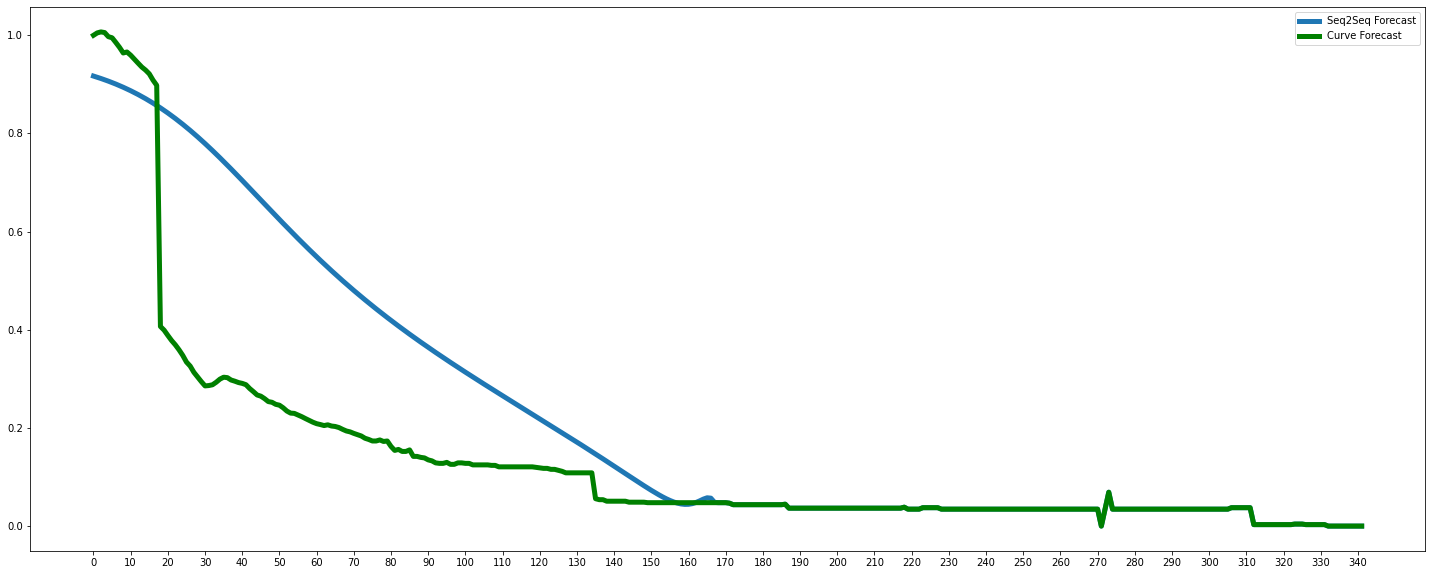

8


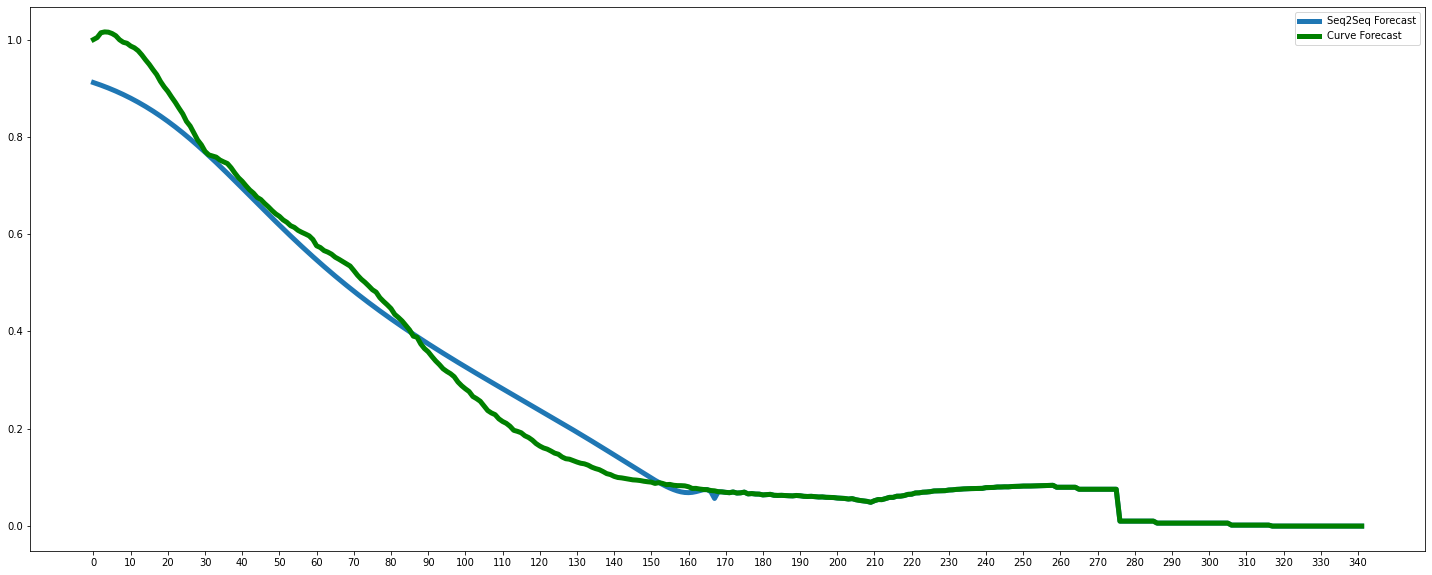

9


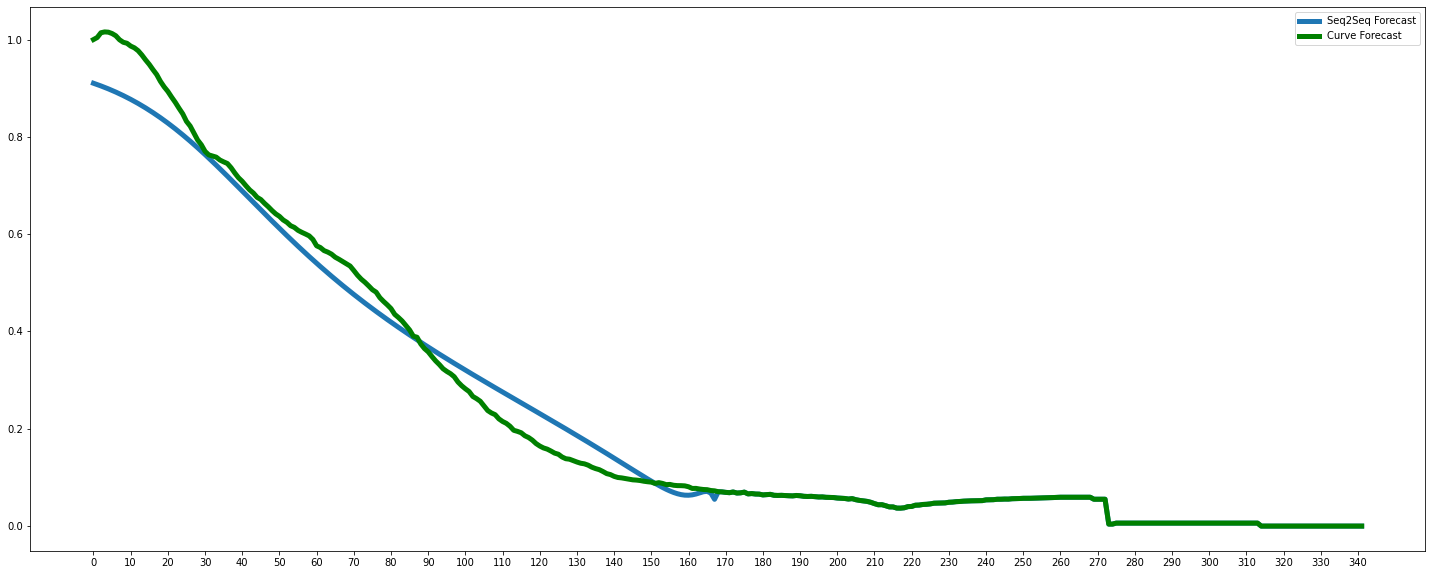

10


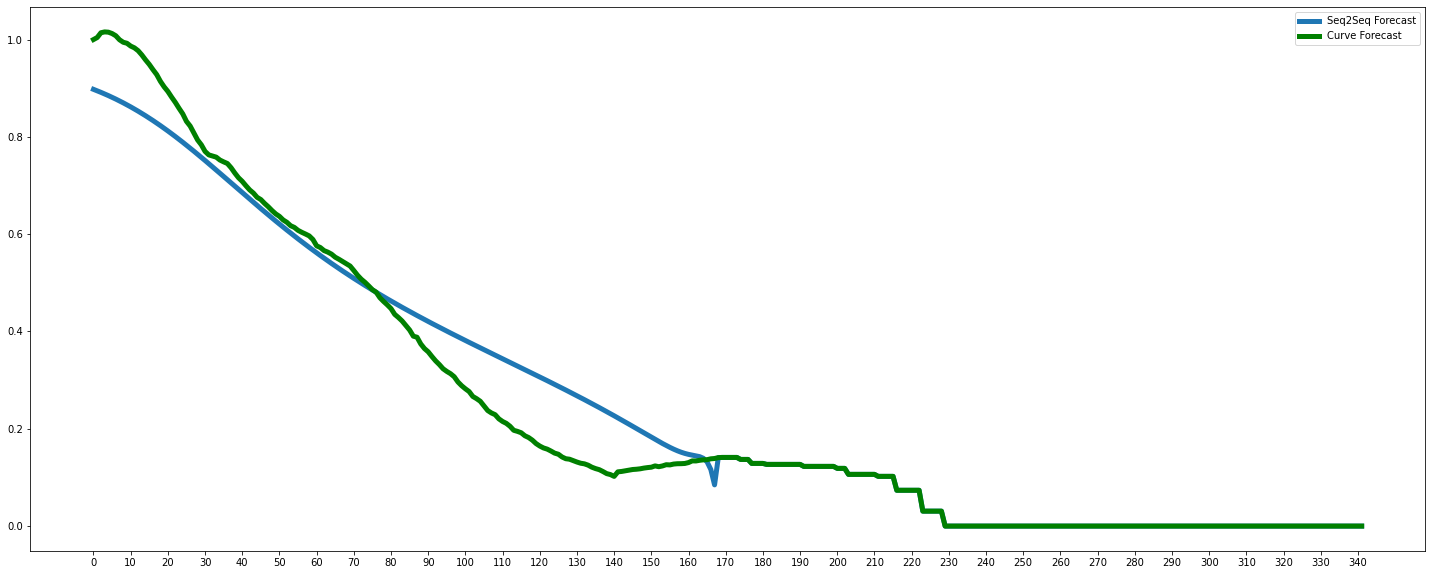

11


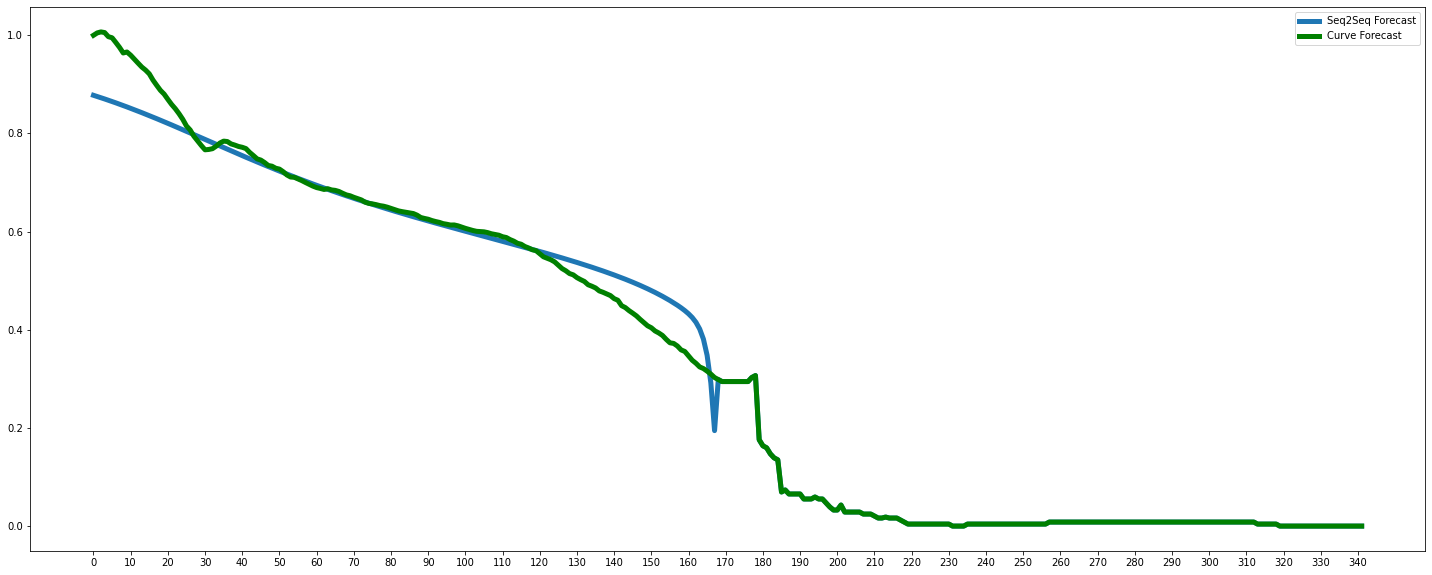

12


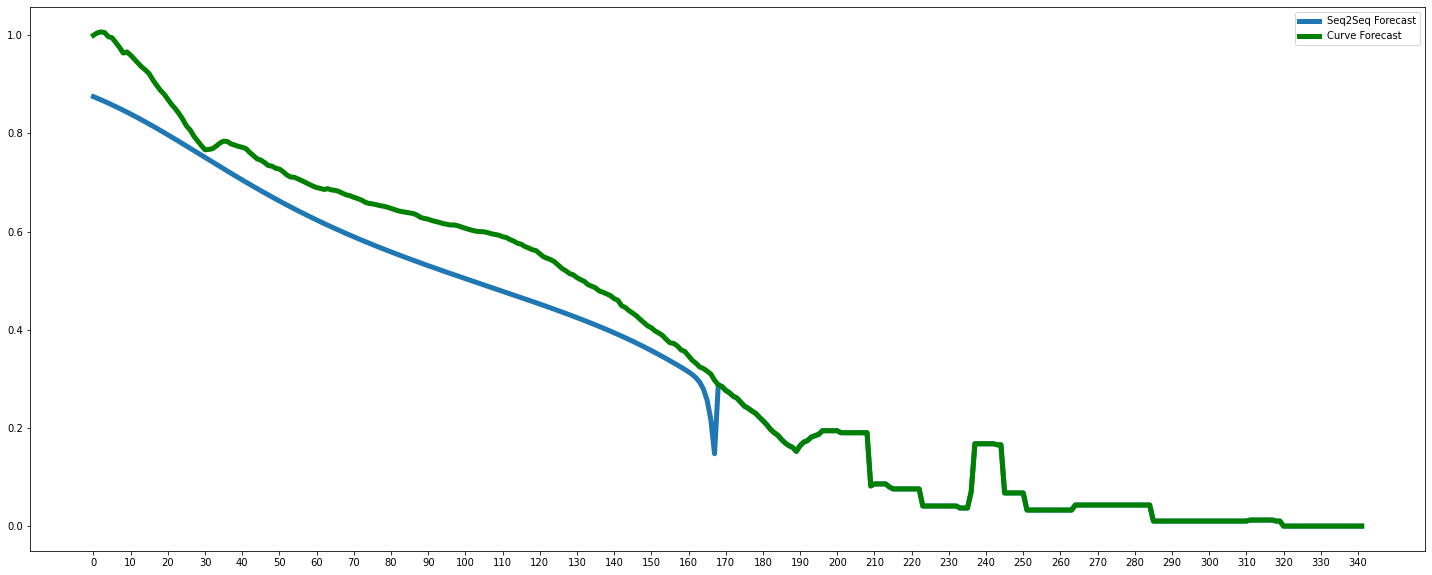

13


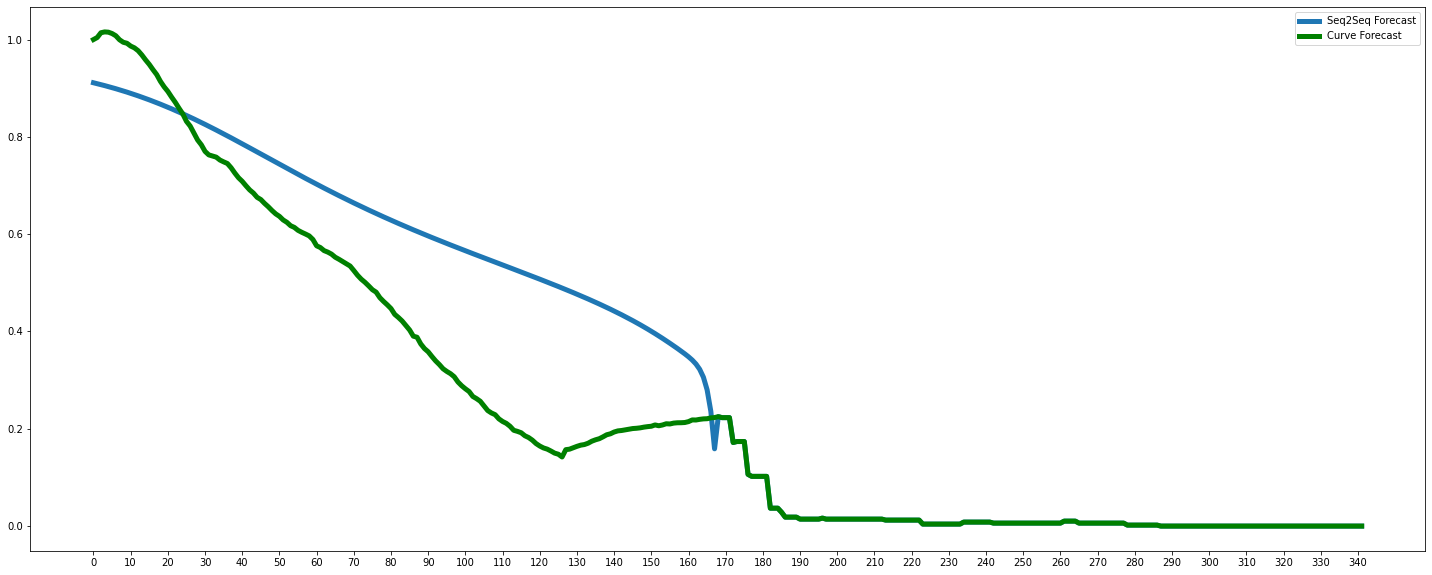

14


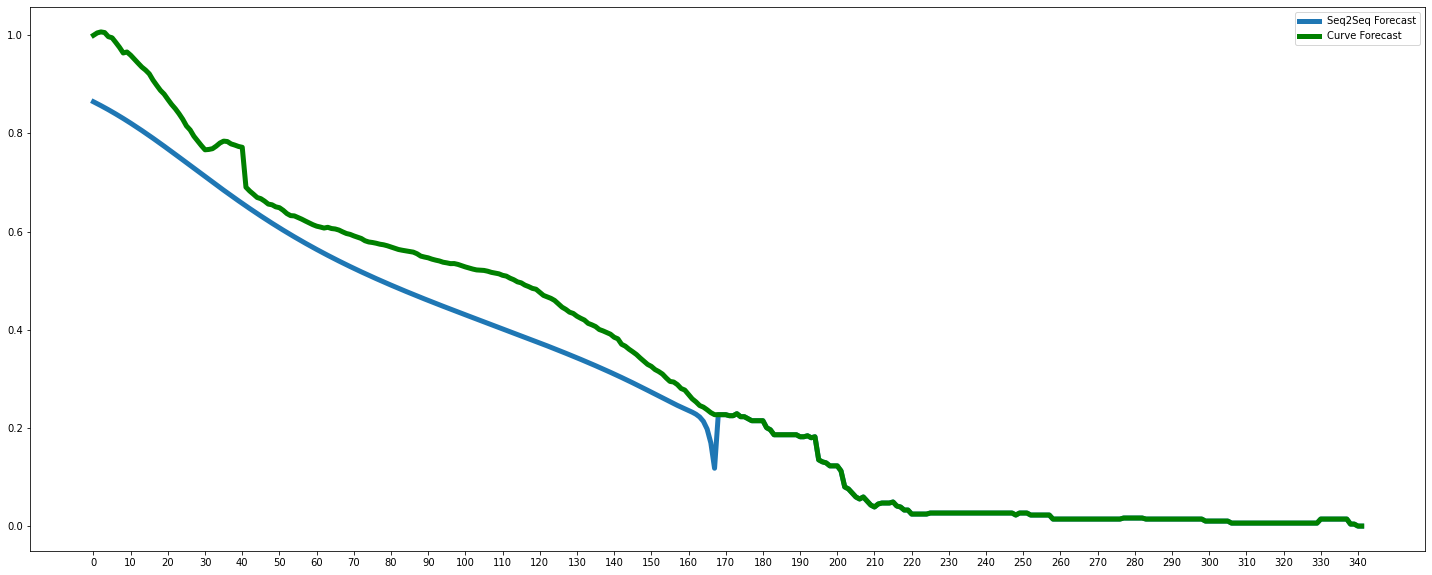

15


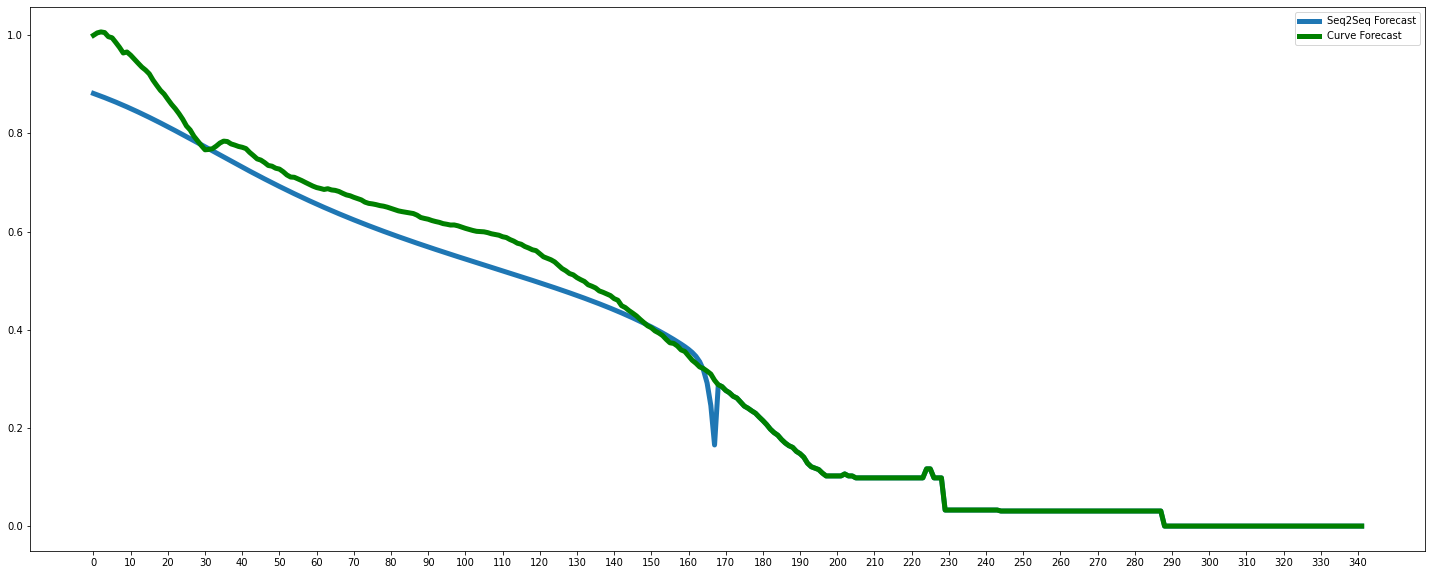

In [55]:
for v in range(df_out_xxx_dxb.shape[0]):
  print(v)
  rmse = sqrt(mean_squared_error(_df_out_xxx_dxb.loc[v,'0':'341'].values, df_out_xxx_dxb.loc[v,'0':'341'].values))
  df_out_xxx_dxb.loc[v,'RMSE_SEQ2SEQ']=rmse
  plt.figure(figsize=[25,10])
  plt.plot(df_out_xxx_dxb.loc[v,'0':'341'],  linestyle='-',linewidth=5, label='Seq2Seq Forecast')
  plt.plot(_df_out_xxx_dxb.loc[v,'0':'341'],color='green',  linestyle='-',linewidth=5, label='Curve Forecast')
  plt.legend(loc='best')
  plt.xticks(np.arange(0, 342, 10))
  plt.show()

In [56]:
df_out_dxb_xxx.head()

departure_Date Origin_Destination  Target         0         1  \
0  2023-03-13T00:00:00.000Z            DXB-XXX    1004  0.868752  0.868010   
1  2023-06-12T00:00:00.000Z            DXB-XXX     489  0.858439  0.857619   
2  2023-03-12T00:00:00.000Z            DXB-XXX     988  0.869960  0.869118   
3  2023-06-11T00:00:00.000Z            DXB-XXX     489  0.856449  0.855591   
4  2023-03-11T00:00:00.000Z            DXB-XXX     990  0.869809  0.868978   

          2         3         4         5         6  ...     333     334  \
0  0.867222  0.866383  0.865490  0.864541  0.863532  ...  0.0000  0.0000   
1  0.856759  0.855856  0.854909  0.853915  0.852872  ...  0.0000  0.0000   
2  0.868219  0.867260  0.866237  0.865145  0.863980  ...  0.0000  0.0000   
3  0.854692  0.853750  0.852764  0.851732  0.850651  ...  0.0041  0.0041   
4  0.868090  0.867144  0.866134  0.865057  0.863909  ...  0.0000  0.0000   

      335     336     337     338     339  340  341  RMSE_SEQ2SEQ  
0  0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0      0.202064  
1  0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0      0.053768  
2  0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0      0.195474  
3  0.0041  0.0041  0.0041  0.0041  0.0041  0.0  0.0      0.050341  
4  0.0000  0.0000  0.0000  0.0000  0.0000  0.0  0.0      0.190749  

[5 rows x 346 columns]

In [57]:
df_out_xxx_dxb.head()

departure_Date Origin_Destination  Target         0         1  \
0  2023-07-12T00:00:00.000Z            XXX-DXB     489  0.882190  0.879416   
1  2023-07-13T00:00:00.000Z            XXX-DXB     489  0.912871  0.910321   
2  2023-03-12T00:00:00.000Z            XXX-DXB     990  0.908534  0.905862   
3  2023-03-13T00:00:00.000Z            XXX-DXB    1008  0.914207  0.911663   
4  2023-03-11T00:00:00.000Z            XXX-DXB     996  0.917942  0.915593   

          2         3         4         5         6  ...  333  334  335  \
0  0.876567  0.873645  0.870649  0.867580  0.864440  ...  0.0  0.0  0.0   
1  0.907651  0.904855  0.901930  0.898872  0.895676  ...  0.0  0.0  0.0   
2  0.903068  0.900151  0.897104  0.893927  0.890613  ...  0.0  0.0  0.0   
3  0.908994  0.906197  0.903266  0.900196  0.896984  ...  0.0  0.0  0.0   
4  0.913127  0.910541  0.907830  0.904990  0.902015  ...  0.0  0.0  0.0   

     336  337  338  339  340  341  RMSE_SEQ2SEQ  
0  0.000  0.0  0.0  0.0  0.0  0.0      0.040771  
1  0.000  0.0  0.0  0.0  0.0  0.0      0.034939  
2  0.002  0.0  0.0  0.0  0.0  0.0      0.115644  
3  0.000  0.0  0.0  0.0  0.0  0.0      0.137293  
4  0.000  0.0  0.0  0.0  0.0  0.0      0.112043  

[5 rows x 346 columns]

In [58]:
out_seq2seq_forecast = df_out_dxb_xxx.append(df_out_xxx_dxb)

In [59]:
out_seq2seq_forecast.to_csv('out_seq2seq_forecast_raw.csv',index=False)

### Convert raw output to actual

In [60]:
df = pd.read_csv('out_seq2seq_forecast_raw.csv')

In [61]:
for n,row in df.iterrows():
  target=df.loc[n,'Target']
  for col in range(342):
    df.loc[n,str(col)] = round(df.loc[n,str(col)]*target)

In [62]:
df.to_csv('out_seq2seq_forecast.csv',index=False)